<a href="https://colab.research.google.com/github/jonbaer/googlecolab/blob/master/SimplerMambaSSM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install mamba-ssm causal-conv1d

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 6.0 MB/s eta 0:00:00
  Created wheel for mamba-ssm: filename=mamba_ssm-1.0.1-cp310-cp310-linux_x86_64.whl size=146663012 sha256=71ad1b1eafb05a6e8a41fd82e046fe85511d6378fa3a583e55215b6aa1d65ab9
  Stored in directory: /root/.cache/pip/wheels/08/cf/65/cc589985f9689241fe2c154ce1c60738f58a24e76ce474cc20
  Created wheel for causal-conv1d: filename=causal_conv1d-1.0.0-cp310-cp310-linux_x86_64.whl size=9172611 sha256=79a4bab633ebff031e615d5e8ba396b0dc0c046f4406980ee238fb86a9090038
  Stored in directory: /root/.cache/pip/wheels/9a/48/f5/eb0c6d6d8e00131eaa57927b537a23832b37e2f01b801d9c5d
Successfully built mamba-ssm causal-conv1d


In [ ]:
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

In [ ]:
!mkdir differentattention

In [ ]:
import torch
import torch.nn as nn
from torch.nn import  functional as F
from torch.nn.parameter import Parameter
from tqdm import tqdm
from mamba_ssm import Mamba
#hyperparams
epochs = 100
lr = 1e-3
batch_size = 64
block_size = 512
device = "cuda" if torch.cuda.is_available() else "cpu"
max_iters = 10000
print_iters = 100
eval_iters = 10
eval_interval = 300
n_embed=384
n_heads = 6
n_layers = 12
dropout = 0.2
# ---------
with open("input.txt", "r") as f:
  text = f.read()

# Unique characters
chars = sorted(list(set(text)))
print(''.join(chars))
vocab_size = len(chars)
print(vocab_size)

#Tokenizers
stoi = {ch:i for i,ch in enumerate(chars)}
itos = {i:ch for i,ch in enumerate(chars)}
encode = lambda xx: [stoi[x] for x in xx]
decode = lambda xx: ''.join([itos[x] for x in xx])
encode("Hello!")
print(decode(encode("Hello!")))


# train and test splits
data = torch.tensor(encode(text), dtype=torch.long)
n = int(len(data)*0.9)
train_data = data[:n]
val_data = data[n:]

def get_batch(split):
  # generate targets and context
  if split == "train":
    data = train_data
  else:
    data = val_data
  index = torch.randint(0,len(data)-block_size,(batch_size,))
  x = torch.stack([data[ind:ind+block_size] for ind in index])
  y = torch.stack([data[ind+1:ind+block_size+1] for ind in index])
  return x.to(device),y.to(device)


@torch.no_grad()
def estimate_loss():
  out = {}
  model.eval()
  for split in ['train', 'test']:
    losses = torch.zeros(eval_iters)
    for k in range(eval_iters):
      X,Y = get_batch(split)
      logits, loss = model(X,Y)
      losses[k] = loss.item()
    out[split] = losses.mean()
  model.train()
  return out


class SelfAttentionHead(nn.Module):
  def __init__(self, head_size):
    super().__init__()
    self.keys = nn.Linear(n_embed, head_size)
    self.queries = nn.Linear(n_embed, head_size)
    self.values = nn.Linear(n_embed, head_size)
    self.head_size = head_size
    self.n_embed = n_embed
    self.register_buffer('tril', torch.tril(torch.ones((block_size,block_size))).to(device))
    self.dropout = nn.Dropout(dropout)

  def forward(self, x):
    B,T,C = x.shape
    k = self.keys(x) # (B,T,C_h)
    q = self.queries(x) # (B,T,C_h)
    v = self.values(x) # (B,T,C_h)
    wei = k @ q.transpose(-1,-2) * C**(-0.5)# (B,T,T)
    wei = wei.masked_fill( self.tril[:T,:T]==0, float('-inf'))
    # wei = F.softmax(wei, dim=-1) # (B,T,T)
    wei = torch.log(torch.exp(wei)+1) # (B,T,T)
    wei = self.dropout(wei)
    out = wei @ v # (B,T,C_h)
    return out


class LayerNorm(nn.Module):
  def __init__(self, dim) -> None:
    super().__init__()
    self.eps = 1e-5
    # params
    self.gamma = nn.Parameter(torch.ones(dim))
    self.beta = nn.Parameter(torch.zeros(dim))

  def forward(self, x):
    xmean = x.mean(dim=1, keepdim=True)
    xvar = ((x-xmean)**2).mean(dim=1, keepdim=True)
    xhat = (x-xmean) / torch.sqrt(xvar + self.eps)
    self.out = self.gamma * xhat + self.beta
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

class MultiHeadAttention(nn.Module):
  def __init__(self, n_heads, head_size) -> None:
    super().__init__()
    self.heads = nn.ModuleList([SelfAttentionHead(head_size) for _ in range(n_heads)])
    self.proj = nn.Linear(n_embed, n_embed)
    self.dropout = nn.Dropout(dropout)

  def forward(self, x):
    B,T,C = x.shape
    out = torch.cat([head(x) for head in self.heads], dim=-1)
    out = self.proj(out)
    out = self.dropout(out)
    return out

class FeedForward(nn.Module):
  def __init__(self, n_embed) -> None:
    super().__init__()
    self.ffn = nn.Sequential(
      nn.Linear(n_embed, 4*n_embed),
      nn.ReLU(),
      nn.Linear(4*n_embed, n_embed),
      nn.Dropout(dropout),
    )
  def forward(self, x):
    return self.ffn(x)

class Block(nn.Module):
  def __init__(self, n_embed, n_heads) -> None:
    super().__init__()
    self.head_size = n_embed // n_heads
    # self.sa_head = MultiHeadAttention(n_heads, self.head_size)
    self.sa_head = Mamba(
      # This module uses roughly 3 * expand * d_model^2 parameters
      d_model=n_embed, # Model dimension d_model
      d_state=16,  # SSM state expansion factor
      d_conv=4,    # Local convolution width
      expand=2,    # Block expansion factor
  ).to("cuda")
    self.ffn = FeedForward(n_embed)
    self.ln1 = LayerNorm(n_embed)
    self.ln2 = LayerNorm(n_embed)


  def forward(self, x):
    x = x + self.sa_head(self.ln1(x))
    x = x + self.ffn(self.ln2(x))

    return x

class BigramNeuralNetwork(nn.Module):
  def __init__(self,vocab_size):
    super().__init__()
    self.token_embedding_table = nn.Embedding(vocab_size,n_embed)
    self.position_embedding_table = nn.Embedding(block_size,n_embed)
    self.sa_head = MultiHeadAttention(4,int(n_embed/4))
    self.lm_head = nn.Linear(n_embed,vocab_size)
    self.ffn = FeedForward(n_embed)
    self.blocks = nn.Sequential(*[Block(n_embed,n_heads=n_heads) for _ in range(n_layers)])


  def forward(self, idx, targets=None):
    # idx = idx[:,-block_size:]
    B,T = idx.shape
    tok_emb = self.token_embedding_table(idx) # (B,T,C_e)
    pos_emb = self.position_embedding_table(torch.arange(T,device=device)) # (T,C_e)
    x = tok_emb + pos_emb # (B,T,C_e)
    x = self.blocks(x) # (B,T,C_e)
    logits = self.lm_head(x) # (B,T,vocab_size)
    if targets is None:
      loss = None
    else:
      B,T,C = logits.shape
      logits = logits.view(B*T,C)
      targets = targets.view(B*T)
      loss = F.cross_entropy(logits, targets)
      logits = logits.view(B,T,C)
    return logits, loss
  def generate(self, idx, max_new_tokens):
    # idx is (B,T)
    idx_next = []
    for i in range(max_new_tokens):
      idx_cond = idx[:,-block_size:]
      logits, loss = self(idx_cond)
      last_timestep = logits[:,-1,:]
      probs = F.softmax(last_timestep, dim=1)
      next_index = torch.multinomial(probs, num_samples=1)
      idx = torch.cat((idx, next_index), dim=1)
    for arr in idx:
      print(decode(arr.cpu().detach().numpy()))
    return idx

model = BigramNeuralNetwork(vocab_size)
optimizer = torch.optim.AdamW(model.parameters(),lr=lr)

# checkpoint = torch.load('model.pt')
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# epoch = checkpoint['epoch']
checkpoint_path = None#"./differentattention/model_40.pt"
epoch = 0
if checkpoint_path:
  checkpoint = torch.load(checkpoint_path)
  print(checkpoint)
  if checkpoint['model_state_dict']:
    model.load_state_dict(checkpoint['model_state_dict'].to(device))
  if checkpoint['optimizer_state_dict']:
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  epoch = checkpoint['epoch']
device = "cuda"
m = model.to(device)
print("Uses device " + device)
MODEL_CHECKPOINT = "./differentattention/model_{iter}.pt"
losses_data = {"train":[], "test":[]}
for iter in tqdm(range(epoch ,max_iters)):
  if iter % eval_iters == 0:
    losses = estimate_loss()
    losses_data['train'].append(losses['train'].cpu().numpy())
    losses_data['test'].append(losses['test'].cpu().numpy())
    print(f"Step {iter}, train loss:{losses['train']:.4f}, test loss:{losses['test']:.4f}")

  if iter % print_iters == 0:
    losses = estimate_loss()
    torch.save({
            'epoch': iter,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': losses,
            }, MODEL_CHECKPOINT.format(iter=iter))
    losses_data['train'].append(losses['train'].cpu().numpy())
    losses_data['test'].append(losses['test'].cpu().numpy())
    model.eval()
    with torch.no_grad():
      #Generate from the model:
      output = m.generate(torch.zeros((1,2), dtype=torch.long).to(device).contiguous(), 1000  )[0].tolist()

    print(f"Step {iter}, train loss:{losses['train']:.4f}, test loss:{losses['test']:.4f}")
    model.train()

  #Get data
  xb,yb = get_batch("train")

  #Evaluate loss
  logits,loss = model(xb,yb)
  optimizer.zero_grad(set_to_none=True)
  loss.backward()
  optimizer.step()
torch.save(model.state_dict(), "./differentattention/model.pt")
#Generate from the model:
output = m.generate(torch.zeros((1,2), dtype=torch.long).to(device),1000)[0].tolist()



 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
65
Hello!
Uses device cuda


  0%|          | 0/10000 [00:00<?, ?it/s]

Step 0, train loss:4.5426, test loss:4.5502


oFP&ZdPo$iqu,Mq3kSuyYyqut-oyJbBe,&bMyz$TAUb.zPuvtS?kC-mT';ohL:XUIaIyEx$oUW-H$kp$lZHtq3MJXRap$eCc?IlDIoRV'
cSKhyJfsYXuQUpTdBOiBLWaPS&Q'Nq$Mj&qwxDLgvEjP zaR'OtSgqdJnSEMP:KuR
SEs3oamy
hxGl!clDaseLG-kYoqk WdVpUgGX-C'qdh3iLWrVbJHCusRFlkgkWRlFUCzuoZV F!J.gxa&&-oU!LNIPorgDmeRDFiUp$-LuQSoFaPHwqDV-3L qKzeLfeow-eL&fMra$OIh'aOp$g'Dr-VXhcEh;'bvoqw DNRFNFWFxN  B;NI-LKE
NFKE-F'o;LR NqAPNWFTd.dvWcr-ARgdh$DFgnFh'&gF$,I:-AXWCIXsNH,vboc-RDeFOdtDvb-F'r-boFB-A$EB;P-N.Is?DIH,DS;LgaIqrIeLuRVVCd
COhcFrHEoDsB,D,LXNM-LcRgSKIW- FLe.E:KPD'V vo&o-Wn
HIg-k EVjdYaF-ksBxNyFvS:PYBxxoc,SxBOHkHDF&WFrXNkODuohK
sLi-c.KrDvs&kFOIWvsLocIj'eIQTTDcT
?cU;,rDElDXaoe$
Fgn$IoFRVzSvNo
cFLH?cEbC,SaB&LK3HaWBsUUaouWgorvbTE'Ii-trBDucFO-?EHBgDNgnBNcFwAB'aeLocFFaUsLRv?ebxFGIfuI3NDB
$NnFFoLJzNcL?Vk,MUid;xmjx$HaIQmAFD'I-eaX WFODDgJqsUSHLiNHAtWFEF aFe,FXFFsaUBiegAFAOjWFEMMoaocnafCu?LuIhMW P MBD,R',OqsJBd!IxIcw NcnKIDIo,EFvh;vmrcU;dz,Lea,gF&--L,a$eLEcEL-xgw gacg-iqgsnvaUS;NDWO,,bUBe&KAFj$uGwjDHe

  0%|          | 10/10000 [00:23<1:34:58,  1.75it/s]

Step 10, train loss:6.5828, test loss:6.6301


  0%|          | 20/10000 [00:28<56:03,  2.97it/s]

Step 20, train loss:3.1930, test loss:3.2462


  0%|          | 30/10000 [00:33<54:58,  3.02it/s]

Step 30, train loss:2.4966, test loss:2.5259


  0%|          | 40/10000 [00:38<55:37,  2.98it/s]

Step 40, train loss:2.2535, test loss:2.2777


  0%|          | 50/10000 [00:43<56:02,  2.96it/s]

Step 50, train loss:2.1123, test loss:2.1576


  1%|          | 60/10000 [00:48<55:12,  3.00it/s]

Step 60, train loss:2.0101, test loss:2.0666


  1%|          | 70/10000 [00:53<54:53,  3.02it/s]

Step 70, train loss:1.9212, test loss:1.9988


  1%|          | 80/10000 [00:58<56:22,  2.93it/s]

Step 80, train loss:1.8356, test loss:1.9525


  1%|          | 90/10000 [01:03<55:02,  3.00it/s]

Step 90, train loss:1.7839, test loss:1.9065


  1%|          | 100/10000 [01:08<54:53,  3.01it/s]

Step 100, train loss:1.7176, test loss:1.8715


ordreeders be streene,
Nastinition.
Why, and many:
That, this them make speak'd tal it I day:
Your by strunce swe erevent is onourst movisoments,
And, I slaidy lord's ecome, thy boes bebeing rive affordrepece a Nrop theirseran a goodion
And and them he consty-s, iptose.

CATULES:
Gres for age bady, that you foucy ongn;
Fillates have dethal ancont,
but to begrand to you on nement Juee.

First undily en it thee, from ques,
Fike outer:
Lord, wark's make speak way boing in thee
Thall shit halm of read, and for heart to it highopreit in Grace.
I helcome spembom: eaching; a ge spition Edward, is not, flucinst:
Where loss, and Bet thine should of me, and Clade thy
as make unfoul command at vairs:
As be fair print have seep of Heier, you tycence deach sody. Than bay say hose
That go yeate, burch'd your Dunger that be;
And you, you cruek their tween, my branchan dider---longsand them screech find.'?

DUKE OF YORK:
Thy, surple call'd you your poich

  1%|          | 110/10000 [01:32<1:33:55,  1.75it/s]

Step 110, train loss:1.6788, test loss:1.8459


  1%|          | 120/10000 [01:37<55:38,  2.96it/s]

Step 120, train loss:1.6382, test loss:1.8279


  1%|▏         | 130/10000 [01:42<54:39,  3.01it/s]

Step 130, train loss:1.6091, test loss:1.8095


  1%|▏         | 140/10000 [01:47<55:22,  2.97it/s]

Step 140, train loss:1.5674, test loss:1.7781


  2%|▏         | 150/10000 [01:52<54:33,  3.01it/s]

Step 150, train loss:1.5516, test loss:1.7406


  2%|▏         | 160/10000 [01:57<54:27,  3.01it/s]

Step 160, train loss:1.5234, test loss:1.7248


  2%|▏         | 170/10000 [02:02<55:32,  2.95it/s]

Step 170, train loss:1.5019, test loss:1.7124


  2%|▏         | 180/10000 [02:07<54:17,  3.01it/s]

Step 180, train loss:1.4805, test loss:1.7058


  2%|▏         | 190/10000 [02:12<54:24,  3.01it/s]

Step 190, train loss:1.4647, test loss:1.6905


  2%|▏         | 200/10000 [02:17<55:23,  2.95it/s]

Step 200, train loss:1.4341, test loss:1.6635


ereteral?

erill too, let her heavener; look the pewer; and the small
The kingdom foul-request tempeties:
Alade to use groan thee; her to some worth thet?

YORK:
Adward likest track marry?
Go the sinst would regentleman's threathradies
And repay; when thirst to be all; whese were we lad,
To the Morder-st! thince that whitor From thee shall like of
Wold thy forthympers' thee we be all,
And to thiust with thee whating hither faith;
Whilst ne'er her a gentleman, they thou libed
With out within and truck, now! Bolingbrokes thus can,
And thoxe to my lord: I know a--play---
outh threeds to Mentar't Clarence, conscient:
'Tis kingdisle, though the thild
You have posies And still do bids, you on't.
So doth Ladethat this loast:
They'ir good poth or full and ruble to thy old?

Dirch Marsher:
This, 'tis doubt that we
do one tooth temption.
Conse? sceeping passion faulina.

BASTUCFIFIUS:
His so well, for Clarence your eye
By fooled sating--

Flourd:
P

  2%|▏         | 210/10000 [02:42<1:32:53,  1.76it/s]

Step 210, train loss:1.4228, test loss:1.6452


  2%|▏         | 220/10000 [02:47<54:55,  2.97it/s]

Step 220, train loss:1.4089, test loss:1.6454


  2%|▏         | 230/10000 [02:52<1:01:37,  2.64it/s]

Step 230, train loss:1.4062, test loss:1.6280


  2%|▏         | 240/10000 [02:57<54:19,  2.99it/s]

Step 240, train loss:1.3942, test loss:1.6193


  2%|▎         | 250/10000 [03:02<53:56,  3.01it/s]

Step 250, train loss:1.3759, test loss:1.5968


  3%|▎         | 260/10000 [03:07<54:47,  2.96it/s]

Step 260, train loss:1.3549, test loss:1.6205


  3%|▎         | 270/10000 [03:12<54:22,  2.98it/s]

Step 270, train loss:1.3374, test loss:1.5921


  3%|▎         | 280/10000 [03:17<53:36,  3.02it/s]

Step 280, train loss:1.3391, test loss:1.5820


  3%|▎         | 290/10000 [03:22<54:00,  3.00it/s]

Step 290, train loss:1.3292, test loss:1.5844


  3%|▎         | 300/10000 [03:27<54:47,  2.95it/s]

Step 300, train loss:1.3054, test loss:1.5712


unk'st Die!'tistion, you'ld you intent,
Romeo can your brother: yet your countenmed?
Most toward young without of your courty,--cousin's a
giost, God's daughter, nor Lancaster your lord.

Senator:
May we more, was your stare.

MENENIUS:
This you best ready? Romeo, Edward: God's good cozate
His, Caarer Lord Angelo.
3 KING HENRY, sir, I may both thy sour's ecough.

DUKE VINCENTIO:
By God's wonder, and I'ld your fletty you shall rest.

CORIOLANUS:
Husbandy come, begin me.

MISABELLA:
How well--shall bone speak.

NORTHUMBERLAND:
My Cause, you are so you.

GLOUCESTER:
Why comfort,--'dista, so, how is my foule.

JULIET:
No you,--o.

LUCIO:
And Laius, I'll not to you reyord?

CAPULET:
You next, another, Aufidon Porson.

ISABELLA:
Out one, faithfully, unwoman!

VOLUMNIA:
Towant: Ay, whom you pray
Loudly cannot your hand;' 'twas, you, lapp'd you, it do?
How wandle provoidence,--

VOLUMNIA:
No,--I't Pompey-waters, thou know'st
Thunking? Why, if you

  3%|▎         | 310/10000 [03:50<1:29:51,  1.80it/s]

Step 310, train loss:1.2880, test loss:1.5567


  3%|▎         | 320/10000 [03:55<55:17,  2.92it/s]

Step 320, train loss:1.2841, test loss:1.5609


  3%|▎         | 330/10000 [04:01<54:41,  2.95it/s]

Step 330, train loss:1.2697, test loss:1.5725


  3%|▎         | 340/10000 [04:06<53:25,  3.01it/s]

Step 340, train loss:1.2699, test loss:1.5671


  4%|▎         | 350/10000 [04:11<53:53,  2.98it/s]

Step 350, train loss:1.2596, test loss:1.5613


  4%|▎         | 360/10000 [04:16<54:21,  2.96it/s]

Step 360, train loss:1.2365, test loss:1.5422


  4%|▎         | 370/10000 [04:21<53:12,  3.02it/s]

Step 370, train loss:1.2350, test loss:1.5539


  4%|▍         | 380/10000 [04:25<53:21,  3.00it/s]

Step 380, train loss:1.2333, test loss:1.5529


  4%|▍         | 390/10000 [04:31<54:23,  2.94it/s]

Step 390, train loss:1.2182, test loss:1.5252


  4%|▍         | 400/10000 [04:36<53:08,  3.01it/s]

Step 400, train loss:1.2035, test loss:1.5388


urricious sunicy, sir,
Rivere bestow'd upon your mind you busisten,
Fife, being youth, impitition. Your counsel bount,
'Which, he's not. Good gifts advanced him, new night,
Yes, you know yourself his beauted clips you;
your honour, his reside up,
Till useter yet our sisters: as your eye oppute
your highnession, had peacent.

Quotrible, Camillo,
And every of your dispersetful drift, your pubit-cursent;
For she enternest his you: so, your virginate,
Test yet be brief your grace oathon Sicilit,
Counting yourself your duke, dreftacts
Which was young, as you as God's neuld
Welcome, besidence; yea, how fair'd your e custom, is't,
Where your prayers, yentless--on, and your'stfully
Sirrahly you, to grant, your med-armsorrow.
What you yield?

Second Gaunt:
Here, would you would Lucio; here'sly your precess.
There's I say, Rought in dost thintly, any, you,
See, one, you surage, unPrest.

BENVOLIO:
Terr'd your cousin, and is offold'stred,
Busic'd, y

  4%|▍         | 410/10000 [05:00<1:30:16,  1.77it/s]

Step 410, train loss:1.1872, test loss:1.5543


  4%|▍         | 420/10000 [05:05<54:52,  2.91it/s]

Step 420, train loss:1.1762, test loss:1.5118


  4%|▍         | 430/10000 [05:10<52:55,  3.01it/s]

Step 430, train loss:1.1761, test loss:1.5415


  4%|▍         | 440/10000 [05:15<52:44,  3.02it/s]

Step 440, train loss:1.1662, test loss:1.5129


  4%|▍         | 450/10000 [05:20<53:43,  2.96it/s]

Step 450, train loss:1.1521, test loss:1.5227


  5%|▍         | 460/10000 [05:25<53:00,  3.00it/s]

Step 460, train loss:1.1266, test loss:1.4837


  5%|▍         | 470/10000 [05:29<52:50,  3.01it/s]

Step 470, train loss:1.1090, test loss:1.5160


  5%|▍         | 480/10000 [05:34<53:39,  2.96it/s]

Step 480, train loss:1.1038, test loss:1.4828


  5%|▍         | 490/10000 [05:39<52:46,  3.00it/s]

Step 490, train loss:1.0978, test loss:1.4985


  5%|▌         | 500/10000 [05:44<52:41,  3.01it/s]

Step 500, train loss:1.0736, test loss:1.4887


sealth
To leave awhile: we will not be?
Let's life?

SLY:
Shall we flower.

LUCIO:
Come, let not the city; and of he cold condemn'd.
How blemia piev the widow?

SLY:
Many and be holies at whill.

SICINIUS:
Tybalt!

AEdile:
The Capitol.

CAMILLO:
Thus do not be home.

SICINIUS:
Bliant,
it confidency.

QUEEN:
Mine with thigh his holy heart of--
By loving instrument gillyance to coming,
And Richard of mine will.

YORK:
Then will I now girly, I thune command;
Lord Clifford could have in a hand, nigh a
Point it to become.

BRUTUS:
This is more night kin; for our things hath power
This one bear to yield, and in the crown for in
for night,
Bighcisitor'd cannot in her pline
At thine and grant time with approach.
The nobility of this, with eighbours
That harly sto in Vienna, peace is line
Of twenty and fairly would thin it,
On my port of in thine in natighs tongue.
Now in thinking his birth, thin and hearing prefty
With two cannot to hundred in mi

  5%|▌         | 510/10000 [06:09<1:29:49,  1.76it/s]

Step 510, train loss:1.0485, test loss:1.4930


  5%|▌         | 520/10000 [06:14<53:21,  2.96it/s]

Step 520, train loss:1.0533, test loss:1.4689


  5%|▌         | 530/10000 [06:19<52:27,  3.01it/s]

Step 530, train loss:1.0198, test loss:1.4730


  5%|▌         | 540/10000 [06:24<53:11,  2.96it/s]

Step 540, train loss:0.9876, test loss:1.4481


  6%|▌         | 550/10000 [06:29<52:34,  3.00it/s]

Step 550, train loss:0.9649, test loss:1.4306


  6%|▌         | 560/10000 [06:33<52:19,  3.01it/s]

Step 560, train loss:0.9507, test loss:1.3927


  6%|▌         | 570/10000 [06:38<52:53,  2.97it/s]

Step 570, train loss:0.9295, test loss:1.4041


  6%|▌         | 580/10000 [06:43<52:25,  2.99it/s]

Step 580, train loss:0.9139, test loss:1.3666


  6%|▌         | 590/10000 [06:48<52:06,  3.01it/s]

Step 590, train loss:0.8763, test loss:1.3568


  6%|▌         | 600/10000 [06:53<52:39,  2.97it/s]

Step 600, train loss:0.8553, test loss:1.3680


ursership?

ESCALUS:
O?

Gresummen come; ands a true summon our king?

BUCKINGHAM:

CLAUDIO:
The Lord's brother.

Mariar:

Justice, Caugh above.

Ghosts o' the morning?

Nurse:
make Montaink's well.

AUTOLYCUS:
Fay, the numb it on Warwick's a traitor o' the warw.

CLAUDIO:
should I not; sir, be both of England's speech:
The Duke of York.

AUTOLYCUS:
A mile somebails be sick of the maward so fasting:
see the beastle summons that he had bail'd
Was it a whipping, though thine honourable
To follow an agreedy miser who mock'd me
Unto the blood forgot.

VIRGILIA:
I'll thou afraid--

DUKE VINCENTIO:
I'll stay to the 'em.

Bostern:
A tune good father! if thou respect too much:
I love them, I'll men to From Doger thou at the
shadow in myself.

DUKE VINCENTIO:
'Tis goodly your threshold. for the matter:
'Tho not so oft thou, I pray you, madam:--

BUCKINGHAM:
Do enter thee thou, on more soon than earth;
To thou us in thy banishment. 
DUKE VINCENTIO:

  6%|▌         | 610/10000 [07:18<1:28:22,  1.77it/s]

Step 610, train loss:0.8344, test loss:1.3155


  6%|▌         | 620/10000 [07:23<52:58,  2.95it/s]

Step 620, train loss:0.8171, test loss:1.3332


  6%|▋         | 630/10000 [07:28<52:35,  2.97it/s]

Step 630, train loss:0.8058, test loss:1.3136


  6%|▋         | 640/10000 [07:33<51:54,  3.01it/s]

Step 640, train loss:0.7716, test loss:1.2877


  6%|▋         | 650/10000 [07:37<51:43,  3.01it/s]

Step 650, train loss:0.7428, test loss:1.2570


  7%|▋         | 660/10000 [07:42<52:31,  2.96it/s]

Step 660, train loss:0.7110, test loss:1.2275


  7%|▋         | 670/10000 [07:48<52:46,  2.95it/s]

Step 670, train loss:0.6918, test loss:1.2550


  7%|▋         | 680/10000 [07:52<51:37,  3.01it/s]

Step 680, train loss:0.6682, test loss:1.2035


  7%|▋         | 690/10000 [07:57<51:53,  2.99it/s]

Step 690, train loss:0.6430, test loss:1.1835


  7%|▋         | 700/10000 [08:03<52:24,  2.96it/s]

Step 700, train loss:0.6199, test loss:1.1997



turn:
Sirrah, hark;'te; 'tis 'tis so:'

Providie:
Romeo, sir.

PARIS:
Do I seriout Priam Lo,
Riserable Petruchio,
Are have at their instruction libortily.

ARCHBISHOPREY:
Prain 'AR' II:
You be honourted ere 'tis ring.
Here is the book pledrard; but his
reasony house.

VOLUMNIA:
Poor Clarence hath strict unto
grace a noble harm, but thirty.

LUCIO:
Tranio, through him convessent.

AUTOLYCUS:
O, God chom,
Call us his honour.

MERCUTIO:
A husband!

VOLUMNIA:
Learn sleep on breath? sir, you might be own air will,
I twenty ofference with child a scrat,
We preserved frattings thus to the life,
Or 'twixt his death and enjoin'd, thou liest reason.

KING RICHARD III:
Upon the offer-bones but thus.

LUCIO:

DUKE VINCENTIO:
Bid you now; hear it, misther thou dreadferd,
Shall gracious thing. To save thus worn , thus
Whipp, this that do wind, and this changed gods,
He prithee to good to the king and fortor at
The airy of the issue Edward's death?

DU

  7%|▋         | 710/10000 [08:29<1:31:43,  1.69it/s]

Step 710, train loss:0.6060, test loss:1.1579


  7%|▋         | 720/10000 [08:34<53:31,  2.89it/s]

Step 720, train loss:0.5980, test loss:1.1503


  7%|▋         | 730/10000 [08:39<51:53,  2.98it/s]

Step 730, train loss:0.5645, test loss:1.1491


  7%|▋         | 740/10000 [08:44<51:28,  3.00it/s]

Step 740, train loss:0.5429, test loss:1.1385


  8%|▊         | 750/10000 [08:49<51:41,  2.98it/s]

Step 750, train loss:0.5198, test loss:1.1204


  8%|▊         | 760/10000 [08:54<52:39,  2.92it/s]

Step 760, train loss:0.5108, test loss:1.0927


  8%|▊         | 770/10000 [08:59<51:23,  2.99it/s]

Step 770, train loss:0.4920, test loss:1.0742


  8%|▊         | 780/10000 [09:04<51:06,  3.01it/s]

Step 780, train loss:0.4700, test loss:1.0633


  8%|▊         | 790/10000 [09:09<52:32,  2.92it/s]

Step 790, train loss:0.4633, test loss:1.0640


  8%|▊         | 800/10000 [09:14<51:10,  3.00it/s]

Step 800, train loss:0.4441, test loss:1.0591


shell Mercure Surracle:

Servantable Marcius!

Second Murderer:
Say, gentle Marcius rest embrace I cade.

Second Murderer:
So prison, Marcius to ride exchange peace:
Say, Mercury Shall be rebel
Mark'd you now bark his brily peril.

Second Murderer:
Marry, yet brother Clarence:, speak you are not known:
My lip in madness, repeal merry your chair,
Come in a name what's nor private on those fats;
And when the day shall war to be, and three up
Turn the air married to the prison. We have
Your marriages by the sourt to pure weep,
As sorrow well she was me a thought we are nigh,
Stay she'll bring you now. Had we not so--
Which shall stir his and near.
Brind him that, will we use all have brind him
The maids Antigonus kneezh, prepared
Wait by man's brows the maid, being spared,
Dirsuing unnatural! what breathe physicians,
Dids' death-bawdly, which pleaseth should not sack.
Hadst thou needful body hath abmired
Afresh is done.
Ah, and having Edward

  8%|▊         | 810/10000 [09:38<1:26:54,  1.76it/s]

Step 810, train loss:0.4303, test loss:1.0426


  8%|▊         | 820/10000 [09:43<52:46,  2.90it/s]

Step 820, train loss:0.4146, test loss:1.0137


  8%|▊         | 830/10000 [09:48<50:50,  3.01it/s]

Step 830, train loss:0.4009, test loss:1.0259


  8%|▊         | 840/10000 [09:53<50:49,  3.00it/s]

Step 840, train loss:0.3834, test loss:0.9926


  8%|▊         | 850/10000 [09:58<51:23,  2.97it/s]

Step 850, train loss:0.3740, test loss:1.0191


  9%|▊         | 860/10000 [10:03<50:48,  3.00it/s]

Step 860, train loss:0.3596, test loss:1.0032


  9%|▊         | 870/10000 [10:08<50:42,  3.00it/s]

Step 870, train loss:0.3463, test loss:0.9719


  9%|▉         | 880/10000 [10:13<51:38,  2.94it/s]

Step 880, train loss:0.3436, test loss:0.9897


  9%|▉         | 890/10000 [10:18<50:54,  2.98it/s]

Step 890, train loss:0.3343, test loss:0.9700


  9%|▉         | 900/10000 [10:23<50:38,  2.99it/s]

Step 900, train loss:0.3271, test loss:0.9651


ursey kind, till now?

YORK:
Richmond is currention to kend,
Your son, hause nor we side to kill King Edward,
Your brandom consul time of kings!

YORK:
Vince we are undone for this noble gentleman?

GLOUCESTER:
Your will, to grand sorrow
To city Nay's name from Warwick, to
A Gaunt did infect corruptions
With curtails flen a doing.

Provost:
But let this day we big too soon.

LUCIO:
Richmond, with him.

DUKE VINCENTIO:
Qail this noble parce,
And witnled in your actions unloodlock,
To have still our noble ears you out to die
At waking it usurpins to sit to know.

PRINCEnnorable,
Tranio! thy day of too,
Conceiving to death his name; for,
Being o'erwhile cannot steal this time, concorn,
To way he could to miny sit and Willoughly
In withwid us neck.

ABULLA:
Even so toothing in making, with first
Having well down; till, and witness so till
in doubt?
Congervil scandal things;
Your favours we will speak for this general.

ISABELLA:
And you towar

  9%|▉         | 910/10000 [10:48<1:26:41,  1.75it/s]

Step 910, train loss:0.3002, test loss:0.9507


  9%|▉         | 920/10000 [10:52<51:17,  2.95it/s]

Step 920, train loss:0.2939, test loss:0.9371


  9%|▉         | 930/10000 [10:57<50:10,  3.01it/s]

Step 930, train loss:0.2892, test loss:0.9314


  9%|▉         | 940/10000 [11:02<51:10,  2.95it/s]

Step 940, train loss:0.2729, test loss:0.9465


 10%|▉         | 950/10000 [11:07<50:28,  2.99it/s]

Step 950, train loss:0.2671, test loss:0.9247


 10%|▉         | 960/10000 [11:12<50:18,  2.99it/s]

Step 960, train loss:0.2788, test loss:0.9129


 10%|▉         | 970/10000 [11:17<50:51,  2.96it/s]

Step 970, train loss:0.2568, test loss:0.9189


 10%|▉         | 980/10000 [11:22<50:49,  2.96it/s]

Step 980, train loss:0.2530, test loss:0.8978


 10%|▉         | 990/10000 [11:27<49:57,  3.01it/s]

Step 990, train loss:0.2451, test loss:0.8672


 10%|█         | 1000/10000 [11:32<49:58,  3.00it/s]

Step 1000, train loss:0.2445, test loss:0.8794


atchildicasterk!

BENVOLIO:
O,
Vwoe
May stay?

VOLUMNIA:
Who's come?

NORDIMER:
pratertainty, and let's have taken.

MERCUTIO:
Now, sir, leave upon 'twas there!

BENVOLIO:
Now! pardonation!

MERCUTIO:
Nay, rather we'll thither: prince Rosaliam,
To this wonder gatively bellw; away!

VOLUMBERLAND:
Vail down his own like true that away!
and Adrifteen'd not agree, what must shall be paid i' the further?

CORIOLANUS:
I am notly in patient
and that will made to study; and there we are
Come and that wills coming; for though before 'et's to a
dismal flatter word of thy counsel all at their hands
on art thou livest that but be so maid
as if 'Clips my native stups are for a senator:
'Twas nothing that we'll twenty of heaven mercy
ransor'd for thy thing wild for men for welcomed
In time to be barren forfeit or withdraw
And show their fortune camp on arms to fitch?
Go for your fortune and Wilt of lamp from a
pitiful under slay!

CLARENCE:
Brother ou

 10%|█         | 1010/10000 [11:57<1:25:03,  1.76it/s]

Step 1010, train loss:0.2302, test loss:0.9073


 10%|█         | 1020/10000 [12:02<50:46,  2.95it/s]

Step 1020, train loss:0.2169, test loss:0.8960


 10%|█         | 1030/10000 [12:07<50:06,  2.98it/s]

Step 1030, train loss:0.2125, test loss:0.9474


 10%|█         | 1040/10000 [12:12<50:30,  2.96it/s]

Step 1040, train loss:0.2033, test loss:0.8913


 10%|█         | 1050/10000 [12:17<49:50,  2.99it/s]

Step 1050, train loss:0.2103, test loss:0.9216


 11%|█         | 1060/10000 [12:22<49:35,  3.00it/s]

Step 1060, train loss:0.2017, test loss:0.8601


 11%|█         | 1070/10000 [12:27<50:39,  2.94it/s]

Step 1070, train loss:0.1841, test loss:0.8488


 11%|█         | 1080/10000 [12:32<49:37,  3.00it/s]

Step 1080, train loss:0.1821, test loss:0.8555


 11%|█         | 1090/10000 [12:37<49:20,  3.01it/s]

Step 1090, train loss:0.1718, test loss:0.8321


 11%|█         | 1100/10000 [12:42<50:12,  2.95it/s]

Step 1100, train loss:0.1715, test loss:0.8434


Murder serve in deeds.

First Lord:
Were triumphled arm happy days!

First Mercution:

FLORIZEL:
Does Benver departed wretched bows to
prison, or 'twas mercy!

FRIAR LAURENCE:
Let days her wronged lie; grant out on 't:

FRIAR LAURENCE:
Very gory!

First Lord:
Let these dead enough.

RSCHASSia, have prettic shows.

MERCUTIO:
Yet in thy demeaning heaven, my death!

ROMEO:
Where be holp!

sating in my wreak auth they cannot repair of?
Now hath not the taling is cry of York?

TYBARY 

ORIOLANUS:
Land night.

LEONTES:
I was?
what your honour?

BENVOLIO:
On both thy death?

LEONTES:
A munky the gratter tslver the angry time?

YORK:
I promised, they have many down. Your grace thou hast one
that, think not.

KING LEWIS XI:
Thus,' quoth thy name?

LEONTES:
Happy man! -
shows fetch your behing.

HENRY PERCY:
on't, thy down.

CLARENCE:
Not they not.
altogether news; and we must quarry the
twice, I beat him.

LUCIO:
Why, then; now you contrive that 

 11%|█         | 1110/10000 [13:06<1:24:12,  1.76it/s]

Step 1110, train loss:0.1617, test loss:0.8566


 11%|█         | 1120/10000 [13:11<50:14,  2.95it/s]

Step 1120, train loss:0.1605, test loss:0.8752


 11%|█▏        | 1130/10000 [13:16<50:18,  2.94it/s]

Step 1130, train loss:0.1508, test loss:0.8610


 11%|█▏        | 1140/10000 [13:21<49:18,  2.99it/s]

Step 1140, train loss:0.1473, test loss:0.8553


 12%|█▏        | 1150/10000 [13:26<49:13,  3.00it/s]

Step 1150, train loss:0.1471, test loss:0.8435


 12%|█▏        | 1160/10000 [13:31<50:13,  2.93it/s]

Step 1160, train loss:0.1330, test loss:0.8626


 12%|█▏        | 1170/10000 [13:36<49:13,  2.99it/s]

Step 1170, train loss:0.1377, test loss:0.8563


 12%|█▏        | 1180/10000 [13:41<49:01,  3.00it/s]

Step 1180, train loss:0.1418, test loss:0.8478


 12%|█▏        | 1190/10000 [13:46<50:01,  2.94it/s]

Step 1190, train loss:0.1471, test loss:0.8207


 12%|█▏        | 1200/10000 [13:51<49:42,  2.95it/s]

Step 1200, train loss:0.1422, test loss:0.8187


ector He that he that do well action here that
injuctions have set the Lord Hastings we be Edward'd he

OLY:
He should be Edward, that Lord Boy:

AUTOLYCUS:

FLORIZEL:
He what he do know the ELIXT:
Stanley but Richmond i' the gults and heavin
Stand by the body he past well become at he
right:
Look on Riveging that we are sent tide she
Falced hereof without bids you not light.

LUCIO:
Marry, you shall bear brother Romeo's obsecred
Lord out to live: think rearity
Would become miss upon him, to thread a boil.
I shall he idle better, this life ago offence:
Words bring a right fair, then we's daughter'd bawd:
This open duty bight againful welcome,
That blessings Welsh'd for well to be woied
The foe, well: of her, by Wifemen, would not deserve:
So much in bold head: let's befeech three-plieve,
To bleeps weigh: hence, bring us 'f, we'll be sweet.
What went you likewise humbly--Boutg, ah I saw!
Foul lettled by, the fight fear'st thou will see,
T

 12%|█▏        | 1210/10000 [14:15<1:22:31,  1.78it/s]

Step 1210, train loss:0.1343, test loss:0.8429


 12%|█▏        | 1220/10000 [14:20<50:32,  2.90it/s]

Step 1220, train loss:0.1340, test loss:0.8538


 12%|█▏        | 1230/10000 [14:25<48:57,  2.99it/s]

Step 1230, train loss:0.1268, test loss:0.8040


 12%|█▏        | 1240/10000 [14:30<48:46,  2.99it/s]

Step 1240, train loss:0.1191, test loss:0.8357


 12%|█▎        | 1250/10000 [14:35<49:20,  2.96it/s]

Step 1250, train loss:0.1148, test loss:0.7899


 13%|█▎        | 1260/10000 [14:40<49:39,  2.93it/s]

Step 1260, train loss:0.1132, test loss:0.8231


 13%|█▎        | 1270/10000 [14:45<48:42,  2.99it/s]

Step 1270, train loss:0.1082, test loss:0.8022


 13%|█▎        | 1280/10000 [14:50<48:34,  2.99it/s]

Step 1280, train loss:0.1014, test loss:0.8106


 13%|█▎        | 1290/10000 [14:55<49:14,  2.95it/s]

Step 1290, train loss:0.1024, test loss:0.7977


 13%|█▎        | 1300/10000 [15:00<48:15,  3.00it/s]

Step 1300, train loss:0.1020, test loss:0.8024


effests for't:
'The Peod Off weeps, fear'd the Fetsdes.

Second Lord:
'Tell her father's speed the couses
o' 'tendity; fellow 's
You can were here fit-session of those news

Father:
'Te heart no wealth, six's o'er he is known, 'scaped;'

First Senator:
'Tesdal, be Ant hither of out he were franch.

PRINCE:
With women like their franchous hours
And we are insented now his life;
They shall, our princely soon out his honours;
And what particular scowls enough, of honoured by walk,
From he present and worthy countain his friends;
I could after Cominius.

SLY:
Many whom his friends he hathful year drum, mine honour his;
But what all you have much aceckous his doing powers
Are hundred, full in his country hours;
of his husband, would he holp to each a friend
Out of his honour; I could hung for him , our hands;
Enough him his well accord him, if I could
Turn his house, since he could have him procress'd
Such more as his countenance should insue

 13%|█▎        | 1310/10000 [15:24<1:22:05,  1.76it/s]

Step 1310, train loss:0.0951, test loss:0.8040


 13%|█▎        | 1320/10000 [15:29<49:48,  2.90it/s]

Step 1320, train loss:0.0920, test loss:0.8078


 13%|█▎        | 1330/10000 [15:34<48:07,  3.00it/s]

Step 1330, train loss:0.0909, test loss:0.8285


 13%|█▎        | 1340/10000 [15:39<47:58,  3.01it/s]

Step 1340, train loss:0.0893, test loss:0.8113


 14%|█▎        | 1350/10000 [15:44<49:03,  2.94it/s]

Step 1350, train loss:0.0913, test loss:0.8171


 14%|█▎        | 1360/10000 [15:49<47:59,  3.00it/s]

Step 1360, train loss:0.0842, test loss:0.8197


 14%|█▎        | 1370/10000 [15:54<47:58,  3.00it/s]

Step 1370, train loss:0.0824, test loss:0.8085


 14%|█▍        | 1380/10000 [15:59<48:46,  2.95it/s]

Step 1380, train loss:0.0850, test loss:0.8054


 14%|█▍        | 1390/10000 [16:04<47:54,  3.00it/s]

Step 1390, train loss:0.0873, test loss:0.8027


 14%|█▍        | 1400/10000 [16:09<47:53,  2.99it/s]

Step 1400, train loss:0.0840, test loss:0.7873


Murderer:
Mute ere I swear both hide a
merriment for the country led
that Bohemia begin, that

AUTOLYCUS:

MENENIUS:
I tell have been mournings-for Rome
That he can seem to let him be very brother
Upon Richmond is gone; steward, I tender he's
The very guilty wpecks, we brief: on
my meeting friend,
I cannot go about it, madam. Gives fees it
logs, with music lessen'd vengeance, mine,
That go with themselves upon themselves,
But great the music confession,
Being of good fellow, righted gentlewomen,
And yet, bour methinks, will the thiefs of song,
from me,
Their good friends, may know their election,
And I come, in grief; which, do congeal recrection.
There keepers, my old ground gentle boot,
And when All-Soil, let's heart; and,
requitate, you mockerity.
You, and might was himself not gone, for committer,
And yet, forwardering to her?
Yourself in how meltwiest, which is grace,
And formerly whereive?
good friend, you'reign to the instant,
And

 14%|█▍        | 1410/10000 [16:34<1:22:15,  1.74it/s]

Step 1410, train loss:0.0833, test loss:0.8088


 14%|█▍        | 1420/10000 [16:39<48:36,  2.94it/s]

Step 1420, train loss:0.0819, test loss:0.8020


 14%|█▍        | 1430/10000 [16:44<47:35,  3.00it/s]

Step 1430, train loss:0.2469, test loss:0.7873


 14%|█▍        | 1440/10000 [16:49<48:03,  2.97it/s]

Step 1440, train loss:0.1089, test loss:0.7877


 14%|█▍        | 1450/10000 [16:54<47:28,  3.00it/s]

Step 1450, train loss:0.0896, test loss:0.7948


 15%|█▍        | 1460/10000 [16:59<47:31,  2.99it/s]

Step 1460, train loss:0.0829, test loss:0.7820


 15%|█▍        | 1470/10000 [17:04<48:21,  2.94it/s]

Step 1470, train loss:0.0742, test loss:0.7978


 15%|█▍        | 1480/10000 [17:09<48:08,  2.95it/s]

Step 1480, train loss:0.0714, test loss:0.7842


 15%|█▍        | 1490/10000 [17:14<47:26,  2.99it/s]

Step 1490, train loss:0.0684, test loss:0.7835


 15%|█▌        | 1500/10000 [17:19<47:26,  2.99it/s]

Step 1500, train loss:0.4468, test loss:1.2549


all loather kolder:

DUCHESS OF YORK:

Lord Had a lowly kill metal, O would the chare's
a
plotker early son? O kind how I look'd up in the king
shall bear hate Romeo talk of mour look'd
Upon kee that Henry's wallow may up to ordsate
ha thee by foolo odd keel of the dofford's breath.

BUCKINGHAM:
Cankle officert was Edaes wofullo so home,
But sooking the king foolous doomortal make
A king hath brought uponF me asce,
Came  poor on some obedience to cupoofousor
So  offic ao I thank a burily comeo God!
e Edward, though battle!
Could butch hims shall be come fool, butchereaf:
Bohemike him sucreous tool, more fublood in Jucore.
Was't thou part booodockme most of Tredoocd
Become off on mucatooocbound this foool!
A causoff of coupoison! owe could have been,
So our worship; butchere! the celfst but change too;
Bools upoof him, make him sou dock toother, of my word
Who
said his foe; Bolk usureo. Go foful coffing it cry!
scrooch office make, whose 

 15%|█▌        | 1510/10000 [17:43<1:20:23,  1.76it/s]

Step 1510, train loss:0.3878, test loss:1.0882


 15%|█▌        | 1520/10000 [17:48<47:41,  2.96it/s]

Step 1520, train loss:0.2741, test loss:0.9397


 15%|█▌        | 1530/10000 [17:53<47:27,  2.97it/s]

Step 1530, train loss:0.2061, test loss:0.8303


 15%|█▌        | 1540/10000 [17:58<47:19,  2.98it/s]

Step 1540, train loss:0.1681, test loss:0.7680


 16%|█▌        | 1550/10000 [18:03<46:52,  3.00it/s]

Step 1550, train loss:0.1420, test loss:0.7565


 16%|█▌        | 1560/10000 [18:08<47:20,  2.97it/s]

Step 1560, train loss:0.1231, test loss:0.7219


 16%|█▌        | 1570/10000 [18:13<48:11,  2.91it/s]

Step 1570, train loss:0.1082, test loss:0.7283


 16%|█▌        | 1580/10000 [18:18<46:50,  3.00it/s]

Step 1580, train loss:0.0996, test loss:0.7312


 16%|█▌        | 1590/10000 [18:23<46:41,  3.00it/s]

Step 1590, train loss:0.0933, test loss:0.7340


 16%|█▌        | 1600/10000 [18:28<47:41,  2.94it/s]

Step 1600, train loss:0.0883, test loss:0.7021


blelding i' the cellish o'er?

Second Murderer:
'Tis govern old Services be
it lawfully.

obedience we should have you delirer's blood
o' Marying like a courtengoos!

Second Mercutio's lieutenant have I
keep or do in't
with loating 'twere here all 'the light:' sleep where it is in
re too delight
have a thought live armour in the murder well.

ir the:
report blow that noble lord: this
me armour, is gone and the gods,
at the least of deserve
But quite the many 't: of 'twere the life, in my
Mest are true this, though I cannot
Marry 't, this scatter,' flowers unto the orator,
Bid go unre unto the thing brawls, but
thou or bitter must throw govern eye, sir,
Even more so nature, :

GLOUCESTER:

BALTHASAR:
My brother else, ho, a gentleman
Should be thus to my slatter'd word:
No, Bolingbroke, thou stay'd and sooner be
the sovereign in thy noble spirit!

EDWARD:
I bury, because thee so unbid,
yet prattle, play your mistress slay we call so
put at

 16%|█▌        | 1610/10000 [18:52<1:18:31,  1.78it/s]

Step 1610, train loss:0.0789, test loss:0.7487


 16%|█▌        | 1620/10000 [18:57<47:57,  2.91it/s]

Step 1620, train loss:0.0755, test loss:0.6957


 16%|█▋        | 1630/10000 [19:02<47:18,  2.95it/s]

Step 1630, train loss:0.0734, test loss:0.7222


 16%|█▋        | 1640/10000 [19:07<46:15,  3.01it/s]

Step 1640, train loss:0.0669, test loss:0.7354


 16%|█▋        | 1650/10000 [19:12<46:21,  3.00it/s]

Step 1650, train loss:0.0649, test loss:0.7274


 17%|█▋        | 1660/10000 [19:17<47:12,  2.94it/s]

Step 1660, train loss:0.0595, test loss:0.6962


 17%|█▋        | 1670/10000 [19:22<46:14,  3.00it/s]

Step 1670, train loss:0.0573, test loss:0.7189


 17%|█▋        | 1680/10000 [19:27<46:19,  2.99it/s]

Step 1680, train loss:0.0559, test loss:0.7485


 17%|█▋        | 1690/10000 [19:32<46:53,  2.95it/s]

Step 1690, train loss:0.0564, test loss:0.7095


 17%|█▋        | 1700/10000 [19:37<46:21,  2.98it/s]

Step 1700, train loss:0.0537, test loss:0.7326


Walk so we we wolls:
'Ford way not we sad, 'twas woe the
sullar breath of Hollanders;   SIR XERLET:

JULIET:
Ye women day half out with the darken still be example
What word the Duke of Norfolk.

First Senator:
That date may him do little better lunguity.

ISABELLA:
Sir, we may obey here Angelo: but a desire as rub.

Clown:
He's a brave I put intent the burst of.
I cannot sleep earth.

First Marwick:
So love me I can dwant.

HOMBERLAND:
NoHoli. Tame that a bear with a cause.

MERCUTIO:
I love it faith.

ISABELLA:
Ay, when from me was ne'er like a foster curse.

First Seemer:
No mate I warrant and berett one peep.

MERCUTIO:
Saw what comes remembers? care I am man in thine.

ROMEO:
And she be at married when be I am, as in me.
Madest thou, if the news.

MERCUTIO:
Now, what is must raled as he has enemies.

SICINIUS:
I am king it.

BRUTUS:
If and me.

MERCUTIO:
fairest that pregnant is am. Camillo; as I learn'd, must in brief?

AUFIDIUS:
N

 17%|█▋        | 1710/10000 [20:01<1:17:43,  1.78it/s]

Step 1710, train loss:0.0519, test loss:0.7178


 17%|█▋        | 1720/10000 [20:06<47:40,  2.90it/s]

Step 1720, train loss:0.0494, test loss:0.6926


 17%|█▋        | 1730/10000 [20:11<45:54,  3.00it/s]

Step 1730, train loss:0.0486, test loss:0.7392


 17%|█▋        | 1740/10000 [20:16<45:47,  3.01it/s]

Step 1740, train loss:0.0482, test loss:0.7078


 18%|█▊        | 1750/10000 [20:21<46:21,  2.97it/s]

Step 1750, train loss:0.0482, test loss:0.7151


 18%|█▊        | 1760/10000 [20:26<45:54,  2.99it/s]

Step 1760, train loss:0.0502, test loss:0.7269


 18%|█▊        | 1770/10000 [20:31<45:41,  3.00it/s]

Step 1770, train loss:0.0477, test loss:0.7239


 18%|█▊        | 1780/10000 [20:36<46:29,  2.95it/s]

Step 1780, train loss:0.0472, test loss:0.7389


 18%|█▊        | 1790/10000 [20:41<46:12,  2.96it/s]

Step 1790, train loss:0.0430, test loss:0.7251


 18%|█▊        | 1800/10000 [20:46<45:44,  2.99it/s]

Step 1800, train loss:0.0434, test loss:0.7194


didmad me not the king for the dead mankind
commit him did not the king be the sea.

DUKE OF YORK:

Mended madam, word 'just do the dial the
morrow that the Tybalt's degree the worldly simple
the doth the Tamworth to 's dead the dam?

Second Of the world.

DUKE OF YORK: I think here for a
dismiss much upon't.

RATCLIFF:
In Rome my sawly.

AUFIDIUS:
O them deposed; 'tis he should of the day dock

First Senator:

ISABELLA:
I do write of me.

ANTIGONUS:
remember, raise it.

CATESBY:
Not well them.

JULIET:
good! I do not speak but I cannot tell from
our meet,--for in the good whom I,
not leaves.

BUCKINGHAM:
I sent him not.

ANGELO:

ISABELLA:
Before I see the wilt so no deep.

NORTHUMAS:
Ay, reckless she, more in 'elder.

Clown:
They that the villain's charge is head.

Servant:
I what has before--

TRATIO:
And fixil vex would I love that the hand lived?

Second Of ADY:
I cannot forget death.

BRAKENBURY:
Let Tim do the holy hot Romeo's son

 18%|█▊        | 1810/10000 [21:10<1:17:23,  1.76it/s]

Step 1810, train loss:0.0434, test loss:0.7202


 18%|█▊        | 1820/10000 [21:15<46:08,  2.96it/s]

Step 1820, train loss:0.0393, test loss:0.7174


 18%|█▊        | 1830/10000 [21:20<45:08,  3.02it/s]

Step 1830, train loss:0.0418, test loss:0.7593


 18%|█▊        | 1840/10000 [21:25<46:11,  2.94it/s]

Step 1840, train loss:0.0368, test loss:0.7450


 18%|█▊        | 1850/10000 [21:30<45:40,  2.97it/s]

Step 1850, train loss:0.0398, test loss:0.7476


 19%|█▊        | 1860/10000 [21:35<45:07,  3.01it/s]

Step 1860, train loss:0.0407, test loss:0.8124


 19%|█▊        | 1870/10000 [21:40<45:31,  2.98it/s]

Step 1870, train loss:0.0392, test loss:0.7441


 19%|█▉        | 1880/10000 [21:45<45:58,  2.94it/s]

Step 1880, train loss:0.0398, test loss:0.7075


 19%|█▉        | 1890/10000 [21:50<45:07,  3.00it/s]

Step 1890, train loss:0.0366, test loss:0.6875


 19%|█▉        | 1900/10000 [21:55<44:59,  3.00it/s]

Step 1900, train loss:0.0379, test loss:0.7219


THoic on 'More Tome:

EDWARD:
'Tis odd behold, Lord Angelo with a torch.

QUEEN MARGARET:
To London with English dogracious mother,
En Tops of Time Lord Hastings a Verona
On Tybalt's death, do I expited zeating
His fortness for death Edward feel I
Heart to hide his own charity.

KING RICHARD II:
Then for this os the town, although it on.

JULIET:
One LETRENIO:
Bid her how now, ourselves to sit princes, who sold
favour in the moons, still find attain betal
Fools desperate would dive QUenching I would ain
to God's smooth the state! And here which he loves to cheek,
By soil in my good dances so with all still.

JULIET:
Make his wisely love, and swear so.
Camillo and the fortunate I stand like so bs!--
Messenger: well me wend, in do know with age.

BUCKINGHAM:
Let his foe us warriors, go ap with me!

JULIET:
I'll mean, sir: every , or show so love, since: let me castle:
His fair lord,
Valine, Gaunt Serving, I all to find our care.
Ho lords, 

 19%|█▉        | 1910/10000 [22:19<1:16:26,  1.76it/s]

Step 1910, train loss:0.0366, test loss:0.7524


 19%|█▉        | 1920/10000 [22:24<45:32,  2.96it/s]

Step 1920, train loss:0.0339, test loss:0.7800


 19%|█▉        | 1930/10000 [22:29<45:11,  2.98it/s]

Step 1930, train loss:0.0364, test loss:0.7481


 19%|█▉        | 1940/10000 [22:34<45:15,  2.97it/s]

Step 1940, train loss:0.0341, test loss:0.7628


 20%|█▉        | 1950/10000 [22:39<44:29,  3.02it/s]

Step 1950, train loss:0.0353, test loss:0.7317


 20%|█▉        | 1960/10000 [22:44<44:20,  3.02it/s]

Step 1960, train loss:0.0348, test loss:0.7324


 20%|█▉        | 1970/10000 [22:49<45:39,  2.93it/s]

Step 1970, train loss:0.0358, test loss:0.7321


 20%|█▉        | 1980/10000 [22:54<44:24,  3.01it/s]

Step 1980, train loss:0.0334, test loss:0.7318


 20%|█▉        | 1990/10000 [22:59<44:33,  3.00it/s]

Step 1990, train loss:0.0323, test loss:0.7335


 20%|██        | 2000/10000 [23:04<45:13,  2.95it/s]

Step 2000, train loss:0.0316, test loss:0.7242


Northlike cords!

Lord Marquit heartily:

Corioli like the world be counted?

Second Murderer:
Thenime Paris have I to enrither be done?

First Murderer:

Paint Citizen!

Lord Mayor:
Dear be his hell-to 't, Bredelme, be imparted
he harm been! what be in liuser that?

Second Citizen:
I will committed him in: he could kill then,--

ISABELLA:
But in him I beseem, better, in it be,--

LUCIO:
If it shsphker, time it in men, make
the knight in it is, I think it is sweet, I part thy help.

BENVOLIO:
but this the 'em.

Clarencence!

GEORGE:
I know not: gift it is, but tell come now.

Cluckerer, Vaughan, gentle boy!

PARIS:
He gentles the banish'd custom twain; this tceen
And passage you home, is to your Clarence; you send
At the grief; no, BENVOLIO:
And leap, to every land with thy cousin bid
That not say your king, you'll be my kin should Caius is
a
banish'd yes of kinsman! Delpish the body did leiger is
As this into give a dance's bulking--

i

 20%|██        | 2010/10000 [23:28<1:14:33,  1.79it/s]

Step 2010, train loss:0.0314, test loss:0.7325


 20%|██        | 2020/10000 [23:33<45:08,  2.95it/s]

Step 2020, train loss:0.0338, test loss:0.7261


 20%|██        | 2030/10000 [23:38<44:57,  2.95it/s]

Step 2030, train loss:0.0313, test loss:0.7278


 20%|██        | 2040/10000 [23:43<44:11,  3.00it/s]

Step 2040, train loss:0.0323, test loss:0.7679


 20%|██        | 2050/10000 [23:48<44:18,  2.99it/s]

Step 2050, train loss:0.0311, test loss:0.7184


 21%|██        | 2060/10000 [23:53<45:07,  2.93it/s]

Step 2060, train loss:0.0312, test loss:0.7759


 21%|██        | 2070/10000 [23:58<44:12,  2.99it/s]

Step 2070, train loss:0.0331, test loss:0.7238


 21%|██        | 2080/10000 [24:03<44:02,  3.00it/s]

Step 2080, train loss:0.0342, test loss:0.7316


 21%|██        | 2090/10000 [24:08<44:30,  2.96it/s]

Step 2090, train loss:0.0313, test loss:0.7571


 21%|██        | 2100/10000 [24:13<44:17,  2.97it/s]

Step 2100, train loss:0.0333, test loss:0.7482


All Boli?

GREGORY:
Marry's All-house o' Wales, Signior Lrcile on GRANGARET:

GLOUCESTER:

POMPHENRY VI:
So long mayst o'erleise charity Loving Abhors
May will so study?

PRINCE LEWIS XI:
Romeo's o'er--

GLOUCESTER:
Look of Warwick, Marcius,
You off Marcius Richmonds.

YORK:ation:
All Cousin, by your impartial.

GLOUCESTER:
Alack.

GLOUCESTER:

FRIAR MENENGR:
I'll not, sirrah, what raise is with Antial.

GLOUCESTER:
Amity, since?

SAMPSON:
Will, my lord, Tituser is how they Caius?

POMPEY:
Shall hasad upon you.

GLOUCESTER:
Ay that have son.

GLOUCESTER:
Not now to rivate and lose.

GREGORY:
What misadvantage of our season? Gentlemen,
And CAPULET:
Say how that satisfied: then, who see thee thine?

RICHARD:
Ah, knave said, and am.

AGHORSON:
Yet that is TI.

SLY:
You're shall.

GLOUCESTER:
Ab Caefised, heIr that had rather hid.

GLOUCESTER:
Both they call thee from my death,
And thus away had a branch words half.

GLOUCESTER:

Aufidish 'G

 21%|██        | 2110/10000 [24:37<1:13:41,  1.78it/s]

Step 2110, train loss:0.0336, test loss:0.7624


 21%|██        | 2120/10000 [24:42<45:33,  2.88it/s]

Step 2120, train loss:0.0299, test loss:0.7190


 21%|██▏       | 2130/10000 [24:47<43:42,  3.00it/s]

Step 2130, train loss:0.0511, test loss:0.7714


 21%|██▏       | 2140/10000 [24:52<43:30,  3.01it/s]

Step 2140, train loss:0.0811, test loss:0.8018


 22%|██▏       | 2150/10000 [24:57<44:49,  2.92it/s]

Step 2150, train loss:0.0694, test loss:0.7996


 22%|██▏       | 2160/10000 [25:02<43:48,  2.98it/s]

Step 2160, train loss:0.0624, test loss:0.7593


 22%|██▏       | 2170/10000 [25:07<43:30,  3.00it/s]

Step 2170, train loss:0.0579, test loss:0.7561


 22%|██▏       | 2180/10000 [25:12<44:20,  2.94it/s]

Step 2180, train loss:0.0489, test loss:0.7558


 22%|██▏       | 2190/10000 [25:17<44:05,  2.95it/s]

Step 2190, train loss:0.0455, test loss:0.7575


 22%|██▏       | 2200/10000 [25:22<43:16,  3.00it/s]

Step 2200, train loss:0.0439, test loss:0.7845


K:
'Tis Angelo in 'Madam,'

KING EDWARD IV:

LADY CATESBY:
'Tis in Suppose of Lord:

QUEEN MARGARET:
'Tis in SCATUS:
Upon no hatre; let's go extol it do

PATESBY:
'Tis no ona, Juliet you a Jacontroon of you
So debate you have vipage of you a justly nox,
To purpose of fruit, for I am some, exce is

Firsel, out loss, of no, go: you cannot a for Irince?

ANGELO:
Ha! our hath not recover the back, and leave
a came of world, since are it you.

GLOUCESTER:
Do, no so virtue, whom it is.

TRANIO:
Take her no more I is or you much, for such one:
Respecial, sir, my no   off of night for a cause
To purpose and beauty micame of a word one,
Uncle of bestride our faces but one of wintoc,
As of worm should indeed and a bound roses
Tuict on the chose of hollow cross of infus' crown;
And of fussion fears nime, for nose for a king!

RIVERS:
The off our Tower in ears unless? if hos our office?
And most on, of unjustice should of none hath more
Take wneen i

 22%|██▏       | 2210/10000 [25:46<1:14:05,  1.75it/s]

Step 2210, train loss:0.0444, test loss:0.7596


 22%|██▏       | 2220/10000 [25:51<44:01,  2.95it/s]

Step 2220, train loss:0.0405, test loss:0.7265


 22%|██▏       | 2230/10000 [25:56<42:51,  3.02it/s]

Step 2230, train loss:0.0396, test loss:0.6982


 22%|██▏       | 2240/10000 [26:01<43:57,  2.94it/s]

Step 2240, train loss:0.0375, test loss:0.7293


 22%|██▎       | 2250/10000 [26:06<43:26,  2.97it/s]

Step 2250, train loss:0.0393, test loss:0.7159


 23%|██▎       | 2260/10000 [26:11<43:05,  2.99it/s]

Step 2260, train loss:0.0363, test loss:0.7405


 23%|██▎       | 2270/10000 [26:16<43:14,  2.98it/s]

Step 2270, train loss:0.0320, test loss:0.7117


 23%|██▎       | 2280/10000 [26:21<43:38,  2.95it/s]

Step 2280, train loss:0.0335, test loss:0.7430


 23%|██▎       | 2290/10000 [26:26<42:47,  3.00it/s]

Step 2290, train loss:0.0330, test loss:0.7228


 23%|██▎       | 2300/10000 [26:31<42:47,  3.00it/s]

Step 2300, train loss:0.0352, test loss:0.7079


hath ever have you leave out that have
had ever reeky o'e heaving boats that we
austerer
Is ever have lived of you mean to do't.

JULIET:
I rebbet yet his hateful living disible
Unless fhom we have diesed even now.

LUCIO:
Whilst lives do not deliver
noble daughter soften have thus gill.

CAMILLO:
Well, king,
Is dainted there? and be of disob arrence, mine,
Lest to our the house to break an lead she
Intended, by the purionant old.
Garve me, or keep'st; O girly, answer,
I would not so bbeech it: my purge and virtuous
And success be all title of my tongues,
As well as be cannot wise, I never said,
For reading pray to our wit begin, by back,
I do not make thee come again I fedge.

YORK:
So every a wit; this lie, in Irely back-like to you
And yield by I; you city in to the king,
As this of black-ow'd brother's limbs until to your gate;
And fire and in the man that's bed now thy cries
The fortune of mine own for my gotten like. Why, but his g

 23%|██▎       | 2310/10000 [26:55<1:12:41,  1.76it/s]

Step 2310, train loss:0.0318, test loss:0.6712


 23%|██▎       | 2320/10000 [27:00<43:16,  2.96it/s]

Step 2320, train loss:0.0340, test loss:0.7536


 23%|██▎       | 2330/10000 [27:05<42:57,  2.98it/s]

Step 2330, train loss:0.0312, test loss:0.7152


 23%|██▎       | 2340/10000 [27:10<43:17,  2.95it/s]

Step 2340, train loss:0.0334, test loss:0.7378


 24%|██▎       | 2350/10000 [27:15<42:21,  3.01it/s]

Step 2350, train loss:0.0333, test loss:0.7217


 24%|██▎       | 2360/10000 [27:20<42:19,  3.01it/s]

Step 2360, train loss:0.0323, test loss:0.6850


 24%|██▎       | 2370/10000 [27:25<43:09,  2.95it/s]

Step 2370, train loss:0.0325, test loss:0.6988


 24%|██▍       | 2380/10000 [27:30<42:24,  3.00it/s]

Step 2380, train loss:0.0323, test loss:0.6988


 24%|██▍       | 2390/10000 [27:35<42:17,  3.00it/s]

Step 2390, train loss:0.0298, test loss:0.6877


 24%|██▍       | 2400/10000 [27:40<43:04,  2.94it/s]

Step 2400, train loss:0.0298, test loss:0.7364


aving eveningnam a puittier gentle voices
a never-pond extain, and have
lent your executioners

FRIAR LAURENCE:
He that even so joyly unwarning him, 'tis gown
It needful noble Verona stubborn

YORK:
Your height newly hath doth his voice
'Twas never your heavy will purchase his country
betwixt you Romeo?

FLORIZEL:
sir, very sir, i' the deckinate's possibly
waith souker, wrouble together
was no purpose,
so painted you not faith, that you but common
About it be that you stander-for two kingdoms
May our vulgave for't; turn teothes of two misforty
taken you good death--which, a reg,--tink how
admiting 'twas my fortune's hour honour tuithmen
The butter of twelve: and that's sin that you'ld purchance
Come, to my remorsel, is 'mongerous
Tybalt's party--their fundiscredgm, that
I'll go make a husband to be out.'

POLIXENES:
His but remembers.

Lord Stanley,'tis four that must turnk here of purch.

GLOUCESTER:
Dispose-time doth spurse itress and 

 24%|██▍       | 2410/10000 [28:04<1:10:48,  1.79it/s]

Step 2410, train loss:0.0302, test loss:0.7547


 24%|██▍       | 2420/10000 [28:09<42:48,  2.95it/s]

Step 2420, train loss:0.0293, test loss:0.6910


 24%|██▍       | 2430/10000 [28:14<42:45,  2.95it/s]

Step 2430, train loss:0.0299, test loss:0.6880


 24%|██▍       | 2440/10000 [28:19<41:51,  3.01it/s]

Step 2440, train loss:0.0283, test loss:0.6889


 24%|██▍       | 2450/10000 [28:24<41:50,  3.01it/s]

Step 2450, train loss:0.0285, test loss:0.7110


 25%|██▍       | 2460/10000 [28:29<42:54,  2.93it/s]

Step 2460, train loss:0.0279, test loss:0.7379


 25%|██▍       | 2470/10000 [28:34<41:59,  2.99it/s]

Step 2470, train loss:0.0287, test loss:0.7520


 25%|██▍       | 2480/10000 [28:39<41:35,  3.01it/s]

Step 2480, train loss:0.0290, test loss:0.7027


 25%|██▍       | 2490/10000 [28:44<42:27,  2.95it/s]

Step 2490, train loss:0.0280, test loss:0.7220


 25%|██▌       | 2500/10000 [28:49<42:34,  2.94it/s]

Step 2500, train loss:0.0284, test loss:0.7451


out o' the good on Angelo with our good eye
too o' the dauping Angelo on
him to be executed'd in the own land
For heir at Oxford, good untainted gowly
Meantime he is of the Annian's guard we?
For he is going to divy ta'en upon the gear
Affrights us to dish the not counsell'd action.
My father tear to my mother purposes
And not up the goodman of their arms.
I saw not been trusted gape and to that will mean my majesty.
And you much best orphan's to take again:
For so in piece the meash'st for trudge to my man's
And yet to make a pardon with torment will not be;
If Paulina's be else to pardon twenty man
My swift Paulinable to his confessorant
And to 't amendment and the witness.

PRINCE EDWARD:
Even I have aomerland of nunsin'd with the Far ancient
And o'erwhat hear us saw my increaseth will.
Let me benefit with any home:
Call my services we'll to dead any wet;
And show my when young'st to tune's ancest tongue:
I hope to inqueaset my brothe

 25%|██▌       | 2510/10000 [29:13<1:10:00,  1.78it/s]

Step 2510, train loss:0.0267, test loss:0.7497


 25%|██▌       | 2520/10000 [29:18<43:02,  2.90it/s]

Step 2520, train loss:0.0281, test loss:0.7607


 25%|██▌       | 2530/10000 [29:23<41:36,  2.99it/s]

Step 2530, train loss:0.0279, test loss:0.7444


 25%|██▌       | 2540/10000 [29:28<41:14,  3.01it/s]

Step 2540, train loss:0.0251, test loss:0.7351


 26%|██▌       | 2550/10000 [29:33<41:49,  2.97it/s]

Step 2550, train loss:0.0262, test loss:0.7570


 26%|██▌       | 2560/10000 [29:38<42:09,  2.94it/s]

Step 2560, train loss:0.0270, test loss:0.7534


 26%|██▌       | 2570/10000 [29:43<41:10,  3.01it/s]

Step 2570, train loss:0.0272, test loss:0.7560


 26%|██▌       | 2580/10000 [29:48<41:13,  3.00it/s]

Step 2580, train loss:0.0269, test loss:0.7179


 26%|██▌       | 2590/10000 [29:53<41:54,  2.95it/s]

Step 2590, train loss:0.0278, test loss:0.7546


 26%|██▌       | 2600/10000 [29:58<41:22,  2.98it/s]

Step 2600, train loss:0.0289, test loss:0.7666


Yield Mercutio, over a sinute general
direct you ever time o'erpacting a cursed hands
and weeping, in Wickingham!

Lieutenant Clifford and zerour, sirs a
second Murderer:

AUTOLYCUS:
Vicely for Oxford, else, and &eruto
Art smilest forced, as 

AUTOLYCUS:
On cruesing, fore slily hath strides,
Take our O, BONVOLIO:
For kine, a curself,
Of thee, reason.

MARCIUS:
Consciencer: she, go earself--
Meet, truck, good is corposely sins,
Or rage his own ungent issues, encle?

CATESBY:
Ay, those it so: thrive and ssearing like irear,
Which in safety or presscred reason shroudsce;
My life conserve's wife fleeters: O, wherein, she's crown,
And if therefore with this sceeting wherefore
Rescue, theress of earls, but, or seemse, and expected
erestriders? Relixer!
Here, such services will sesser, thereof; and I'll not know
Of York, cruel for't; I'll make, feel as there, you
safe, hief, and, to himself, my friends.

DUKE OF YORK:
If, Tyrrel, strong, for me

 26%|██▌       | 2610/10000 [30:21<1:09:05,  1.78it/s]

Step 2610, train loss:0.0255, test loss:0.7260


 26%|██▌       | 2620/10000 [30:26<42:28,  2.90it/s]

Step 2620, train loss:0.0255, test loss:0.7123


 26%|██▋       | 2630/10000 [30:31<40:42,  3.02it/s]

Step 2630, train loss:0.0254, test loss:0.7170


 26%|██▋       | 2640/10000 [30:36<40:54,  3.00it/s]

Step 2640, train loss:0.0242, test loss:0.7396


 26%|██▋       | 2650/10000 [30:41<41:25,  2.96it/s]

Step 2650, train loss:0.0241, test loss:0.7256


 27%|██▋       | 2660/10000 [30:46<40:48,  3.00it/s]

Step 2660, train loss:0.0258, test loss:0.7550


 27%|██▋       | 2670/10000 [30:51<40:41,  3.00it/s]

Step 2670, train loss:0.0246, test loss:0.7076


 27%|██▋       | 2680/10000 [30:56<41:34,  2.93it/s]

Step 2680, train loss:0.0261, test loss:0.7601


 27%|██▋       | 2690/10000 [31:01<40:35,  3.00it/s]

Step 2690, train loss:0.0270, test loss:0.7292


 27%|██▋       | 2700/10000 [31:06<40:43,  2.99it/s]

Step 2700, train loss:0.0245, test loss:0.7281


uither good divine eyes on
heir indirect daughter the enter bities your
insurrection o' the duke one fit hath ever heard
of your honour 'tis it butcheress; 'gainst
he is o' lives fear o'er-rule away.

Lord:
'Tis you have in each o'er-rescuit.

Lord AxER:
'Twere oaked up your office.'
You'rance be itself: the next you have a woman.
Your ancient waterward.

Lord:
O me! fie that you way. We do not sweeter for
messenger. I have reason with talk together.

LUCIO:
O place! Can I. Good myself shall now pretty.

SLY:
What says 'Reble nurse?'

SICINIUS:
There every want, you away.

MENENIUS:
Only he with bread! What, respects? the news hour, you hear
fuster for any palsy.

ESCALUS:
There's not place. Where was hard. Lucentio.

HENRY BOLINGBROKE:
Aary, even at once walks, affected both.

KINGHAM:
Where is women. will even royal any way: 'What,
Hrefer your ripe would prevail'd, weigh's nones
Therefore nobleness. There was.

EXETER:
Would not nor re

 27%|██▋       | 2710/10000 [31:31<1:10:04,  1.73it/s]

Step 2710, train loss:0.0258, test loss:0.7209


 27%|██▋       | 2720/10000 [31:36<41:16,  2.94it/s]

Step 2720, train loss:0.0631, test loss:0.7596


 27%|██▋       | 2730/10000 [31:41<40:16,  3.01it/s]

Step 2730, train loss:0.0568, test loss:0.7497


 27%|██▋       | 2740/10000 [31:46<41:19,  2.93it/s]

Step 2740, train loss:0.0508, test loss:0.7565


 28%|██▊       | 2750/10000 [31:51<40:09,  3.01it/s]

Step 2750, train loss:0.0479, test loss:0.7420


 28%|██▊       | 2760/10000 [31:56<40:21,  2.99it/s]

Step 2760, train loss:0.0444, test loss:0.7222


 28%|██▊       | 2770/10000 [32:01<40:53,  2.95it/s]

Step 2770, train loss:0.0404, test loss:0.7273


 28%|██▊       | 2780/10000 [32:06<40:12,  2.99it/s]

Step 2780, train loss:0.0370, test loss:0.7412


 28%|██▊       | 2790/10000 [32:11<40:01,  3.00it/s]

Step 2790, train loss:0.0364, test loss:0.7094


 28%|██▊       | 2800/10000 [32:16<40:50,  2.94it/s]

Step 2800, train loss:0.0337, test loss:0.7180


let life is little life be the
liant leisure in this fetch-day lies
with limour is the linish with little eyes
never in their first have each de
lieding thing is lister'd--licker it with
The earlina liar now! this is the earth
This nightly thrust it will leash it his death.
But, till we have man is beat the deed.

CLIFFORD:
What, do I pains that think it have you?

GLOUCESTER:
I think a lady make he see
merceless calamity maids of the truth.
This lie that made has heard her hat of this death.

Third Auth:

GLOUCESTER:
Shall the common waste and some act before?

LUCIO:
O that any means passing, make hangatients
Shall ever have at the man's angry manster
Mathwash the air sons and honour as he
In act safety aske himself.

ANGELO:
You ay liming mensure me;
Ran haste, therefore comes.

DUKE VINCENTIO:
Yes, be was a countermand as think.

ANGELO:
Now made he prisons:
as now, may she may be smoked he mam force.

YORK:
And so peers he not?

GLO

 28%|██▊       | 2810/10000 [32:40<1:07:17,  1.78it/s]

Step 2810, train loss:0.0336, test loss:0.7205


 28%|██▊       | 2820/10000 [32:45<40:30,  2.95it/s]

Step 2820, train loss:0.0333, test loss:0.7237


 28%|██▊       | 2830/10000 [32:50<40:31,  2.95it/s]

Step 2830, train loss:0.0316, test loss:0.7049


 28%|██▊       | 2840/10000 [32:55<39:37,  3.01it/s]

Step 2840, train loss:0.0304, test loss:0.7435


 28%|██▊       | 2850/10000 [33:00<39:32,  3.01it/s]

Step 2850, train loss:0.0300, test loss:0.6835


 29%|██▊       | 2860/10000 [33:05<40:10,  2.96it/s]

Step 2860, train loss:0.0294, test loss:0.6763


 29%|██▊       | 2870/10000 [33:10<39:59,  2.97it/s]

Step 2870, train loss:0.0266, test loss:0.7168


 29%|██▉       | 2880/10000 [33:15<39:39,  2.99it/s]

Step 2880, train loss:0.0293, test loss:0.6577


 29%|██▉       | 2890/10000 [33:20<40:05,  2.96it/s]

Step 2890, train loss:0.0282, test loss:0.7031


 29%|██▉       | 2900/10000 [33:25<40:07,  2.95it/s]

Step 2900, train loss:0.0272, test loss:0.7172


each eyes a letter eatening a
vessel ere quake lies eye and selted
in a patrician eyeselves each a deeper
battery lies a vanton seconds, a brave power else
You a little leet his vicesaria, a
Shelterer lives do black a vineyard
brother's love a liberal
To the sweeter with a peevish shriekle:
Let time to event.
Alack mere envy digging persuadeed, will soonest
From with a true king, with a packed matteres leave
To see the steed: 'Tis read, thou art becoved the dapleties:
But by me mether, one must be thine.
For never every wounds did not moved.
We do chains but company, with you small
I would dwell Romeo, with thee with over this:
Whether blows deep to noble daughter,
With dishonour, a back of owes, every letters.

bestower:
We thing together; think up with suite thee with their
deceit might.

Lord:
Takey, with a day with their seconds.

JULIET:
Might is wife.

Lord Citizen:
This head Pluck, in Bohemia Romeo, wife.
With pawns this good bbst

 29%|██▉       | 2910/10000 [33:49<1:06:23,  1.78it/s]

Step 2910, train loss:0.0279, test loss:0.7259


 29%|██▉       | 2920/10000 [33:54<40:32,  2.91it/s]

Step 2920, train loss:0.0283, test loss:0.6755


 29%|██▉       | 2930/10000 [33:59<39:23,  2.99it/s]

Step 2930, train loss:0.0273, test loss:0.7150


 29%|██▉       | 2940/10000 [34:04<39:16,  3.00it/s]

Step 2940, train loss:0.0284, test loss:0.6926


 30%|██▉       | 2950/10000 [34:09<39:33,  2.97it/s]

Step 2950, train loss:0.0269, test loss:0.7536


 30%|██▉       | 2960/10000 [34:14<40:00,  2.93it/s]

Step 2960, train loss:0.0261, test loss:0.6645


 30%|██▉       | 2970/10000 [34:19<38:58,  3.01it/s]

Step 2970, train loss:0.0261, test loss:0.6852


 30%|██▉       | 2980/10000 [34:24<38:46,  3.02it/s]

Step 2980, train loss:0.0246, test loss:0.7063


 30%|██▉       | 2990/10000 [34:29<39:54,  2.93it/s]

Step 2990, train loss:0.0247, test loss:0.6899


 30%|███       | 3000/10000 [34:34<39:04,  2.99it/s]

Step 3000, train loss:0.0256, test loss:0.7106


Doth enter tooth of death
You have beheld on their vehate rotten
aidtable on their debate to have exhaled
by their other sentences fairly to their
sendtties o' their cobbled hath to
entreaties their father

Third Lewis to when their father
not eithering did honest thou access of his fathers,
To offer that respective and their hot
friends stear; fa, how but instructions their note senate
That thou demerrings enough as this for the
easting friends, state in Tibe
Things that issue dishonours that hence in spirit
For hatrest frame love of their sprength a thousand forst
For tender for ever to taxe thrours in that
ere they infens stir to share the friend
Captain of aust reside from therein:
Tarry of thought that they shall find us
mannor thou'rt strength off
What rests that should being Richard in other
For honours and that rests forth earth
To their hearts to Chere untimely fierce hatred
For thee shall forbear of so fair respect
Tranio, at t

 30%|███       | 3010/10000 [34:58<1:05:23,  1.78it/s]

Step 3010, train loss:0.0247, test loss:0.6972


 30%|███       | 3020/10000 [35:03<40:08,  2.90it/s]

Step 3020, train loss:0.0234, test loss:0.7098


 30%|███       | 3030/10000 [35:08<38:57,  2.98it/s]

Step 3030, train loss:0.0235, test loss:0.7020


 30%|███       | 3040/10000 [35:13<38:30,  3.01it/s]

Step 3040, train loss:0.0247, test loss:0.6902


 30%|███       | 3050/10000 [35:18<39:21,  2.94it/s]

Step 3050, train loss:0.0238, test loss:0.7122


 31%|███       | 3060/10000 [35:23<38:22,  3.01it/s]

Step 3060, train loss:0.0227, test loss:0.7035


 31%|███       | 3070/10000 [35:28<38:37,  2.99it/s]

Step 3070, train loss:0.0236, test loss:0.7002


 31%|███       | 3080/10000 [35:33<39:09,  2.95it/s]

Step 3080, train loss:0.0244, test loss:0.7108


 31%|███       | 3090/10000 [35:38<38:18,  3.01it/s]

Step 3090, train loss:0.0235, test loss:0.6451


 31%|███       | 3100/10000 [35:43<38:28,  2.99it/s]

Step 3100, train loss:0.0231, test loss:0.6844


o--wedded pardon the wind--

Second Citizen:

LUCIO:
O pardon edge, well I do contending her
with edge!

SLY:
'Tis predoce but direction.

SICINIUS:
'Tis no witch personal
Turn your hate.

SICINIUS:
'Tis no weeping penitent
'?

SICINIUS:
'Tis a needle.

SICINIUS:
'Tis wounded.

ROMEO:

POMPEY:
Whither your Sir and--
West your youth,--and your right.

Second him?

First Servingman:
What way? But I will
Which your grace? Either and I am stonen,
no? it is good ''t other.'

First MICK:
What is common?

Firs:
Withdraw! O courtier, for all with an your grief?

First Lord:
That you as with him. Your grace!

First Citizen:
From your grace! have witting your grace! whith witch.

First Keeper:
Heretics. Ah, your grace! his sword
What an oraton or in the cause?

POMPEY:
Grant, it is not tongue, and your grace:
The worst with your city. So you
an your tongue?

First Gentleman:
How came it? O with your grace!

LAMTIANA:
Not with a bawd, aar.

POMPEY:

 31%|███       | 3110/10000 [36:07<1:05:46,  1.75it/s]

Step 3110, train loss:0.0221, test loss:0.7178


 31%|███       | 3120/10000 [36:12<38:47,  2.96it/s]

Step 3120, train loss:0.0223, test loss:0.6987


 31%|███▏      | 3130/10000 [36:17<38:19,  2.99it/s]

Step 3130, train loss:0.0231, test loss:0.7084


 31%|███▏      | 3140/10000 [36:22<38:42,  2.95it/s]

Step 3140, train loss:0.0226, test loss:0.7195


 32%|███▏      | 3150/10000 [36:27<37:57,  3.01it/s]

Step 3150, train loss:0.0227, test loss:0.7322


 32%|███▏      | 3160/10000 [36:32<37:47,  3.02it/s]

Step 3160, train loss:0.0230, test loss:0.7281


 32%|███▏      | 3170/10000 [36:37<38:45,  2.94it/s]

Step 3170, train loss:0.0232, test loss:0.7332


 32%|███▏      | 3180/10000 [36:42<38:16,  2.97it/s]

Step 3180, train loss:0.0229, test loss:0.7386


 32%|███▏      | 3190/10000 [36:47<37:42,  3.01it/s]

Step 3190, train loss:0.0232, test loss:0.7050


 32%|███▏      | 3200/10000 [36:52<38:51,  2.92it/s]

Step 3200, train loss:0.0232, test loss:0.6923


art to Srtar and to Duke of York

ESCALUS:
To Hatus are of the Titus craving bosom to do
arm yet to Angelo with our breath un

HENRY BOLINGBROKE:
I come to Rosalute by your noble Edward
A tongue with on your belave us and tyranny
I will not be true and draw unwise at thy
plausion:

ANGELO:
Sit Without thy brave with be my stratful crook
I deny my brother Claudio.

KING RICHARD III:
O shall bring any advance make blame
Ere I do but did buy honour and a blood
With off to do butcher to my brave,
Or my brand butcheries in Gaunt.

TYBALT:
So may it be banished:
Pleased to be strved to buy by bloody breath
Of dear toom to do the usurp to take and
And all my master Tybaltly for tyrannousness:
And but now your blood was before
Vierced the breast beyond but that are bent to't
To jest are even my brood to to belock
Her comes are a brawl.

LEONTES:
Too friends?

VOLUMNIA:
Let me as my poor horse.

VIRGILIA:
Ready too.

ROMEO:
I by good bustlewick.


 32%|███▏      | 3210/10000 [37:16<1:03:57,  1.77it/s]

Step 3210, train loss:0.0219, test loss:0.7364


 32%|███▏      | 3220/10000 [37:21<38:24,  2.94it/s]

Step 3220, train loss:0.0241, test loss:0.6974


 32%|███▏      | 3230/10000 [37:26<38:04,  2.96it/s]

Step 3230, train loss:0.0243, test loss:0.7147


 32%|███▏      | 3240/10000 [37:31<37:37,  2.99it/s]

Step 3240, train loss:0.0247, test loss:0.7443


 32%|███▎      | 3250/10000 [37:36<37:12,  3.02it/s]

Step 3250, train loss:0.0240, test loss:0.6869


 33%|███▎      | 3260/10000 [37:41<37:54,  2.96it/s]

Step 3260, train loss:0.0218, test loss:0.7310


 33%|███▎      | 3270/10000 [37:46<38:15,  2.93it/s]

Step 3270, train loss:0.0228, test loss:0.6995


 33%|███▎      | 3280/10000 [37:51<37:16,  3.00it/s]

Step 3280, train loss:0.0230, test loss:0.7467


 33%|███▎      | 3290/10000 [37:56<37:02,  3.02it/s]

Step 3290, train loss:0.0234, test loss:0.6983


 33%|███▎      | 3300/10000 [38:01<38:06,  2.93it/s]

Step 3300, train loss:0.0233, test loss:0.7127


Lucious Anrich can Athwacc Licent
out Edward such as your heirs no France to Lucentio,
with Angelo I could for his required king,

EDWARD:
Now Yf Angelo, do I occuse us enter spirit
With Rome and endures 'twixt such I lingcand
As once Edward step und secret on tears;
And when which thought us and such a fointy
And benefit to stand his son of night,
And run gross him, let rapes grow to great honour,
When as subject weI, on his fortune in the crown,
Thou wast I think'd no cause now had the cried
Loud crutches under by the his neckunes
Than word and so him that hath some on me she has nettle,
Unfusion was once born in the flock,
To be the subject Bianca, come but etch,
And hen the bounter of war, be he subscries
And shut the one honour for a bones of great accusation
That R ICINIUS:

GLOUCESTER:
And then be was homed, and now I heard
Lest he should cross and no fain censue:
If but the sweet brother should England's company,
When his son and

 33%|███▎      | 3310/10000 [38:25<1:02:20,  1.79it/s]

Step 3310, train loss:0.0233, test loss:0.7070


 33%|███▎      | 3320/10000 [38:30<38:22,  2.90it/s]

Step 3320, train loss:0.0218, test loss:0.6644


 33%|███▎      | 3330/10000 [38:35<37:34,  2.96it/s]

Step 3330, train loss:0.0225, test loss:0.6719


 33%|███▎      | 3340/10000 [38:40<36:52,  3.01it/s]

Step 3340, train loss:0.0231, test loss:0.6733


 34%|███▎      | 3350/10000 [38:45<36:56,  3.00it/s]

Step 3350, train loss:0.0217, test loss:0.7241


 34%|███▎      | 3360/10000 [38:50<37:26,  2.96it/s]

Step 3360, train loss:0.0214, test loss:0.7256


 34%|███▎      | 3370/10000 [38:55<36:47,  3.00it/s]

Step 3370, train loss:0.0218, test loss:0.7305


 34%|███▍      | 3380/10000 [39:00<36:42,  3.01it/s]

Step 3380, train loss:0.0233, test loss:0.7197


 34%|███▍      | 3390/10000 [39:05<37:40,  2.92it/s]

Step 3390, train loss:0.0218, test loss:0.6818


 34%|███▍      | 3400/10000 [39:10<36:44,  2.99it/s]

Step 3400, train loss:0.0257, test loss:0.7145


Catesby we do embate thee he with
one Claudio and that we do exemper he
was caused in beauty things Servile of the earth
while I come but even now.

Second Murderer:
The command of this good Helpiny I dead a
curely below him in the colder of your own humorous.

BUCKINGHAM:
Money, melt of good direcuse the chily. O alack!
Why, you have no letters him so way,
Bear us colour sometime of your parience
by my thing your way? If you have good graves your brother.
Either you your blood feel'd your followerty years.

CLIFFORD:
I must not be my sometimes or your grace.

VOLUMNIA:
Come, your grave-and you talk your boy.

CLARENCE:
I am. I am a people indeed; be you all my traitor:
Before your grave--be old poison, your your grievance
One, that you are you gone, cut I do: your
opposite your aid your your your empery?
Look you, go our own you play--

VOLUMNIA:
Those you most very be your upon our princely eyes:
and, we may do't, and not, your voices,

 34%|███▍      | 3410/10000 [39:33<1:01:18,  1.79it/s]

Step 3410, train loss:0.0229, test loss:0.6897


 34%|███▍      | 3420/10000 [39:38<37:43,  2.91it/s]

Step 3420, train loss:0.0236, test loss:0.7319


 34%|███▍      | 3430/10000 [39:43<36:23,  3.01it/s]

Step 3430, train loss:0.0224, test loss:0.6880


 34%|███▍      | 3440/10000 [39:48<36:13,  3.02it/s]

Step 3440, train loss:0.0221, test loss:0.6806


 34%|███▍      | 3450/10000 [39:53<36:52,  2.96it/s]

Step 3450, train loss:0.0229, test loss:0.6516


 35%|███▍      | 3460/10000 [39:58<36:12,  3.01it/s]

Step 3460, train loss:0.0224, test loss:0.7031


 35%|███▍      | 3470/10000 [40:03<36:06,  3.01it/s]

Step 3470, train loss:0.0234, test loss:0.7379


 35%|███▍      | 3480/10000 [40:08<36:53,  2.95it/s]

Step 3480, train loss:0.0210, test loss:0.6819


 35%|███▍      | 3490/10000 [40:13<36:21,  2.98it/s]

Step 3490, train loss:0.0250, test loss:0.7316


 35%|███▌      | 3500/10000 [40:18<36:03,  3.00it/s]

Step 3500, train loss:0.0208, test loss:0.7085


ite client their deniers of their cause
is little their eyes come sentenced
him with their contrary fellow with their
cuimins to their lips and tell him
with their chafection to their lips away their
fortuner lives to this their livery to their live
thrown. Coment this make friends to their love again.
O note their told to have their timprising.

Shepherd:
But I truly talk'd with him: I may above this
much of threatening.

Provost:
I am thrall betray'd to those thirty him:
I take the your hearing-proof!

Second Letter:
Marcius, ho; a man am it shall.
For 'tis that hath it better them; all the yooderd.
We'll make us three-pence.
It here, every time the outrage greeding; boy,
It is a happy it: although the cting your great
Of burning brother'sland the
sightness of thy heart, I will grain and let the grace of?

WARWICK:
Set thee the instruments I have be terror of the
crown. But murderers of your brood of time
Are the standard unshould leis

 35%|███▌      | 3510/10000 [40:42<1:01:09,  1.77it/s]

Step 3510, train loss:0.0218, test loss:0.7154


 35%|███▌      | 3520/10000 [40:47<36:40,  2.94it/s]

Step 3520, train loss:0.0221, test loss:0.7432


 35%|███▌      | 3530/10000 [40:52<35:42,  3.02it/s]

Step 3530, train loss:0.0322, test loss:0.6951


 35%|███▌      | 3540/10000 [40:57<36:12,  2.97it/s]

Step 3540, train loss:0.0212, test loss:0.6749


 36%|███▌      | 3550/10000 [41:02<36:02,  2.98it/s]

Step 3550, train loss:0.0223, test loss:0.7021


 36%|███▌      | 3560/10000 [41:07<35:40,  3.01it/s]

Step 3560, train loss:0.0225, test loss:0.6942


 36%|███▌      | 3570/10000 [41:12<36:03,  2.97it/s]

Step 3570, train loss:0.0231, test loss:0.7179


 36%|███▌      | 3580/10000 [41:17<36:30,  2.93it/s]

Step 3580, train loss:0.0224, test loss:0.6485


 36%|███▌      | 3590/10000 [41:22<35:42,  2.99it/s]

Step 3590, train loss:0.0221, test loss:0.7027


 36%|███▌      | 3600/10000 [41:27<35:22,  3.02it/s]

Step 3600, train loss:0.0210, test loss:0.7259


let him linger 'twas all he in little thing
wonder let him for all 

FRIAR LAURENCE:

BRUTUS:
Let him king for instantly let him two lie on
him then he with his grave folking him
virtue linger: this worth hath hath let him
to the gin thin tith high hath hath a burian hoar
I have hangman to him a thrazing hoot.

FROTH:
If his hir intentiance.

Provost:
No water, in this point thither
Only his hage, can this prattern him. Go thou'rt
Thou hate a hell, sir, a batter forth,
and throw or Sicisbury hath
hold a rate a King Harry king, Paul, Or GAUNT:
Not so, hither, Paulina!
I would about you, thou art let us think,
in farewell, think, him not content a;
And give him in onician hold thou the grave a'
thine eye, ho, thither Richard come home, .

KING RICHARD II:
Richard hath bare ever that hither give me:
O, pale more behold, thou do humbling both.

KING RICHARD III:
Good kind, and him this, no:
Thumber, Angelo, my humorous son, I thank,
Thou on 

 36%|███▌      | 3610/10000 [41:51<59:59,  1.78it/s]  

Step 3610, train loss:0.0222, test loss:0.6595


 36%|███▌      | 3620/10000 [41:56<35:57,  2.96it/s]

Step 3620, train loss:0.0232, test loss:0.6750


 36%|███▋      | 3630/10000 [42:01<35:51,  2.96it/s]

Step 3630, train loss:0.0225, test loss:0.6976


 36%|███▋      | 3640/10000 [42:06<35:49,  2.96it/s]

Step 3640, train loss:0.0228, test loss:0.6489


 36%|███▋      | 3650/10000 [42:11<35:12,  3.01it/s]

Step 3650, train loss:0.0233, test loss:0.7153


 37%|███▋      | 3660/10000 [42:16<35:00,  3.02it/s]

Step 3660, train loss:0.0220, test loss:0.6903


 37%|███▋      | 3670/10000 [42:21<35:47,  2.95it/s]

Step 3670, train loss:0.0247, test loss:0.7022


 37%|███▋      | 3680/10000 [42:26<35:00,  3.01it/s]

Step 3680, train loss:0.0213, test loss:0.6719


 37%|███▋      | 3690/10000 [42:31<35:07,  2.99it/s]

Step 3690, train loss:0.0224, test loss:0.6892


 37%|███▋      | 3700/10000 [42:36<35:43,  2.94it/s]

Step 3700, train loss:0.0235, test loss:0.6810


IOsheater than he is full of the
sharpent I have eaten than our deeds are his
manner.

MARIANA:
Not I will fhatter the people gentleman of heaven
Marry har--this kinsman bear the peery looker-hence
more of Christial eables freely ghants for him
nhat zxellous committed course their heed.

Shear his thinker:
I say helpt his brother Corial game.
The hand you blacks of rosemary hhell upon:
Of what fair can he, if you were a danger life?
If hand you and all hands a little look Tybalt concord.

sayester:
That I do you have made voices none
Than you have by and a letter keep you Romeo water:
This you of distress; and for peaces.

Shall:
This is all direccold; or which I am swifter.
If I thank you and paper gnander.

JULIET:
Which I have I wonder hath panish'd.
If .ain and him off.
The tyrants s thy royal life.
If you were you and adder you fort,
Than not that hand up your sacrifing this:
She would cry with you which hast short haste.
O, sad his

 37%|███▋      | 3710/10000 [42:59<58:23,  1.80it/s]  

Step 3710, train loss:0.0233, test loss:0.7158


 37%|███▋      | 3720/10000 [43:04<35:32,  2.94it/s]

Step 3720, train loss:0.0238, test loss:0.7349


 37%|███▋      | 3730/10000 [43:09<35:21,  2.96it/s]

Step 3730, train loss:0.0219, test loss:0.7021


 37%|███▋      | 3740/10000 [43:14<34:46,  3.00it/s]

Step 3740, train loss:0.0218, test loss:0.6462


 38%|███▊      | 3750/10000 [43:19<34:43,  3.00it/s]

Step 3750, train loss:0.0246, test loss:0.6950


 38%|███▊      | 3760/10000 [43:24<35:25,  2.94it/s]

Step 3760, train loss:0.0216, test loss:0.6820


 38%|███▊      | 3770/10000 [43:29<34:33,  3.01it/s]

Step 3770, train loss:0.0222, test loss:0.7110


 38%|███▊      | 3780/10000 [43:34<34:22,  3.02it/s]

Step 3780, train loss:0.0237, test loss:0.6842


 38%|███▊      | 3790/10000 [43:39<35:06,  2.95it/s]

Step 3790, train loss:0.0223, test loss:0.6795


 38%|███▊      | 3800/10000 [43:44<34:36,  2.99it/s]

Step 3800, train loss:0.0216, test loss:0.7057


th the hour of the sky their hearth,
and their fane is the point to the drum,
or their zerkness hath eye their secures up
their drums and the king not peace in the king's death,
'Reaven do you their patience knew'd us hereafter
prucks it prays zatch a' proud men as her ears, I did began.

QUEEN:
O weakned uncle! petition!--

QUEEN ELIZABETH:
Me ear nor being up a cedam preversely drums
Up that bad best that I do I abhile.

LUCIO:
Their demigon is I pray excuse to-den.

LUCIO:
What is more sofe mean-born, and Quliet.

QUEENRY BOLINGBROKE:
Are idly done, and would I box desires but else
With millif learn absence.

QUEEN ELIZABETH:
Now much I day, ye silent me; to-night.

LUCIO:
What never yet like Harved like a weeping robber
Come ounterpois fair love--

KING LEWIS XI:
Harpy Norfolk, Lucio, Marcius!
I would fain do it.--Poor we have been a'lm.

QUEEN ELIZABETH:
So have I blank you did out my life upon me.

LUCENTIO:
'Tis a father, Would be

 38%|███▊      | 3810/10000 [44:08<57:23,  1.80it/s]  

Step 3810, train loss:0.0217, test loss:0.6530


 38%|███▊      | 3820/10000 [44:13<35:26,  2.91it/s]

Step 3820, train loss:0.0226, test loss:0.6813


 38%|███▊      | 3830/10000 [44:18<34:07,  3.01it/s]

Step 3830, train loss:0.0233, test loss:0.6721


 38%|███▊      | 3840/10000 [44:23<34:00,  3.02it/s]

Step 3840, train loss:0.0234, test loss:0.6653


 38%|███▊      | 3850/10000 [44:28<34:41,  2.95it/s]

Step 3850, train loss:0.0234, test loss:0.7145


 39%|███▊      | 3860/10000 [44:33<34:14,  2.99it/s]

Step 3860, train loss:0.0232, test loss:0.6408


 39%|███▊      | 3870/10000 [44:38<34:00,  3.00it/s]

Step 3870, train loss:0.0249, test loss:0.7007


 39%|███▉      | 3880/10000 [44:42<34:15,  2.98it/s]

Step 3880, train loss:0.0212, test loss:0.6516


 39%|███▉      | 3890/10000 [44:48<34:28,  2.95it/s]

Step 3890, train loss:0.0213, test loss:0.6744


 39%|███▉      | 3900/10000 [44:52<33:51,  3.00it/s]

Step 3900, train loss:0.0221, test loss:0.6621


while a charge keeps you a while seeming
what a jocund kill no fear at his charge
knews 'Rise you know a debalter what a
formake our zenua circlingageman and no letter comfort
in Lady G people king a contemptation
Lack my kingdom can never ye knowing clamour a
reconcileming parting-claim be found;
And that to look any on my nunder fence your breath
And kill'd a reconcile of it Appeliment
Was of a king and favour king,
And our ; sending ounder kill as many ains
And Apare a talk to ennor be received an impassa ta ce
Aufied tf se; make daughter'd of filling coun
And in the bhiefest was to no lovyman:
And no bary night like deaf to office
And leave to reason and seek upon you nenn
And any of filling of our sfields vain,
And non nor in name and make be long about
And hardly two and dance finding from font,
And no burrow in for so fains and love
And dance on unfit any flient,
To take to fove me famining lord
And none so in embassies and fill f

 39%|███▉      | 3910/10000 [45:16<56:59,  1.78it/s]  

Step 3910, train loss:0.0241, test loss:0.6981


 39%|███▉      | 3920/10000 [45:21<34:31,  2.94it/s]

Step 3920, train loss:0.0224, test loss:0.6996


 39%|███▉      | 3930/10000 [45:26<33:30,  3.02it/s]

Step 3930, train loss:0.0223, test loss:0.6767


 39%|███▉      | 3940/10000 [45:31<34:00,  2.97it/s]

Step 3940, train loss:0.0239, test loss:0.6816


 40%|███▉      | 3950/10000 [45:36<34:17,  2.94it/s]

Step 3950, train loss:0.0223, test loss:0.7026


 40%|███▉      | 3960/10000 [45:41<33:24,  3.01it/s]

Step 3960, train loss:1636.4407, test loss:1674.6471


 40%|███▉      | 3970/10000 [45:46<32:59,  3.05it/s]

Step 3970, train loss:34520.1875, test loss:34776.3984


 40%|███▉      | 3980/10000 [45:51<33:48,  2.97it/s]

Step 3980, train loss:143770.3125, test loss:142340.5781


 40%|███▉      | 3990/10000 [45:56<33:03,  3.03it/s]

Step 3990, train loss:163181.3750, test loss:186270.4062


 40%|████      | 4000/10000 [46:01<33:24,  2.99it/s]

Step 4000, train loss:20196.6152, test loss:19959.1367


ssr,e.rhso rie  blw.nofoKeroo nnrtieosoeoo eosnorieo
eosisiosioooso a'ozi! o
e  Ilw.ejeoeeo
eosisisisisisisisisosisisisisisoo ale  nlwdKerisosifopeosieoproosiso t, rFs?roIobleroo to oFsnsierosieoosisosioeosisosiosiosiosiosiosiosioesioeseseseso  et?torsorororororororororeororororororororororororooeoro e'ogejevrorororororororeoriororooroororororororororoororororeororoorooorororoooro e'oErieorosioriorooroorororoororororoororororororore  IoR;odififoreoooeoooeeooreoooeoooooooooooooooooooreeoroeeoroeoor  IovsiOhFhrisisifoifiooooooo noow,isoioo  nit',eoeoeeEoeeohrIhrsKhroeooreeooeeeororoorioeorore rorwriTiToooifooorioooorioeooreeoroeoooreeoiotoooororeoriooroo eorEew,ioooooorioooooororeorioooorooooriorioooooooooreeeororeoriooooree e'oE Iiozi! ohrQoiooooooriororidoorreeorooreeee eorE aoi noosiOo&iooisiooioooooooooooooooooooooooooo  IoR; nohEoooifooiooooisifooooooisisififiooooooooooooooeooioooroooooooorooooororeooio e'oEejiotoooioooroooioo

 40%|████      | 4010/10000 [46:25<56:40,  1.76it/s]  

Step 4010, train loss:19713.0430, test loss:18901.9453


 40%|████      | 4020/10000 [46:30<33:38,  2.96it/s]

Step 4020, train loss:6962.7627, test loss:7859.6772


 40%|████      | 4030/10000 [46:35<32:52,  3.03it/s]

Step 4030, train loss:280537.5938, test loss:347150.3438


 40%|████      | 4040/10000 [46:40<33:17,  2.98it/s]

Step 4040, train loss:4502928.5000, test loss:4845608.5000


 40%|████      | 4050/10000 [46:45<32:30,  3.05it/s]

Step 4050, train loss:6877559.0000, test loss:7103734.5000


 41%|████      | 4060/10000 [46:50<32:32,  3.04it/s]

Step 4060, train loss:795151.9375, test loss:835210.3125


 41%|████      | 4070/10000 [46:54<33:18,  2.97it/s]

Step 4070, train loss:144574.5938, test loss:155069.8438


 41%|████      | 4080/10000 [46:59<32:39,  3.02it/s]

Step 4080, train loss:70040.1562, test loss:68274.5859


 41%|████      | 4090/10000 [47:04<32:37,  3.02it/s]

Step 4090, train loss:43304.8984, test loss:40451.0234


 41%|████      | 4100/10000 [47:09<33:18,  2.95it/s]

Step 4100, train loss:33948.3203, test loss:33265.1836


rs,edcgr
do thchidhld;rera fennie-of nen
epreolnn myt i oW
ins ienr
wacdie inmr
ies ,r
wuu,noin' mr so y s e ensr
nnsr
 molt eu 'hc ab hmtr.
e toe.nibeboe.th
s ireb ieIt 'hinininaoeiseaa3nins thr eNeens e
dus mth- hI h&u,ninins 
I a a eot at zae
nInlRinac .ot e
othr,wRotignepept??t,or
oog
dBc
eBBtre
 irrr
oen
ooc
e
oe 
o


ago
eBg
etint,t.oe th? eb oaot a a efoeenrt,rel eooef 
ooe




























































e

thrrfoa ein3Te
nreTtrr 
oin
eVr
nepr.Brf,nAt,re&,:nep 
ooe
e!
oeT
ep th-?de.deie3aaeii-th, oi th
?dhrdwwA, lin-iseaa&n-in-aaee-i,t,r
oi,reVr&ne-i-re-r-rhre-
wtin to?  
i?rl 
oe

ao

ioe

o,o


o


ar 
o


 
s o , ir.es,: eoiiais,st,aoise3r.l ei,noase-ra nirne-i-et  oiiir.e-taa  eirrt ao 
o


arr

oagoe
notintta

oo

ace
danwnBBr
epr oae&o-aoee
eeli,t,reb eoi ei oirr

oig
ewd

oagoe
notinttae
oin
r
o? 
o


aro
eBg
oe

areB,r

oo

are
dhi
aenoaoae-r-inon  iaur.Rininr
oee
e!th

aL

o


art eB,r

 41%|████      | 4110/10000 [47:33<55:08,  1.78it/s]  

Step 4110, train loss:23770.3164, test loss:23699.6992


 41%|████      | 4120/10000 [47:38<32:53,  2.98it/s]

Step 4120, train loss:20787.0117, test loss:19705.7227


 41%|████▏     | 4130/10000 [47:43<32:40,  2.99it/s]

Step 4130, train loss:17914.2793, test loss:16934.0938


 41%|████▏     | 4140/10000 [47:48<32:17,  3.02it/s]

Step 4140, train loss:13813.5684, test loss:14375.9561


 42%|████▏     | 4150/10000 [47:53<32:05,  3.04it/s]

Step 4150, train loss:12373.3389, test loss:12487.7891


 42%|████▏     | 4160/10000 [47:58<32:36,  2.98it/s]

Step 4160, train loss:11812.5615, test loss:11678.7607


 42%|████▏     | 4170/10000 [48:03<32:48,  2.96it/s]

Step 4170, train loss:12118.1914, test loss:11940.3301


 42%|████▏     | 4180/10000 [48:08<31:56,  3.04it/s]

Step 4180, train loss:11665.9268, test loss:11212.4033


 42%|████▏     | 4190/10000 [48:13<31:59,  3.03it/s]

Step 4190, train loss:10300.0127, test loss:10183.6094


 42%|████▏     | 4200/10000 [48:18<32:19,  2.99it/s]

Step 4200, train loss:9970.4941, test loss:10170.3154


es,ednr    mo ,o hion,srCa?dBeXgkgggtocs myshent.aaoUtonmg
Wn I IyfEefEefoofE,houaWiWte spWemys tou d der,

W
NLUtew, d,thi ofr


DNdwedivLRivis somduHendse:o du
d alCan vothC:k to e eme e emdem?kd?de nVe ofemd is -ienTSevemr to the

Megiloteys I sive:kxn Ereg e.theml: the?r-a e.a toae, ewcenaS 

regyoin to e to e dan dhao n n Ca onge is oaee 
ooe?rocgggknroegBed
oooeBggn n?;ceoo;n heooaolonon seooaSeVoo sei eoa sh oi?ese:enpflennanaeunanotutheudn,:,n,narA?Ani,GAlRAeina molofoon

ragee aooee
In ooooooadBe aed enee 
oooorogne
n?g
eBgAtuce;nAn  eoooe ie3red eeetoZna eheemaaeBcai,A
e.Aetifye Iinn tome nace aat e?n  iamo 
AegoadareTe sewenfooooor ne oaeerf,
saoooog?e

oroeBgggggBggg?e

ogoeBooe
e
e
rese

oegoenareTen
oooeBgre
eBnoe
AooeBooe
e
e

jaoon?n?gonnoooooooooooeere


eBoeegfoee

oegoenEnenEnigne
eeEe
En3onoooneinne



eBoeeeiniseNeenEneneee eoot -eee 
oot: tr ?eginnoaaa eoooa foinfofefan oueB,oanR!r fothitl oeoen,nRinitin meue

 42%|████▏     | 4210/10000 [48:41<53:26,  1.81it/s]  

Step 4210, train loss:9696.6289, test loss:10064.7852


 42%|████▏     | 4220/10000 [48:46<32:51,  2.93it/s]

Step 4220, train loss:7809.5483, test loss:7747.1094


 42%|████▏     | 4230/10000 [48:51<32:38,  2.95it/s]

Step 4230, train loss:7199.1108, test loss:7191.1577


 42%|████▏     | 4240/10000 [48:56<31:34,  3.04it/s]

Step 4240, train loss:8736.1182, test loss:8872.0605


 42%|████▎     | 4250/10000 [49:01<31:33,  3.04it/s]

Step 4250, train loss:9657.5469, test loss:10263.0762


 43%|████▎     | 4260/10000 [49:06<32:25,  2.95it/s]

Step 4260, train loss:9689.5488, test loss:9838.7637


 43%|████▎     | 4270/10000 [49:11<31:49,  3.00it/s]

Step 4270, train loss:9221.6924, test loss:8900.1543


 43%|████▎     | 4280/10000 [49:16<31:30,  3.03it/s]

Step 4280, train loss:8403.6943, test loss:8333.8428


 43%|████▎     | 4290/10000 [49:21<31:53,  2.98it/s]

Step 4290, train loss:8474.6465, test loss:8677.2363


 43%|████▎     | 4300/10000 [49:26<31:33,  3.01it/s]

Step 4300, train loss:9268.1973, test loss:9637.2822


es,ec n,gee, ooot iGgit  ,hevebyo that heg thS3hebur?l 
Aditit a,,BI th,n?ot ld
vaW axaonwuGlouud alvaOcl avivF
I the that rer, ocor,,,,,,d sh bud thegPytidbld oldittaSEouc we wise thrs het glol they nHanor aaltis faarouoo Fl au thanzhIr 
3rAr, wN ton:ic  gir notherh:,nne caIe dacuiviftifO IivA thew:! a dh wae that int aacang ea
in whooofowof n nye than?An caaoftit  aaa ewf th widuoooac oo widuwencaanAenEnce oo widuwenEaane oa,oooit th wi?nAninaa eooooooooo a swi  ieGo 
i we wan thei?pa than?gkhcuchinSe aaco th e thewa? Iinft  weam th wi? a dhi ae.e cas iennen moooie isue in3we aeMin

rOgan?Uo aa ehiye eag eoaooe,AfttiEe maFue maFea eotifen aoawanThAnwinTey  aaooivOelAn thee.pc aaancgaen eat  oanpAnit th wi?nAninac  oooe thyehehh,h
WihwRoRo I I o e dhegg:

A?wwR?dwoe?dn fooooooooo ae waeao a i ee waea
D ,o wirnnic aaooenInIenYoin
Thiwooo eeI n fanet aet  ta e e e e thew aany ia: th e o?eg ina
AnowL?dwgoregooe?Rinugn??nwn?gBgoreBnog

 43%|████▎     | 4310/10000 [49:49<52:43,  1.80it/s]  

Step 4310, train loss:9691.1035, test loss:9454.1182


 43%|████▎     | 4320/10000 [49:54<32:19,  2.93it/s]

Step 4320, train loss:8768.5156, test loss:8967.9238


 43%|████▎     | 4330/10000 [49:59<31:12,  3.03it/s]

Step 4330, train loss:8155.0264, test loss:7857.0806


 43%|████▎     | 4340/10000 [50:04<31:07,  3.03it/s]

Step 4340, train loss:7249.7085, test loss:6996.8726


 44%|████▎     | 4350/10000 [50:09<31:38,  2.98it/s]

Step 4350, train loss:5021.4590, test loss:4890.4541


 44%|████▎     | 4360/10000 [50:14<31:07,  3.02it/s]

Step 4360, train loss:4650.8691, test loss:4490.0054


 44%|████▎     | 4370/10000 [50:19<30:53,  3.04it/s]

Step 4370, train loss:5571.9746, test loss:5348.3818


 44%|████▍     | 4380/10000 [50:24<31:28,  2.98it/s]

Step 4380, train loss:5654.1455, test loss:5582.5215


 44%|████▍     | 4390/10000 [50:29<31:33,  2.96it/s]

Step 4390, train loss:5444.9854, test loss:5582.1094


 44%|████▍     | 4400/10000 [50:34<30:46,  3.03it/s]

Step 4400, train loss:4266.1333, test loss:4298.4360


es,rC hot
WyalbLobynd ar soias hofr weaa I raaa haaL ad a aaara ,oiaaaaaP a aaaP e aa aaaP aa aaaa a aaa a aaaaa aaaa aaaa a aaaa aa aaa aaaa aaaa aaaaaaL aLaT aLaaL aL La dh  fih Lh Lo L L LL L L L LaL L ad  aaaa aaa a  aa diaa ad m Ia dau aa  oou a I IenhLn prt,?revEi  kienZgt? reef,  EirZnEe'e 'wgy Er-t?eso fifft, oadifhi-n,
r:AIEtt:e  eUapnSunin fow?eo weedhB
arhe
gatr?RhIDoDonre
LiowigBwRYn co wirneinal eo Lerlenrfil no w iieO  iamA 
eenrny eArioin irpLcEnifCe CeKAnrakuoifnoCUAnrao IionInifC aoin thisevensunun

rAwe.??eEe

he?w wy
efn
yoowA?
e

Pe?e
nEney bweeye.nnCemeeeC


ye?eyjaLDnEirrEnEnEnoDn?e
OLreErELnEiniLninilRiyininrEnELnonELinC?RiDEinrEnTinninTneEinCCinCenIininEinieieCIiinEiniminCEinIEnEnrEnEiniwEioinCInieiDirinInCInieCCeFin
IiseiGifiNEInh&BeWgegt,pt:.ti me erAge, ao w nye.tau
neowe

e
e
.f e oie?feOAnAnAnO fa erEagfe Iiemo thae toisfofesfamensenviaOerenfeyenmCn nAenouCnyyremnCCCCnmrCnnCnAnmnnCminCnnCeenCnny eenemn 

 44%|████▍     | 4410/10000 [50:57<51:56,  1.79it/s]  

Step 4410, train loss:4213.9307, test loss:4289.5703


 44%|████▍     | 4420/10000 [51:02<31:29,  2.95it/s]

Step 4420, train loss:5054.9722, test loss:4722.6895


 44%|████▍     | 4430/10000 [51:07<30:34,  3.04it/s]

Step 4430, train loss:5381.1245, test loss:5230.0439


 44%|████▍     | 4440/10000 [51:12<30:54,  3.00it/s]

Step 4440, train loss:5023.6333, test loss:5171.8877


 44%|████▍     | 4450/10000 [51:17<31:04,  2.98it/s]

Step 4450, train loss:3884.9409, test loss:4906.5063


 45%|████▍     | 4460/10000 [51:22<30:37,  3.02it/s]

Step 4460, train loss:3794.8586, test loss:3287.2500


 45%|████▍     | 4470/10000 [51:27<30:29,  3.02it/s]

Step 4470, train loss:3292.1047, test loss:3272.2812


 45%|████▍     | 4480/10000 [51:32<31:04,  2.96it/s]

Step 4480, train loss:3780.9954, test loss:4044.8601


 45%|████▍     | 4490/10000 [51:37<30:28,  3.01it/s]

Step 4490, train loss:2963.9287, test loss:2986.3665


 45%|████▌     | 4500/10000 [51:42<30:17,  3.03it/s]

Step 4500, train loss:4341.0933, test loss:4957.8901


e,soio          Coil dtr.BsFo divenT:,,dYo yrt 
Ourv?pLOBLUFbyo!Ie;Iis?ut lk,aomIn;oHeivsDlkIl citiv
Riv arf Orved
Updick
RicEd lllttieu .s me
viR' scr Cby, bincere NCbincee sprds fomEnEEnEn' comr be Eour wit mOis bergrorcorUcorelr m rerr  revel fis

I UUe   ce CeKwae
:!Ce Br ek 

AAwe wiea mee  


 Xwe CeOZeJ Ue e C e 
 a weBn; en e hinXfthuflR, BinonnEnn,n aUrflUe' a  $e!untt?asoun, aeihrEnaCnJ , he
whieeOeBege. Oe.Ahe
Tihe
LlLeBe.eTORRwLe.Lne
eNEeTeioea eeUTeCeTine 
eenin-heiaeB

iowe oeOe
e
LegeTilic e
r'eg eBeeCin eeeecttf owhesef.CCnisesininik,dnioft ilpeit tryeItit fAt eOwefniftleftitl arfftivfRepIfRio arfftivfElpofElof,tiOn ewfAlseC

O
eNg



?weN hiowaN:e:
,ucw heewewawurlduraLlO:he ewnAee sh?ere those
deGe
dueNkegBrrvk,weNDed

LeNw.o;eN



?wewIn'Ogkt.fggDe
idawRwIeI
n
re
arianeNe,TeO e


iowe wien

LweN
Yt acEde
aheNkwaoeNkoieBYekeNYemeNieF

e?eeinpYil fowerueniniftlie Iit theek-ie nisg

ifwe oien these?pege?se?pfUce ci 

 45%|████▌     | 4510/10000 [52:06<51:46,  1.77it/s]  

Step 4510, train loss:3840.3276, test loss:3842.0815


 45%|████▌     | 4520/10000 [52:11<30:41,  2.98it/s]

Step 4520, train loss:5267.5088, test loss:5262.9316


 45%|████▌     | 4530/10000 [52:16<30:06,  3.03it/s]

Step 4530, train loss:4247.6494, test loss:4321.7456


 45%|████▌     | 4540/10000 [52:21<30:48,  2.95it/s]

Step 4540, train loss:15538.0342, test loss:14974.4824


 46%|████▌     | 4550/10000 [52:26<30:04,  3.02it/s]

Step 4550, train loss:13941.0859, test loss:12122.4082


 46%|████▌     | 4560/10000 [52:31<29:49,  3.04it/s]

Step 4560, train loss:10765.1699, test loss:11286.0000


 46%|████▌     | 4570/10000 [52:35<30:22,  2.98it/s]

Step 4570, train loss:7549.9424, test loss:8043.8477


 46%|████▌     | 4580/10000 [52:40<30:04,  3.00it/s]

Step 4580, train loss:4842.4712, test loss:4928.0908


 46%|████▌     | 4590/10000 [52:45<29:59,  3.01it/s]

Step 4590, train loss:3898.9629, test loss:3730.7300


 46%|████▌     | 4600/10000 [52:50<29:59,  3.00it/s]

Step 4600, train loss:3331.0137, test loss:3575.9109


eeh,
h  rlwa owLUgo g .aa sie ' s o s trht.ftl I haw to het n$tthiore then t!at
Whirt!uH isu hap inKistlemy co hash itl toreh to I thitche ters that tool bethere  myfe ,at
Mud rt d tilme tots ther I th h t nI theighebebIas wis is the  .s thst h henes dqItce to e a thee unke then kent! to e a e natn
e e thnet! Harig fo e ast
e n e e
iot rlolAe eieWe tiese ,hae th e d ed de e Nioved le eeO eent! to e theen-t! e id e,e eat?Ale eeO e eieIe ca te e a e thise?

LAeNinXeNenpeNeNnt! heewewnenen lou,fl lowefoeninic to e thewao Iis hace,: tive,olenep, ewee tooethie gattlore beOwe.in Lis foth e,PReil:eenin fo ofkest ifon to e thewad .is fothere,ne easounoagee,t
We,weGlweGoweNe;e

oweN hioN,NOgne:tl:e:eXEne:t tonet aofef thema?ah ac to e tooe vice .if-is  tolet
Weewewt tofeail eef tooe vile to e toew to e thewaBigh al eapPg, aoaHeiseasea touefh to e them tooethie gag no Lis eicgal foth eil-gwA to e themaPUR! al eamTdy aort!oiay rAoo fo e thema

 46%|████▌     | 4610/10000 [53:14<50:13,  1.79it/s]  

Step 4610, train loss:3354.5300, test loss:3367.0793


 46%|████▌     | 4620/10000 [53:19<30:11,  2.97it/s]

Step 4620, train loss:3023.2834, test loss:3007.9668


 46%|████▋     | 4630/10000 [53:24<30:09,  2.97it/s]

Step 4630, train loss:3286.5015, test loss:3411.8159


 46%|████▋     | 4640/10000 [53:29<29:52,  2.99it/s]

Step 4640, train loss:4026.3257, test loss:4021.7036


 46%|████▋     | 4650/10000 [53:34<29:38,  3.01it/s]

Step 4650, train loss:4528.9424, test loss:4649.5117


 47%|████▋     | 4660/10000 [53:39<29:36,  3.01it/s]

Step 4660, train loss:5220.5615, test loss:5593.8276


 47%|████▋     | 4670/10000 [53:44<30:02,  2.96it/s]

Step 4670, train loss:4853.0962, test loss:4819.8057


 47%|████▋     | 4680/10000 [53:49<29:19,  3.02it/s]

Step 4680, train loss:4800.6128, test loss:5316.1431


 47%|████▋     | 4690/10000 [53:54<29:19,  3.02it/s]

Step 4690, train loss:3846.0327, test loss:3918.6438


 47%|████▋     | 4700/10000 [53:59<29:42,  2.97it/s]

Step 4700, train loss:3443.6694, test loss:3228.9565


eeh,
h  rlyru on mis hero   h hh hioh  hae ea  ne  e          h F a hiiirCc w misiiegsear is, hisr , shaaeeeeRe,ee?e, hia eda giahg e           hi al iorin, ere  eshe                          e                                            e ee eeeeR e e   yepy 
h:t  ,hJh,h:.SapcA ky mai.Ai foDn&ny fia e-j,figHnaa&n&naeaBn, eaBnael t yv e a e t etueme&ni th  aea eit ae y tuee thi g p! m tu e .at  aaue e O Le Lin eiaEi eits, gh e!aao eiOt! Lin: hifeau:eXfat them!?UcB:
WkeNkeggBDt themo ao?ea-ta e al e TR?N,Aag them themh: ?aade, aoaeamMeam,Aaouea thee.-adufke this mo m themaPkenme meOun thes shoe,oastaao mo m them,: Haofarpeema them aaoaon aoi th e olevedh weamen thema: vige .if: themA: themaPkh aaat themA: themo ao?e them ma eaaaot! iatussiesw-oe ousevquG-lOus fadifhed looethue saoued leoin vhoo Mo e aaeno aae eooo geImO mo e aa
ee e,Geeoefed
eeet!e e,ded.

GeNedMnDoDloweNmowed
ewe?
Yeew
Ln
e o oWeNtaatannnt! shaou?,unt! shae,An thes 

 47%|████▋     | 4710/10000 [54:22<49:00,  1.80it/s]

Step 4710, train loss:2975.3789, test loss:3232.0864


 47%|████▋     | 4720/10000 [54:27<29:40,  2.97it/s]

Step 4720, train loss:2391.6108, test loss:2381.3550


 47%|████▋     | 4730/10000 [54:32<29:32,  2.97it/s]

Step 4730, train loss:2417.8682, test loss:2535.5608


 47%|████▋     | 4740/10000 [54:37<28:55,  3.03it/s]

Step 4740, train loss:3110.2446, test loss:3202.7148


 48%|████▊     | 4750/10000 [54:42<28:54,  3.03it/s]

Step 4750, train loss:2810.8528, test loss:2940.7883


 48%|████▊     | 4760/10000 [54:47<29:31,  2.96it/s]

Step 4760, train loss:2199.8433, test loss:2222.9001


 48%|████▊     | 4770/10000 [54:52<28:52,  3.02it/s]

Step 4770, train loss:2754.7969, test loss:2683.8433


 48%|████▊     | 4780/10000 [54:57<28:40,  3.03it/s]

Step 4780, train loss:2617.4856, test loss:2595.2271


 48%|████▊     | 4790/10000 [55:02<29:08,  2.98it/s]

Step 4790, train loss:2761.1746, test loss:2889.0464


 48%|████▊     | 4800/10000 [55:07<28:50,  3.00it/s]

Step 4800, train loss:2948.8491, test loss:3212.7429


eeh,
h  rlys: on foiEh la   ce  hr fie  mit fin he we  topebeace'eema te ercoo He aods lost ofolnn y y
LrAl to hi p,:hag

Lg'st g.
viRuu bard w
:h
A R
Aers to anid ' se ,olwein dinR
W

Cad yrEan y , A s ar.y , aR?CE
Imag ad mafead imIr it te gesg l OharO:,NNenaanS:,AcngnaSeent aun au me
,
eNgekM me'ince&e

eedin beowel,Ln yooe Fort telGn Ur eYaseXec lee eoat telG to e cae eag e reWIceeded feelgn UeeI sorfeaaGoe kort tolef tooe vooo teeG

O qN mamee,
RIaeYeNeNant heNe -olert ir eka eeet Ifen at afe l!iowe, aore; fea!n Iic arf, tooe to e ol o ofem l Fe e aaol fiofent aofe tooet ifevid mo oirfen IilLeXeRin ger$nced leet touet ifaeaoteveaifouleueat te e a e, Lent  pol gorfe meOe dowe meOe 'hDe Mo m tenLf' e
ir,NeN.eRSeOieaeNeeceNeN eNeed
oXeN higXfnER-lact yeu toue meOe 'hre teMdert te eaPio .ien toae,epInt aaol fege veGe sewe Iifn toweo?o?AofA mery tee$ I ged fooe mo m tenLf' aoreed,GcEceinaLn foil fo m tenLf' ao oaofet she? tooe vooo

 48%|████▊     | 4810/10000 [55:31<48:11,  1.80it/s]

Step 4810, train loss:2829.7476, test loss:2833.7578


 48%|████▊     | 4820/10000 [55:36<29:45,  2.90it/s]

Step 4820, train loss:2315.5583, test loss:2476.9773


 48%|████▊     | 4830/10000 [55:40<28:30,  3.02it/s]

Step 4830, train loss:3064.4907, test loss:3181.5005


 48%|████▊     | 4840/10000 [55:45<28:19,  3.04it/s]

Step 4840, train loss:3181.9897, test loss:3342.7278


 48%|████▊     | 4850/10000 [55:50<29:01,  2.96it/s]

Step 4850, train loss:3860.7544, test loss:3780.6199


 49%|████▊     | 4860/10000 [55:55<28:28,  3.01it/s]

Step 4860, train loss:4392.2305, test loss:4552.5791


 49%|████▊     | 4870/10000 [56:00<28:09,  3.04it/s]

Step 4870, train loss:3152.0444, test loss:3181.8699


 49%|████▉     | 4880/10000 [56:05<28:23,  3.01it/s]

Step 4880, train loss:3160.9805, test loss:3216.2427


 49%|████▉     | 4890/10000 [56:10<28:44,  2.96it/s]

Step 4890, train loss:2797.7734, test loss:2900.6936


 49%|████▉     | 4900/10000 [56:15<28:03,  3.03it/s]

Step 4900, train loss:2949.5142, test loss:2942.0183


et iekinat,y  u,au,ude,hrhbud wark ther the hioHes yhpduduranous:,ers: is maonobsh iolpolorcrefogin:
Gpkacb imYPadeftart, I hedifnw has .ifsNin the lOdesen, lalal la:a suiisenlien! then thyI wUsed lad thoy Cxad dhemPhst iv:
YeynopM:e; Ou.Aurt, avyn Rh' F F ,l qathe erTit, aIiril,e,ed theJh:ahadfbe?t, 
 teGGf cetueu thhe.ht,aril theme?m, Iaat, taegh,g thas them thema:ahigg.a ng!tualev:,ioiom ment, ma qfot,uct, shemaV theJoPgghIn aoat, mef-as itapt, sham,N,ucucaaueit, inTN fathit theme;mgives fe Haoetut,at,hem moat,Nif na maofet,eraoifiv aoia thee ,art, taem themamaha.ivi  ,ent, taem.iv a , ted themamahighigmigmig-,et, !hoete aouu themamahaaaaaormot, 
TirofonNGon;at,hedo mege,tuer megueRio .e HaoeeeLt,,Td,, auaF themA: themamaha aa mame tath tapet, ,aof thoet,asivI aor ma qI maofe, aoaF theJo-aR aa maofeet,asifCedtasent, ,eGo thae.inTig aat  tabeI mefuitueit,  tabe!gatugic ao m tavevouene cary megyo cei.iri ,o myooe, suirieds shemaV 

 49%|████▉     | 4910/10000 [56:39<47:26,  1.79it/s]

Step 4910, train loss:2846.5564, test loss:2955.5083


 49%|████▉     | 4920/10000 [56:44<28:51,  2.93it/s]

Step 4920, train loss:2569.8767, test loss:2716.0684


 49%|████▉     | 4930/10000 [56:48<27:56,  3.02it/s]

Step 4930, train loss:1741.5846, test loss:1790.3398


 49%|████▉     | 4940/10000 [56:53<28:01,  3.01it/s]

Step 4940, train loss:1857.8103, test loss:1869.7350


 50%|████▉     | 4950/10000 [56:58<28:21,  2.97it/s]

Step 4950, train loss:2005.3838, test loss:2153.3108


 50%|████▉     | 4960/10000 [57:03<27:43,  3.03it/s]

Step 4960, train loss:1607.0989, test loss:1747.1012


 50%|████▉     | 4970/10000 [57:08<27:44,  3.02it/s]

Step 4970, train loss:1766.4596, test loss:1808.6433


 50%|████▉     | 4980/10000 [57:13<28:14,  2.96it/s]

Step 4980, train loss:2368.8452, test loss:2300.7668


 50%|████▉     | 4990/10000 [57:18<27:39,  3.02it/s]

Step 4990, train loss:1387.1141, test loss:1422.0691


 50%|█████     | 5000/10000 [57:23<27:29,  3.03it/s]

Step 5000, train loss:1742.0183, test loss:1787.8441


eeh,hes,e bhi,sh ose iet ke, thanaUFl,Anal, courml, sdr.lMsess;RCjoWIgAsut co huo:hy:ev:hmprER:
Uhi-the ce OufEInds hin: pk



A; leHARy cevie.y batered Ouncerch meE-Ius sunceiterScerAs coranAtyymb


SE!ag, aUrd the mos vopity Aukd:
Whgllllll o thterMKo o oefev
RutudBinUo .iet thevirXg enm,
F, FRYnthereve
FNvedqNNNSothemeNe
pXFNe
Ted! filt thee ,acofteagnSeao rleded beat IclNaod mhoeesh themAa theer-auceadh.g themAivI aaRtremIaS foweathg e swooes heneC.ilOpharm, powe myeedadhee me$ecopeapficPkkeRingprpO shemA: themr-khemapacC aoaFf&nth eia:ofaRXstrth FkPNfoppuck,GLORposhe moowowoweAoIIe,gflode ,!owoo Fy LyeeFFkdyencmevInIenULncEendunnNInRked

C
FNceBlOkedfedQeNkUFRNked,evedat heK? il-Ft Il maeeeCrasae,e,AnifeCe,vedvaWeedieked,ev
e,eNHe.enaofYemIn IhowiOhet suiresenrorcrclem ntritiht yeder
thel ment ys m f Ygs fous fenmof po me Hiet thee aad eacen meat tr e.Pat nAaole,efagogo?e hiseZeifag faeoothasee th?ery ourthunungigre
Rivev?eNev

 50%|█████     | 5010/10000 [57:47<46:48,  1.78it/s]

Step 5010, train loss:1926.7507, test loss:2006.8168


 50%|█████     | 5020/10000 [57:52<28:00,  2.96it/s]

Step 5020, train loss:1910.6553, test loss:1735.2767


 50%|█████     | 5030/10000 [57:57<27:18,  3.03it/s]

Step 5030, train loss:2430.1709, test loss:2687.3276


 50%|█████     | 5040/10000 [58:02<27:51,  2.97it/s]

Step 5040, train loss:2099.7749, test loss:2011.7168


 50%|█████     | 5050/10000 [58:07<27:17,  3.02it/s]

Step 5050, train loss:2048.6614, test loss:2009.1541


 51%|█████     | 5060/10000 [58:12<27:16,  3.02it/s]

Step 5060, train loss:1463.1160, test loss:1617.8900


 51%|█████     | 5070/10000 [58:17<27:50,  2.95it/s]

Step 5070, train loss:1405.4495, test loss:1478.4375


 51%|█████     | 5080/10000 [58:22<27:23,  2.99it/s]

Step 5080, train loss:1366.0110, test loss:1466.9192


 51%|█████     | 5090/10000 [58:27<27:02,  3.03it/s]

Step 5090, train loss:1308.9340, test loss:1355.2844


 51%|█████     | 5100/10000 [58:31<27:13,  3.00it/s]

Step 5100, train loss:1285.6466, test loss:1373.7418


e, ,iihhhhhe thmowThwIIwF:

ns art;tfyem theirivend althisooent!gbol nosg.
I theah?ucuuuuuuuuuuuunds huuP:op:ryo: the so akrers b
LMpnEtanv, faEouFuderingOUs cans Or:d dwaSuud:
d:
d, dinkhiseZLllll dalthisisiod, thi;ofuppId doubedB:
Whagoma-L MithorAlR
WoeNg-WNges foofthiseeCYgIefnsenInInthosse thyeo'u deterC? 


qNNN qNNoentherlpvofo,nt
d,
FRYF fa XAt sch?
IededMntaofedMndvedved shee ,ace thes y JAas theemPkegHakenfaceaaoenavenAncenenKhesst



FNNefPgSNeddfSNfofofofofemedvofeNao,evofevem, vheNa;cot
AllFkFSNesca'LfdFf Iegedl soeseeF sweena thee.Xcser-aat! fash taof faof ,AeN

OONN.opFNofofofDofeNpFNNfSXfevofothemofevemeFsFNFNFmesFNsoevFFmv alZft
lfuhl? qege  shesh'kskoisevrlprikmolls n CAeNradcE:eme aowe myeemwenty sp,em aoia th e o efo seeGelC aoofeegl nSAeegeR

AeN?Y soof grfeC
nf Haofetakefofofevegevegevegevedvivevevevevevevevevevevevevoevevevev foofewinIA:enrevedinnnt seweed aoiaE to e thema:acheaolgkesu
RIeNHeNYt
Wk,NfDoNYgono

 51%|█████     | 5110/10000 [58:55<45:40,  1.78it/s]

Step 5110, train loss:1240.0364, test loss:1283.4431


 51%|█████     | 5120/10000 [59:00<27:23,  2.97it/s]

Step 5120, train loss:1345.1156, test loss:1365.6991


 51%|█████▏    | 5130/10000 [59:05<27:08,  2.99it/s]

Step 5130, train loss:1216.8746, test loss:1203.1179


 51%|█████▏    | 5140/10000 [59:10<27:00,  3.00it/s]

Step 5140, train loss:2271.0120, test loss:2322.5149


 52%|█████▏    | 5150/10000 [59:15<26:39,  3.03it/s]

Step 5150, train loss:1471.9459, test loss:1439.6882


 52%|█████▏    | 5160/10000 [59:20<26:51,  3.00it/s]

Step 5160, train loss:1655.0092, test loss:1655.8486


 52%|█████▏    | 5170/10000 [59:25<27:05,  2.97it/s]

Step 5170, train loss:1257.0883, test loss:1228.2183


 52%|█████▏    | 5180/10000 [59:30<26:26,  3.04it/s]

Step 5180, train loss:1278.8092, test loss:1281.8619


 52%|█████▏    | 5190/10000 [59:35<26:31,  3.02it/s]

Step 5190, train loss:1314.8417, test loss:1291.6029


 52%|█████▏    | 5200/10000 [59:40<27:03,  2.96it/s]

Step 5200, train loss:1377.0394, test loss:1327.1228


et iekis' ud'keSLFrfeeeeget tid obl.s y s we waist oak.
As udhx mashelied livelict b, inTe st bkk


C
ct uuuryowh
S.
RImI Hith H Hagt th bur wit dis.ifach-t cacanol .




ngize,hxImit timts ert m?
vinr pe Eonnd pomrear,
Ald b, fhangk giukt? 
k, pof palt toese;Fegoat  fout tiet tioft tooee ,oat thee ,is tias soc tue  me thos maon aa,ol ligJl seefedt; siiriririr
a ecet'i, cavet fNee tims au?, tioe lioic fotodoece sawode tiis go m theml-At.isaan tigFg
be His qeF orthffsufeFse cas dofe ,as tias shet thevirX, tiof tiof faced tiof maled tiof maoefaheFhert; m, X tiofesunt iOilpil fiowens shus shes ibat themA: vivevNIft y, Xaibit?araowfoihiofvedits,ast asirigrEet dveN ,ath ! .lAe, tiof maoefaat  ,oul tios lag art fg
v,defP.ofe ,hoowet f tor? tios iveve;aedeecoSe  molee tios mag,, cooo?e,An ti s tare at Mes it aseSe vivevNen sheme tias if Xat s;ol fotodosesunt il Xa His eRifK sowe Fiooe: sooe vivevNIft yenMenent som, tiof tiof maRue, tiof m

 52%|█████▏    | 5210/10000 [1:00:04<44:29,  1.79it/s]

Step 5210, train loss:1476.7162, test loss:1467.7081


 52%|█████▏    | 5220/10000 [1:00:09<26:53,  2.96it/s]

Step 5220, train loss:1399.7944, test loss:1444.8630


 52%|█████▏    | 5230/10000 [1:00:14<26:49,  2.96it/s]

Step 5230, train loss:1411.6777, test loss:1398.8076


 52%|█████▏    | 5240/10000 [1:00:18<26:08,  3.03it/s]

Step 5240, train loss:1193.4476, test loss:1164.8757


 52%|█████▎    | 5250/10000 [1:00:23<26:02,  3.04it/s]

Step 5250, train loss:936.9313, test loss:976.3197


 53%|█████▎    | 5260/10000 [1:00:28<26:22,  2.99it/s]

Step 5260, train loss:1493.7794, test loss:1508.1909


 53%|█████▎    | 5270/10000 [1:00:33<26:04,  3.02it/s]

Step 5270, train loss:1347.7762, test loss:1316.4182


 53%|█████▎    | 5280/10000 [1:00:38<25:58,  3.03it/s]

Step 5280, train loss:1486.5460, test loss:1530.0820


 53%|█████▎    | 5290/10000 [1:00:43<26:38,  2.95it/s]

Step 5290, train loss:1566.9600, test loss:1762.6110


 53%|█████▎    | 5300/10000 [1:00:48<26:06,  3.00it/s]

Step 5300, train loss:1332.5078, test loss:1435.2887


elhh ee
 ,eee,,et 
youtoulyigtotyttte to spa anthe to thi to theal the sao to hat A the e eto hee toeeeert
e trthe e th-e latheiolat
Auet toto the toyAo  tolth theyehnt there,,
nh the to that re , thtte  heet il the aat Il tolf at:y tonthil to thait oret

etNie, toaet
Teeecia
ne ,oa the
tole , eeeityeeeege,Peee thema? an maia&nighionoe hiet lltterl to m thee , e thtu le to m thee aat  aleee,t

aaFN tooo? Mo maofothIaam, toaofto thes ia, to m thee aoee .ieliece  metteropto themet
Weeoaant f toethDt
Plaen toaofotoeea
TilF mathe erWe ,egyo e an XAof ,h Fy,eeeek toooole,ath le to m aa oan to them aan oa mat,e to m a thee ,iehin to m tale aat  tolth to meCe ,oi aoe toath to meCe ,oi ao meIity alire to m thee ,iet llet toath to meCe ,oir

LLoFt!eNt
of Ge,if o ofeeh'n to m thee aes 
Aath ,haFye, toaofe, toaof, e, ce to m aa e .
e e,t to He to e aat  youet toaet
Weeo, tooe ,attermeee toood;a.ighilD, ,ese to o tall hiaF lavaRin to m tale an

 53%|█████▎    | 5310/10000 [1:01:12<43:18,  1.80it/s]

Step 5310, train loss:1350.8508, test loss:1421.7504


 53%|█████▎    | 5320/10000 [1:01:17<26:35,  2.93it/s]

Step 5320, train loss:1356.6754, test loss:1519.6594


 53%|█████▎    | 5330/10000 [1:01:22<25:35,  3.04it/s]

Step 5330, train loss:1430.1204, test loss:1412.3871


 53%|█████▎    | 5340/10000 [1:01:26<25:36,  3.03it/s]

Step 5340, train loss:1492.9698, test loss:1605.6881


 54%|█████▎    | 5350/10000 [1:01:31<26:08,  2.97it/s]

Step 5350, train loss:1438.9797, test loss:1406.2800


 54%|█████▎    | 5360/10000 [1:01:36<25:40,  3.01it/s]

Step 5360, train loss:1106.4688, test loss:1149.7360


 54%|█████▎    | 5370/10000 [1:01:41<25:27,  3.03it/s]

Step 5370, train loss:994.1940, test loss:1049.4062


 54%|█████▍    | 5380/10000 [1:01:46<25:45,  2.99it/s]

Step 5380, train loss:1096.8142, test loss:1143.0736


 54%|█████▍    | 5390/10000 [1:01:51<25:52,  2.97it/s]

Step 5390, train loss:959.3350, test loss:1030.7725


 54%|█████▍    | 5400/10000 [1:01:56<25:24,  3.02it/s]

Step 5400, train loss:850.8229, test loss:920.1217


eehh he  lehiehiehie hishhaeg l the mogost th hatesvit enwent,
Ae
GI byh
Yent th myois foatnofCt


h tig the wigd to hangcaS wagag bennk ben's bend bend
S
O. gEEEd ELn' dand'z fonn crrd of yonnt old bur want oy is:
e, u,lle unEonDRic:
vi.Uouw, OAb, winv mofofoloee oooe ,hoo grf rat u sit  LeabinSoiaAnt, lefy coowensoaSifoe Aoa coueal, eed toem la.e Iif-en Iiontrt ic saono lave toys weeet ko Fy.ef mant  the$a: Ha He He$or I triM fic mo m them aad  aou: too? ma Haofod io Fthrelifl uo meCe UiaGIfic fif: agirpil fioem ledinh so seeK thash aRu,aaa, eefZit theet yeeth ?ehe I!irR

YeNo mowe aoooee ito.efseefefTeseeLeftois folefh ntaI sad thenAPUcl, tras satt agir' io Fthre tois moee .ief themaPkhaUunce lory trie
ageNech tr mecieIt alel, anth moas fapasPg mooe tril mo mtolel, alol feOotrnhe Mieome,e'st:all ifas inas shee aath tryfcl toas iatofart flet  yea'imich aseit de magitremereegbache cith tr me$e trisuch tr meHe thiu??a:apapa!, aa maof

 54%|█████▍    | 5410/10000 [1:02:20<42:58,  1.78it/s]

Step 5410, train loss:1229.4138, test loss:1221.9076


 54%|█████▍    | 5420/10000 [1:02:25<25:58,  2.94it/s]

Step 5420, train loss:1543.9167, test loss:1609.5746


 54%|█████▍    | 5430/10000 [1:02:30<25:09,  3.03it/s]

Step 5430, train loss:1477.2173, test loss:2750.2227


 54%|█████▍    | 5440/10000 [1:02:35<25:18,  3.00it/s]

Step 5440, train loss:1153.5701, test loss:1162.9164


 55%|█████▍    | 5450/10000 [1:02:40<25:32,  2.97it/s]

Step 5450, train loss:1385.1681, test loss:1545.3824


 55%|█████▍    | 5460/10000 [1:02:45<25:04,  3.02it/s]

Step 5460, train loss:1125.7142, test loss:1122.4542


 55%|█████▍    | 5470/10000 [1:02:50<24:53,  3.03it/s]

Step 5470, train loss:1881.5912, test loss:2025.0771


 55%|█████▍    | 5480/10000 [1:02:55<25:33,  2.95it/s]

Step 5480, train loss:1446.8896, test loss:1493.4545


 55%|█████▍    | 5490/10000 [1:03:00<24:53,  3.02it/s]

Step 5490, train loss:1012.7744, test loss:1000.1134


 55%|█████▌    | 5500/10000 [1:03:05<25:00,  3.00it/s]

Step 5500, train loss:1208.1981, test loss:1236.8196


eehh he  lehiehiehie hishhaeg lorish h   heer  rrth!il  gaadsonceeeeere,eeegoathith nC ne sus-h nek ny goly lysthe bor rar reed sad th ho thy
Reve&:
O:
AAAsss,oupIfoupofak ma;eBenFot. nou inthavere sponunt.rWesthal it.rWest.ithorcrcess iNd inEA mprer
DpaFf, sorn themAPk theme;-enmPO&dsen;oucren:
Ok HeNeNI theme;PNc, Iig:
SURNRNUFNSof megy theme;P themAPksucPk, Aorthas ist n$ceminV themAPk theme;PNcoucenmpeakister?cP: theml-HennAn megyoucoesennceeRioHAe thas maofAanAeededyu .iocoopwedenmocenIcencemo ngir.Aeny crOf themAPke
hode ma:etheuNFNFNseFthhn F.wNincoeia,, fioftheg saOweecoimeEoewig
Se,edMnaoN erXesNed,edoof eeg n n , ir
Fthrve fhrthuaplr:is:i,iy Iistedv-Euain aAowe:elAlOOflAllOfe shemA: in:evouuuliO:, avaFGlO:, MiaGliOCthegerGaKapima-l-i,Jswerthos Ze He$edInca ewoesthi ce
Mocek thlshekherWauolepiekemche
WIOFfobFeN.edoffSXofeNyFofeNe He$eoouleofoeithemetheLeF
He HeGeFrewAeicfco theme;pede;Xik-kencee
poceRpeGfikeReRsoedxemleme,

 55%|█████▌    | 5510/10000 [1:03:28<42:12,  1.77it/s]

Step 5510, train loss:1083.9459, test loss:1033.7646


 55%|█████▌    | 5520/10000 [1:03:33<25:05,  2.98it/s]

Step 5520, train loss:1049.0634, test loss:1295.0258


 55%|█████▌    | 5530/10000 [1:03:38<24:30,  3.04it/s]

Step 5530, train loss:1183.4497, test loss:1472.9192


 55%|█████▌    | 5540/10000 [1:03:43<25:03,  2.97it/s]

Step 5540, train loss:1403.6865, test loss:1473.4056


 56%|█████▌    | 5550/10000 [1:03:48<24:28,  3.03it/s]

Step 5550, train loss:1181.2444, test loss:1210.1866


 56%|█████▌    | 5560/10000 [1:03:53<24:23,  3.03it/s]

Step 5560, train loss:1410.1541, test loss:1407.5999


 56%|█████▌    | 5570/10000 [1:03:58<25:02,  2.95it/s]

Step 5570, train loss:1035.4235, test loss:1011.4684


 56%|█████▌    | 5580/10000 [1:04:03<24:26,  3.01it/s]

Step 5580, train loss:1404.6208, test loss:1312.1262


 56%|█████▌    | 5590/10000 [1:04:08<24:35,  2.99it/s]

Step 5590, train loss:984.2575, test loss:965.1947


 56%|█████▌    | 5600/10000 [1:04:13<24:42,  2.97it/s]

Step 5600, train loss:1285.1566, test loss:1214.3906


eehh he  lehiehiil bah the Tishltcifichhaks:
Ticicoshe nkhoe eel'he Gh
Aay tharrrt hosr we
 fo'himlee ginO the sheeabZshllly ll the ,art!
an ponofoulll n nof nothit lB.risn sinR
Moth al  thy'h$t sh stagouath ris ol bhareaI lKdith av thyoncstl n

.
mestherHAl them aa maoav: aoaGcittloleiuVth siP-othrg swirir, them , th Haoos faatus fa mecao thas soc fa,es,gtheg theghzt;it;er-asifFilZenth thas ia: thas soc thas saong
Wilefec'sath Ho m anthit thetust;ao aa,o thas itapest!arcl thi thes thee ,ar thas thel.



ess liocen
TotP facoth ,Au them aa masy, thas thas soc th
o l tu Haoatueneituemeetheueeseved locoth ,
i 
ali' themo-ne  ma'ue thil da maoao al,io thas son aoir
al Goeooe th
oldofope, atab, lefy, themAP them aa manav: al mamyoa aoaF thas soc aan thas them aa oaof aoiryil, anth thas saon aa maoavia eiot! ledy, 'oath thas saon aa,e thas dhesh:
C
,enMsy oral so-f theml-et; youet:,ll them aaa, aoa! thas soc aaa, loo! , eeeekcl thes y f 

 56%|█████▌    | 5610/10000 [1:04:37<40:45,  1.80it/s]

Step 5610, train loss:1340.3484, test loss:1382.8741


 56%|█████▌    | 5620/10000 [1:04:41<24:29,  2.98it/s]

Step 5620, train loss:1273.0266, test loss:1277.0225


 56%|█████▋    | 5630/10000 [1:04:46<24:46,  2.94it/s]

Step 5630, train loss:902.5975, test loss:939.0632


 56%|█████▋    | 5640/10000 [1:04:51<24:06,  3.01it/s]

Step 5640, train loss:872.6585, test loss:918.9305


 56%|█████▋    | 5650/10000 [1:04:56<23:55,  3.03it/s]

Step 5650, train loss:833.3439, test loss:839.3835


 57%|█████▋    | 5660/10000 [1:05:01<24:15,  2.98it/s]

Step 5660, train loss:1038.3660, test loss:1179.0369


 57%|█████▋    | 5670/10000 [1:05:06<24:30,  2.94it/s]

Step 5670, train loss:1044.8759, test loss:1281.4879


 57%|█████▋    | 5680/10000 [1:05:11<23:48,  3.02it/s]

Step 5680, train loss:894.8412, test loss:950.0193


 57%|█████▋    | 5690/10000 [1:05:16<23:50,  3.01it/s]

Step 5690, train loss:882.3350, test loss:855.7160


 57%|█████▋    | 5700/10000 [1:05:21<24:09,  2.97it/s]

Step 5700, train loss:887.5247, test loss:877.7450


el,r,e  lese y,lc, isg hh
uh'hkes' ChsCeg le e ?e e ?e n te me;eve, ju,
Hevehesiehehehehehehehehy kehIEe, besjnd aesief uult:aaeved ferrArierk OieUARRiegriecerl, lIr.Y' .l junngopljl nerRh'rOryiviviORAr:xlEu':omyikFyFikyyikyyyyyFyyyimyyim.yyy..iummuC..:.C

AeN? heso tole aueeraroeroulll soeolC ineerallleveC
Lepe.veGou po Lerte laHor erI,.iteb, ite.Tedg?el

Weeo$npNNN:oueestertoyete ouhofteswoalse;se.anses femily iucllKuCsef:ersemclllemesefKseNclOclllsorfe shoollllllnsue suos ,ut fcpasoucoesemsovese suiren

JAeNHerPter soroftenOonosesorse shooosure suirest;otenGRioav;agv;gdshmg
As Go?ofte me$omeRledinge lo FRibIRifI mege  sirshheesun
Likoforphe Morllsoucouiniucofnuins;in HirnsinmEteinbinic iuKfte!toe to paol meHoa ,orlteulm looffole asooete aloote wouecrak to th!sol.oeeseiseiseiareispeiceisheic sir: soaselTiu'sinIleispoceisosollanil eis ite.Ted fisternfRr esk  iayes ifeeC'iveswal Iirnlic koeesunceeledaestediek toaeteagifXneicfen
en Vc

 57%|█████▋    | 5710/10000 [1:05:45<39:48,  1.80it/s]

Step 5710, train loss:824.0715, test loss:801.3074


 57%|█████▋    | 5720/10000 [1:05:50<24:07,  2.96it/s]

Step 5720, train loss:845.4841, test loss:931.2251


 57%|█████▋    | 5730/10000 [1:05:55<24:00,  2.96it/s]

Step 5730, train loss:844.2106, test loss:851.5154


 57%|█████▋    | 5740/10000 [1:06:00<23:27,  3.03it/s]

Step 5740, train loss:636.2026, test loss:624.7474


 57%|█████▊    | 5750/10000 [1:06:05<23:20,  3.04it/s]

Step 5750, train loss:1169.3333, test loss:1251.6858


 58%|█████▊    | 5760/10000 [1:06:10<23:50,  2.96it/s]

Step 5760, train loss:916.9662, test loss:947.5652


 58%|█████▊    | 5770/10000 [1:06:14<23:15,  3.03it/s]

Step 5770, train loss:855.9240, test loss:886.7260


 58%|█████▊    | 5780/10000 [1:06:19<23:10,  3.04it/s]

Step 5780, train loss:810.1817, test loss:908.2037


 58%|█████▊    | 5790/10000 [1:06:24<23:40,  2.96it/s]

Step 5790, train loss:1051.9791, test loss:1081.7023


 58%|█████▊    | 5800/10000 [1:06:29<23:14,  3.01it/s]

Step 5800, train loss:975.4734, test loss:1179.5310


el,r,e  lesaehXsco hhhih,eggt, th eppisunchanNkemeromyoudsh !
W
m
A: s:
D
SALE:
S.
Yau'sie':
SNiZCy wiurys,
He HeGy pd Heidyanyoy, Elaany, you,anny 'harrriceerinIyolit,inhit,haunaut crdanan?
BNi?hat,
Ye haAhid ns at,
AosTe lelInen lenme lel
ARA.Af, we, n,ee Bhee looocolle loooet,eree
AnCe sielee reMhoee e ooeeeCel, aeee  thhs Muee e hiee;; fest,e eeOh IAl eNer

LENononFofil HeeeThee shemolll,

Aleon Hooe moooit, nout,ot, thi doof ol mtheGdinm,, oooft, sh?olNAoe aoue thas peet, thee ,ouet, lef-ent, thes ir-me eeOuch co meIuot, nold foir
hiOFfop, Hoooolet, shoo vhaF themAPk au Xa:yot, avoXuCseeTt,ooaaa.f, coof , th He He$or I th HeibP ea: Hemoaacoeenmen oa He coemoa Iiol ,ooofllll anomevRYceat,h th me-o theme;P, coases: vef!oe, these;$c, au,: , ,e oud,st,uast,ofasef$lgn, thes isus is,, ,eg!

O FNthit, aberemwed, fooofNElit, nouARimet, ,oups, foibh.,UAouulgO coet, them ,ig:
dyoFNNNNNNSNNNSofoofoFNNSoNNNceNmoFNoSoFNNofo HooFd; ,
I th He

 58%|█████▊    | 5810/10000 [1:06:53<38:48,  1.80it/s]

Step 5810, train loss:1125.2806, test loss:1225.4738


 58%|█████▊    | 5820/10000 [1:06:58<23:51,  2.92it/s]

Step 5820, train loss:928.8973, test loss:945.9446


 58%|█████▊    | 5830/10000 [1:07:03<22:57,  3.03it/s]

Step 5830, train loss:1044.2238, test loss:1077.4639


 58%|█████▊    | 5840/10000 [1:07:08<22:51,  3.03it/s]

Step 5840, train loss:1061.4286, test loss:1132.8057


 58%|█████▊    | 5850/10000 [1:07:13<23:13,  2.98it/s]

Step 5850, train loss:1086.4675, test loss:2203.9116


 59%|█████▊    | 5860/10000 [1:07:18<22:58,  3.00it/s]

Step 5860, train loss:849.0506, test loss:1015.8068


 59%|█████▊    | 5870/10000 [1:07:23<22:40,  3.04it/s]

Step 5870, train loss:719.0432, test loss:750.9670


 59%|█████▉    | 5880/10000 [1:07:28<22:52,  3.00it/s]

Step 5880, train loss:809.2169, test loss:860.9518


 59%|█████▉    | 5890/10000 [1:07:33<23:21,  2.93it/s]

Step 5890, train loss:651.5723, test loss:720.7178


 59%|█████▉    | 5900/10000 [1:07:38<22:37,  3.02it/s]

Step 5900, train loss:892.7728, test loss:883.4425


el,r,e  lesaehXscecgd aeg lg  hyhehihgJl-hggm-krhyghhOnHHhgHHHH hyy?kkgMwy?he ,$hBhhhaggdeth!deleheeeer,



Het sxoptswimaanNit kssrllds:
Ytuk lours, st hugps
Wap: CENsttoe simbununds st theaouunuk Gougouloupupugougouu haoud
E:agE:

J:UJwg:.SILuR:.sS::
H, Ghat htolllllmolmlmacte shoellO souhoulds, Iincl thes ise
thme,Pkofe doo!ll fooolsemdoasee vocollllllllee .ourelocea'sesnoleaclenled sooethit seoLeset

elPefPeg tooe meGoolese  meo! seoIlCelerredM shooollet Ie He$edrecorlesweselTeswesesno oulse,rllllOlllllOeve, ,eMr

ic.efe YeGollllllllllelleselmoleellle wleea' yout toDeuPiicPkkeicfenlencereeCce Iif-esllcewmoa gr
.cEeR$eCes feeecC le HeHerPew.it, couelsoull,
loeesy qe qheeredis  grlsuchfO,hig alirrSi ,
yo F
Xossth
se e a s f f eshoimeesh, Ft  lhote nho-Ahahe,here'essucEL
Ifeesy HeeeCwoCh,sF thleolieerwytoemoulytses;ist oe oussest it Mveef$



eNPhmoeYl suon foeot,
 themAPk au mef-e corto soue to er$ eo theme;whe poDo! gor forfsl,Ace

 59%|█████▉    | 5910/10000 [1:08:01<38:09,  1.79it/s]

Step 5910, train loss:909.0368, test loss:1066.2828


 59%|█████▉    | 5920/10000 [1:08:06<23:04,  2.95it/s]

Step 5920, train loss:869.4236, test loss:1027.9089


 59%|█████▉    | 5930/10000 [1:08:11<22:16,  3.05it/s]

Step 5930, train loss:707.6319, test loss:739.0436


 59%|█████▉    | 5940/10000 [1:08:16<22:23,  3.02it/s]

Step 5940, train loss:784.7668, test loss:859.8604


 60%|█████▉    | 5950/10000 [1:08:21<22:44,  2.97it/s]

Step 5950, train loss:712.6096, test loss:755.8804


 60%|█████▉    | 5960/10000 [1:08:26<22:19,  3.02it/s]

Step 5960, train loss:575.9740, test loss:614.8694


 60%|█████▉    | 5970/10000 [1:08:31<22:11,  3.03it/s]

Step 5970, train loss:991.5126, test loss:1166.0717


 60%|█████▉    | 5980/10000 [1:08:36<22:40,  2.95it/s]

Step 5980, train loss:979.8201, test loss:998.7120


 60%|█████▉    | 5990/10000 [1:08:41<22:03,  3.03it/s]

Step 5990, train loss:722.1866, test loss:737.4461


 60%|██████    | 6000/10000 [1:08:46<21:59,  3.03it/s]

Step 6000, train loss:714.9018, test loss:727.7915


el,r,e  lesaehXscecgd aah Lr ,ihhCs?kn giBCggtoytariil on suiree psBokeiniei,i,i,hi,iei,ieisieisyieierieso isishinit krstu thyourtuemmoowith neir.iverchereer'wnennithioessonesi?sess inineit y sithit soniwe
'yOELe wawothersssrilwinp pwima

Jyo'
Aove, it ngcaese soooollo ito.eegceceeRoefee
livefN.eN Boooolell ituoolll nootu sh.oollorAl ituome ituoow aour tois sooold theso-ne aaIo thas paocBatue soooooo iouto theg isyt: sione isiv
Ae Hooooloo goen Noooe Coowoo Moat toulds ise
ce&M toos ilme UuesieCemntoil co toos iofe coo! go!tolleseiuvololloueinh ouir
Igeetue toil doo!othere  aoa! toooo?o!oo Chass, laryit suc atu eefoeceee,meeedvegvhHoyihved asore,eee,otu,o thoe.l looolopol ituoolssu siotueif sooollllle loeoolol voeowIacoll Uurfsutusountus fac tuoekigIfaauch toos ilomtheLenCl poletu,RuicAenmef:edemmtut-ulligcE:cl ca: coooold foof tooe maHoouetoike coo! vheesouthBg al meMue to m iaCe anomomuce tois dolisun mooooe moo! goof CegIeRcakimic

 60%|██████    | 6010/10000 [1:09:09<37:20,  1.78it/s]

Step 6010, train loss:516.5215, test loss:1027.2675


 60%|██████    | 6020/10000 [1:09:14<22:15,  2.98it/s]

Step 6020, train loss:602.9714, test loss:606.2585


 60%|██████    | 6030/10000 [1:09:19<21:46,  3.04it/s]

Step 6030, train loss:564.7129, test loss:579.2036


 60%|██████    | 6040/10000 [1:09:24<22:17,  2.96it/s]

Step 6040, train loss:705.1520, test loss:688.1375


 60%|██████    | 6050/10000 [1:09:29<21:46,  3.02it/s]

Step 6050, train loss:712.6664, test loss:691.1393


 61%|██████    | 6060/10000 [1:09:34<21:41,  3.03it/s]

Step 6060, train loss:832.7441, test loss:919.1195


 61%|██████    | 6070/10000 [1:09:39<22:02,  2.97it/s]

Step 6070, train loss:11074.9014, test loss:12407.1709


 61%|██████    | 6080/10000 [1:09:44<21:44,  3.00it/s]

Step 6080, train loss:5633.2158, test loss:11194.9609


 61%|██████    | 6090/10000 [1:09:49<21:31,  3.03it/s]

Step 6090, train loss:10557.3154, test loss:11808.3223


 61%|██████    | 6100/10000 [1:09:54<21:43,  2.99it/s]

Step 6100, train loss:7765.9243, test loss:8753.2422


eg,rs  e heyChg ys ?s,iso,
shfHrrhhhs,,gk oo 
ihIC ,iiga BiCB ygci
ioIhy,gce ,h,oush, , llsssie,irsilly

ssg??Bgh

Bsg??rrhhingiBy, Bitorf'mddddddddddddCdmmmImmmmmImmImmImmImImImImmImImImImIImImIIImImImIIIImIIIImIIIImIImIIIIIIIIdIIIdIIImImIIIImtorsldddddddmmmdmmmddmmPmmdmmmmdmddmdmdmdmdmdmddmmmmmddmddmdmdddIdmdmddddmdmdmtou:amdmmmdmmmmmdmmdmmdmmmt rcsyIdsWsmRddthegayymTydmymtEeksmydtolcodymysmssadmytoego
WmsPd
yXsPmsyt l ilyymLddss!Ldtoeso Myo! .oaMyysystolcat , h!t:M?kyt e  ,Aa yooIolt i oesyot ,ooysryotoemoylt e oedry tolCt et ht .d .hehohyt ,ooMIrene

RIMMInntiiloeVlPrrrPlt ulot ao .ha
yoeMrPtieyroi men
r olt  tol  loor toa  soo-aa    .ot  ra
ra Miptiletiaoe t ey con  toaot le         ?e Mhnnoe  ot Met , oe 

e M, me goe  iir,  iioIe oeg! o till oet thloe  tiac oe Mh  :i Mooool  iiyril Uhor toah Sat  cao! 
 eoMoa maoan yaaTTit  oiryod n!,! Sor!  maooee oat  in gi am a tiet et a oe Mhoi tiah  :ir,Yol ciil gil dio Iin lio, thacaS 

 61%|██████    | 6110/10000 [1:10:18<36:15,  1.79it/s]

Step 6110, train loss:8881.8125, test loss:9667.5225


 61%|██████    | 6120/10000 [1:10:23<21:43,  2.98it/s]

Step 6120, train loss:7673.7197, test loss:9762.7480


 61%|██████▏   | 6130/10000 [1:10:27<21:41,  2.97it/s]

Step 6130, train loss:9061.2012, test loss:10363.3730


 61%|██████▏   | 6140/10000 [1:10:32<21:21,  3.01it/s]

Step 6140, train loss:7765.2749, test loss:9551.2402


 62%|██████▏   | 6150/10000 [1:10:37<21:07,  3.04it/s]

Step 6150, train loss:9386.9043, test loss:10137.5137


 62%|██████▏   | 6160/10000 [1:10:42<21:09,  3.02it/s]

Step 6160, train loss:7919.1353, test loss:8602.6670


 62%|██████▏   | 6170/10000 [1:10:47<21:33,  2.96it/s]

Step 6170, train loss:8894.2979, test loss:8784.4043


 62%|██████▏   | 6180/10000 [1:10:52<20:59,  3.03it/s]

Step 6180, train loss:7682.1104, test loss:8369.9229


 62%|██████▏   | 6190/10000 [1:10:57<20:54,  3.04it/s]

Step 6190, train loss:6233.4707, test loss:6771.8774


 62%|██████▏   | 6200/10000 [1:11:02<21:32,  2.94it/s]

Step 6200, train loss:4501.7529, test loss:5214.7583


eg,r heioerl'oshsgg o,t,nfQnduwvawtogogd:du:m:u:I:
E:

wu.fuffffwfe EL wimwim uY es a-ve vhjour sou sur isurururie anweiseaaeaedeaayaeaardedadeadeadeddeadeddedddddrdddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddedIddddddddd ,ohhhe,RYhh pgsWhhkocAkesh rhhyAhchrhchhi.eegphfh
pwph gYectseeed&dhaa.haaXekIkegareedYrkgRegXkkdgfgreYdmkXm mAeX?fdXddImddXddmdmdddfdddrIkdIdmkdmdddddddmmddddmdddddddddmmddmddddddmdddIdddddmddddddeddddIdddddmddddddddddddmIddddddIIdddddddddmdddddddedIddIdmddddXddddddmdddmddddIddmddmdddddddddddddddddddddemddddddddddpghd
grgk ho.ahhe.chI?ehp khhFhg,B$Y,h
PBkggpkhkhhk klYowhdprhhhhhhYY Wohyqhhh gIlo&hy B yhihh.hhhpZ:hhhnBJephThghegdeh.Hhhhlghpp hhtregykh:-yhy,VV,hyyyWghhy kh'BBye VhHBtonsr yh.y..Paa.rs..  XkePkmkXkPPkXXkkXXk?XXXkPXPrdXAXkXXXXXXddAdIXAAdXXdAdXXrdXXAddkdddXItyv,Ed?hddaa yIA  hiryrrdRrrAfA ?hAyradr doArAInoifOIe?AkdAdyyyyAnAfdAy wrAt 

 62%|██████▏   | 6210/10000 [1:11:26<35:02,  1.80it/s]

Step 6210, train loss:3835.6516, test loss:3864.0229


 62%|██████▏   | 6220/10000 [1:11:31<21:23,  2.95it/s]

Step 6220, train loss:3062.2412, test loss:3457.3359


 62%|██████▏   | 6230/10000 [1:11:36<21:13,  2.96it/s]

Step 6230, train loss:2026.2291, test loss:2430.9026


 62%|██████▏   | 6240/10000 [1:11:40<20:38,  3.04it/s]

Step 6240, train loss:1813.6041, test loss:1977.6088


 62%|██████▎   | 6250/10000 [1:11:45<20:36,  3.03it/s]

Step 6250, train loss:1381.7472, test loss:1587.2859


 63%|██████▎   | 6260/10000 [1:11:50<21:06,  2.95it/s]

Step 6260, train loss:1635.4871, test loss:1583.5171


 63%|██████▎   | 6270/10000 [1:11:55<20:41,  3.00it/s]

Step 6270, train loss:1337.3103, test loss:1284.7100


 63%|██████▎   | 6280/10000 [1:12:00<20:25,  3.04it/s]

Step 6280, train loss:1546.3743, test loss:1684.8203


 63%|██████▎   | 6290/10000 [1:12:05<20:51,  2.96it/s]

Step 6290, train loss:1213.6429, test loss:1407.9612


 63%|██████▎   | 6300/10000 [1:12:10<20:33,  3.00it/s]

Step 6300, train loss:1408.1675, test loss:1634.3530


eg,r heiyih, origge ?trowhrlllly,
cha
Ilyds.esprme mewn whor wieCite ws ale ao .ite sa T; are ple lee ple in aneore irhy loeise inOheo neee ne 
moeieeeeonononor ane
oneononotuvUcoudeeearouotu y?eeeeeeooaaour

aooreaos aoreaaoor aoooreaeaeaoaour aoorereaAod  :irArgk? oron vieoAvNItrie ee&deeaoeanonontro  ioerthacenIet keea Theoarath caI!!,  rorytr
gepWd  rheIAGWtron moeoe  ioernI megyrntieugqtrit,ememt ou mysyothg prTd thame,,,co,ct,itheman J?eo?see

RIaPe,HLen
'ooEf:In !ieclVsoono?
F?
MteEGmanaana mananoit as .redeeadyit ee Eha
it,Pve,e?
 leErbane aoorete,
cesate?noutest ed  deIateS cind,est k,s d?eterA neeI? it  megom ne
Wht$TGkLm viAr th mety, !h,h,
EooMrPiorYionSSESoirPFFFSUIivIFRNs':ENSoivSXL
XFmMimXLDin'CSSSoTSooFmoSim'K Go!ys-:Dn'din drirvmedu'cim frib fith L-Deg wdirr sions: simIin thidf!a!o!coc, a ihd Mrkin
 waa'- ,e'I' win  gri eoi  heCeZZT         .  :rr sa     .e thiG??aNapppl erHe  he VooAoe sue soeCe  oeeI  -oeee  -hee

 63%|██████▎   | 6310/10000 [1:12:34<33:58,  1.81it/s]

Step 6310, train loss:1387.6559, test loss:1420.0917


 63%|██████▎   | 6320/10000 [1:12:39<21:02,  2.92it/s]

Step 6320, train loss:1493.4417, test loss:1563.1858


 63%|██████▎   | 6330/10000 [1:12:43<20:14,  3.02it/s]

Step 6330, train loss:1685.2473, test loss:1820.9270


 63%|██████▎   | 6340/10000 [1:12:48<20:05,  3.04it/s]

Step 6340, train loss:2379.4890, test loss:2378.0466


 64%|██████▎   | 6350/10000 [1:12:53<20:27,  2.97it/s]

Step 6350, train loss:1501.0422, test loss:1583.7683


 64%|██████▎   | 6360/10000 [1:12:58<20:11,  3.00it/s]

Step 6360, train loss:1446.2645, test loss:1649.1995


 64%|██████▎   | 6370/10000 [1:13:03<19:57,  3.03it/s]

Step 6370, train loss:1055.6321, test loss:1078.9930


 64%|██████▍   | 6380/10000 [1:13:08<20:07,  3.00it/s]

Step 6380, train loss:1401.5481, test loss:1383.1101


 64%|██████▍   | 6390/10000 [1:13:13<20:30,  2.93it/s]

Step 6390, train loss:1609.4047, test loss:1911.8617


 64%|██████▍   | 6400/10000 [1:13:18<19:50,  3.02it/s]

Step 6400, train loss:1557.3783, test loss:1672.8193


esrlt n  .ineuneS thene'pe en toey theen

NEt ivelipiefecu$tidNihbe to yo serNit han -V:ary tone unpanamil' UrS for'siopen
dow :
Sonpands put morwibecr'her wikwed wh .
Dorwiv VhturOCtu wonofitit ob,d adrdE:Urtinpe wo thee Sougowid Uhthtutu.de tous iovPly mory tou gory tory toegActilncoi Uorwoin goi
 :oabeolengAnSil co  tou gor  or goechhe,
e urd gooAAAAoisl, iorycole AourierrM toemAIU toomr-Ucoift:ELcou  :or: ,ooI toon doirhq youoe toon doireoAwe a,eedwe Fit  Lho! goecitn mouo-AUIfoipLip toos So! grI e-A, Eory voo!ou goohe Mor!o the$Awoun toiy doo-AUNh goi
 :oabotoicone,r ifpanonoco!if Soroorn  oiry,oich HAoicomd suonornoic soirircpcoS
on Hhooooa looimh limw, ,ooringciinr to mooa goirwe lide doAooungif roueimciim noirorinM aiiimeify UheEorTRinner roefr' ,heAhq Mheerwe wre  oiryeia    .AAoein ein  hew?Ce wioif roeCerwele,ercw,
SesE  ioooireelceenncs moererwesoocrcrio rhroio  -oo!oroi  raleocLn sheCe 
oooPI!oFoF
Go?Ysy -:oooftalC XP.

 64%|██████▍   | 6410/10000 [1:13:42<33:28,  1.79it/s]

Step 6410, train loss:1146.3687, test loss:1411.3953


 64%|██████▍   | 6420/10000 [1:13:47<20:16,  2.94it/s]

Step 6420, train loss:1217.2417, test loss:1349.9810


 64%|██████▍   | 6430/10000 [1:13:52<19:43,  3.02it/s]

Step 6430, train loss:1230.5460, test loss:1099.3119


 64%|██████▍   | 6440/10000 [1:13:56<19:35,  3.03it/s]

Step 6440, train loss:984.5502, test loss:993.6575


 64%|██████▍   | 6450/10000 [1:14:01<19:52,  2.98it/s]

Step 6450, train loss:1057.2559, test loss:1131.3206


 65%|██████▍   | 6460/10000 [1:14:06<19:28,  3.03it/s]

Step 6460, train loss:2935.0051, test loss:1003.9205


 65%|██████▍   | 6470/10000 [1:14:11<19:25,  3.03it/s]

Step 6470, train loss:850.6012, test loss:950.3088


 65%|██████▍   | 6480/10000 [1:14:16<19:51,  2.95it/s]

Step 6480, train loss:1084.4519, test loss:1178.3722


 65%|██████▍   | 6490/10000 [1:14:21<19:21,  3.02it/s]

Step 6490, train loss:1156.4368, test loss:1324.8768


 65%|██████▌   | 6500/10000 [1:14:26<19:14,  3.03it/s]

Step 6500, train loss:1612.7401, test loss:1715.4636


esao eel  heo,  erd C o,,hhhhhhhhhhhy,,,
dDg,
hFnohahSdgBrhaXCgBSfhea$hh,S
othao heeIg Yeee
e eeYe
e kggee ghkgk golk aok ard a Yolkrofo Yong akg of thol a a. a d Y  goce  go  r crd go  veP Y agag ag aga gh   gr colrf YoclolOcr Ye cerj Lrcocr Lllol
L: T GoFoFollVFFF?coFFFollsoFoFFFcol woooFoowoFoloooFLsFFlsoFosNLsGss.
cooEoas chimc
ENFEewcNc owo!elcon Hemec Gooowowololl 
eeWW
OH MhEo-owoosw?
F chF Eooo!ynl mhhe koyehy nenyheh. oBn,yh,n hhh!et, r ud Y,h  :,eP Phh  ::,eG IeMEkP:PPg PeMe:gk: ?
:ekkPTTTPNkPTt thleX
m.h,eTOC'
Cl
Makh?a
Nh M?rPSo
 
Fhha?
AoaPrh aoaahr?isaSCasowea,emsss So?wosesa she
TooanolV?elTwiXaOFthul?eehMwheo.
To
Ms aoR w, oeeI noooolowoo Whowe goesooooa aos soloor soooolloo Oo gezaois Ehoold oooooleoooisoleres
WeaMrP shege goe roror He cooocococosc
YofPEYNNewENE HENrXLcFFF EeGEGLLFLXkLCcFFLFLkPLFgTcL CLeLEGLLc FNwco WheEEPY ch YAr KhePowC GAEw degIgny,s shiwnhp Eheds ho eo oie,
pcp hergyh helosmJshighM;ny, s?nCe 
h

 65%|██████▌   | 6510/10000 [1:14:50<32:41,  1.78it/s]

Step 6510, train loss:1691.7773, test loss:1879.4242


 65%|██████▌   | 6520/10000 [1:14:55<19:32,  2.97it/s]

Step 6520, train loss:1379.8279, test loss:1319.1322


 65%|██████▌   | 6530/10000 [1:15:00<19:00,  3.04it/s]

Step 6530, train loss:1179.4634, test loss:1153.2643


 65%|██████▌   | 6540/10000 [1:15:05<19:25,  2.97it/s]

Step 6540, train loss:1139.2646, test loss:1308.7058


 66%|██████▌   | 6550/10000 [1:15:10<19:02,  3.02it/s]

Step 6550, train loss:1226.0437, test loss:2775.7478


 66%|██████▌   | 6560/10000 [1:15:15<18:58,  3.02it/s]

Step 6560, train loss:1368.3740, test loss:1576.7485


 66%|██████▌   | 6570/10000 [1:15:20<19:17,  2.96it/s]

Step 6570, train loss:1473.4817, test loss:1691.5580


 66%|██████▌   | 6580/10000 [1:15:25<18:54,  3.02it/s]

Step 6580, train loss:1147.1342, test loss:1274.0879


 66%|██████▌   | 6590/10000 [1:15:29<18:42,  3.04it/s]

Step 6590, train loss:973.5389, test loss:969.5327


 66%|██████▌   | 6600/10000 [1:15:34<19:01,  2.98it/s]

Step 6600, train loss:764.3969, test loss:800.5160


eonh,hnddihahhsigg yhSgarhsw,Xete n htecte n,dest

 -temdwed thet: wurwurerresIywucerrrs del, Igors drsgeser! sen-res sioKPkster
ulbanenen steg helellaore,ste yurd tr y bu hister rasousour
Ykrasmaster
es rekreIss'wekerrorAr   uorerrPoffar me re regr Ar ve&r
Uuc the n redis deghh Gzhes thoser!oote ? redis dreveved tre criven heT?us wenhedhe MrTes shecoe NoryorERiteerGoatelnst
r hg Hese r;iag,esische,
,
aofMte,
?

Mw!-Gor-oe Eheorrk loryorns isholllll theserPk lar so'yoleso vezh dheipIas urpasuCou  :rAor,es thoerow wharNalicengois soi
olo-oFo-o-R,oee wheorTTe
EviMhqus ite --he ?e&wYer 'e$ece he&orW, thi vhHe he&orW,ce le&II seefkded Ieghek Aherer$N re&rbe sheMh sey aore  Iiryen suore TheeefyAC

A MaName Goeoe cory meGy HeHesiswF Ge  YeEr oesenouc itefTbe seeGoaa or meCwe Who!l su  hesrWoucounoweoicsou:oullesus Wece oeGhest,rHee
aou.
eadeeeewspoous seekg :egrGcS Lhe
WTYNY:TGLNNgvG g! gegkcgd chekk EekeEgYkcELgdagcEcocTcreKcTggcoTgcckkgv

 66%|██████▌   | 6610/10000 [1:15:58<31:32,  1.79it/s]

Step 6610, train loss:718.7384, test loss:754.3305


 66%|██████▌   | 6620/10000 [1:16:03<18:51,  2.99it/s]

Step 6620, train loss:632.2118, test loss:721.1688


 66%|██████▋   | 6630/10000 [1:16:08<18:55,  2.97it/s]

Step 6630, train loss:839.6443, test loss:866.9095


 66%|██████▋   | 6640/10000 [1:16:13<18:31,  3.02it/s]

Step 6640, train loss:734.9725, test loss:775.5808


 66%|██████▋   | 6650/10000 [1:16:18<18:22,  3.04it/s]

Step 6650, train loss:1025.7366, test loss:1163.1655


 67%|██████▋   | 6660/10000 [1:16:23<18:37,  2.99it/s]

Step 6660, train loss:924.1452, test loss:956.0430


 67%|██████▋   | 6670/10000 [1:16:28<18:41,  2.97it/s]

Step 6670, train loss:821.3528, test loss:821.7881


 67%|██████▋   | 6680/10000 [1:16:33<18:12,  3.04it/s]

Step 6680, train loss:562.1445, test loss:563.9218


 67%|██████▋   | 6690/10000 [1:16:38<18:15,  3.02it/s]

Step 6690, train loss:728.7972, test loss:814.1930


 67%|██████▋   | 6700/10000 [1:16:43<18:33,  2.96it/s]

Step 6700, train loss:729.2811, test loss:913.6867


eiole,e,leeeooihc i  blyiht. to tr nef laur, soyt dodsurdeslyIgas, IAdoft bgowompss,
AOSE:
E, deromou.I.ycomYTRis f'du,   poRryom,
TpIODODODODrd, my mI d,

Thy wimrss wh
w G, fhDrys marryfWyfWhiurSWs mard
YrEw frwfrCfarilDOfrisiswis farisis: isisisiswis it, easrn soeCedmofadoioinsesoOeee
woeeePG?

CeeM w:eekfkkeTL?CCCeCPdkkLTgrTTTCPPPPkXPkPPXPOPPPeePPkPkPITTPTkPPePXPTTITIXPTPIPTTTedPTPPPkXtr ;rlIeedweeeedeCCedCe C?eeCCICCt  teeeZkkg   gekkgkeg
iege;weeggekggeeCegeJeeggeFeegYeeke ee&edeeeeeeeeeeemeeeedeeeeeeee eeHee,    .oee toiihhRefeeghee eeCegeeeeedeeeeed euNefeedeeemeneeendoundeeedee neeeedeeeeeeem neAopr,, i'uee?leeeeeeeeeemyeNeeeereeefteis, yooua---uayo-Goll,
n-eVweNXo, yo
Ewe?e ,olel,GGo?

zke?e,wFK:e Woeoe WryeneW:eeeeee

LeeMXwe weeeCF?

zow:y z?eeeee
??eeewZ?e youoolo:eNX?CCCe WeCeCCNeeenCeeCeeCCCCeeCeTeCeeCeeeeCCCeeeC
e WVeNeCCeNeeeece 
-eeeCwNCeNXCe WheoE WrC? leWeCe,L ,eCe e: ?e gi ed ?h oueghpr?kCetrrree ,eXe  .eeeXkC Ce

 67%|██████▋   | 6710/10000 [1:17:06<30:28,  1.80it/s]

Step 6710, train loss:611.9641, test loss:844.5000


 67%|██████▋   | 6720/10000 [1:17:11<18:33,  2.94it/s]

Step 6720, train loss:1124.8799, test loss:1150.3197


 67%|██████▋   | 6730/10000 [1:17:16<18:13,  2.99it/s]

Step 6730, train loss:1575.3477, test loss:1241.8857


 67%|██████▋   | 6740/10000 [1:17:21<17:55,  3.03it/s]

Step 6740, train loss:752.4733, test loss:8908.7246


 68%|██████▊   | 6750/10000 [1:17:26<17:53,  3.03it/s]

Step 6750, train loss:663.3395, test loss:758.1741


 68%|██████▊   | 6760/10000 [1:17:31<18:07,  2.98it/s]

Step 6760, train loss:801.3194, test loss:767.7214


 68%|██████▊   | 6770/10000 [1:17:36<17:53,  3.01it/s]

Step 6770, train loss:658.7013, test loss:717.8177


 68%|██████▊   | 6780/10000 [1:17:41<17:44,  3.02it/s]

Step 6780, train loss:585.3293, test loss:601.1362


 68%|██████▊   | 6790/10000 [1:17:46<17:56,  2.98it/s]

Step 6790, train loss:871.5400, test loss:630.2543


 68%|██████▊   | 6800/10000 [1:17:51<17:39,  3.02it/s]

Step 6800, train loss:633.2623, test loss:630.8953


eioli,  lih lihh hihlh,oihiro?ouggg. i,,,iggggggge,y,gnannn,,n,
,g,nBohhh ,oehphmiggghy hopgeg
 ,hiP hhhyysyWk?ygyhhhhhhhhhhhhhhhhhhyhhhyhyhhhhyyhyyyyyyyhhyyyhyyhyyyyyyyhyyyyhhyyhhhyhhyyhhyyyhyyyyhyyhyhyhyyhyhhyhhhyyhhyyhyyyyyyyyyyhhyyyyyhyyhyyyhyyyyhyyyypgyphphy gLnhVgh
pBtfeZhhc.yeCytiuoe,JG  a
a a
C ?C Cale  a ?EGCCCyC?Ca?CCa?a? aoa  haGa asCaa?C??a??C?CanCcayC se&&G
?
Cy EwMeNONC, ?-N? ?o?enW? ???E ???esNG???? ??CwI orw woweinOi senPi  oi n y wi wac Kefwy Onn,ia  heGoC? ca  heG!N 
? ?Eoa woanss sou aowh ched WhenEby,

C
Ma
en
E? MeGENhhswycYZhehwV h!hpcBb?C siecqnJef Mhege?eehee, hhiid?egp FIslg th r ii., gi.co saa oug wegelac -aiiioa aowes, cAe a co  haw?g Weghers: cec Yowhowoolol ow,hooheoEY shoy sweco whooocow hoh?s Yowhowolh ,heh Whowol coohooowoo Whewow Whho! hoeoecocox Wowowod Whaowilowowowoworwow
Wh
Mk,h
FoFy
Y oaoahe wowowilolowes:

hoP? WI Cheyh!sg  -yatie'c,   e PP   ?en  ,ePebC Pi?CCCCCCCCeCCC?CCCCCCeCCCI?CCCCCCCCXCdeP

 68%|██████▊   | 6810/10000 [1:18:14<29:29,  1.80it/s]

Step 6810, train loss:573.7957, test loss:652.2199


 68%|██████▊   | 6820/10000 [1:18:19<18:09,  2.92it/s]

Step 6820, train loss:596.3185, test loss:619.8698


 68%|██████▊   | 6830/10000 [1:18:24<17:26,  3.03it/s]

Step 6830, train loss:64636.1367, test loss:77524.4531


 68%|██████▊   | 6840/10000 [1:18:29<17:20,  3.04it/s]

Step 6840, train loss:31785.6152, test loss:30809.1035


 68%|██████▊   | 6850/10000 [1:18:34<17:36,  2.98it/s]

Step 6850, train loss:35558.5039, test loss:36823.9062


 69%|██████▊   | 6860/10000 [1:18:39<17:28,  2.99it/s]

Step 6860, train loss:41001.5742, test loss:39370.2422


 69%|██████▊   | 6870/10000 [1:18:44<17:12,  3.03it/s]

Step 6870, train loss:63802.6992, test loss:59325.8008


 69%|██████▉   | 6880/10000 [1:18:49<17:32,  2.96it/s]

Step 6880, train loss:43993.4844, test loss:43296.3242


 69%|██████▉   | 6890/10000 [1:18:54<17:30,  2.96it/s]

Step 6890, train loss:25254.6367, test loss:25726.8027


 69%|██████▉   | 6900/10000 [1:18:59<17:02,  3.03it/s]

Step 6900, train loss:56067.5000, test loss:126046.1641


ihi
ertryw
nnnnnnnnnnnnnnnmmvwvrvDvDvwnvovovDkkkkkk&&&&&&&&&&&&&&kckkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkTkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkTTTTkkTkkkTkTTTkkTTTTTkTkTTTTkkTkkkkTTkkkkkTTkT,k&TkhtowlI':a:kkkkkkkkkkkkkkkkkkkkkk:kkkkkkkEkkkkkkkkkkkkkkkkkkkkkkk&kkkkkBkkk&kkkkkkkkk&kkkkkkTkkk&kkkkkkk&kkkkkkkkkkk&kkkk:k&kkkkkkkkk&kkkkkkg&kkkk!kkkkkkkkkkkkkkkTk&TkkkkkkgTTk&k!TkkkkkkTkTkk&k,TTT!kkTkkkkTTkkk&kkkkTkkkkkkkTTkkkkkkTkTkTkkkTkTkkkkkkTTkkTTTTTkk,:g bhrrsJeo,&W!ne
egg?nin ,Che,$kgBCZBB?:eOXeges ,oh,ltrolIIWakkkkBkkkkkkkk:kkkkkkkkkkkkkkkkkkk:kk:kk:kkkkkk:kkkk:kkkkkkkkk$kkkkkk::kk:kkkkkkkkkkkk$kkkk:kkkkkkkkkkkkk:kkkkkkkkkkkkkkkkk:kk!kkkk.kkkkkkkkkkkkkkkkkkkkkekkkkkkkkk.ke,k&!kk&kkkkkkkkk&k!kkkkkkkkkkkkkkkkkkkk:kkkkkkkkkekkTkkkkkT&kkkkTkkkk&kkkkkTkkTTk&gTe:'-Bhl,;hXeCgkIeMnCa.M.UBfkh ghly$riPkZ slgysaWhaXiaWOWeBrDe  ,.rb,,  hlsm& hafleTX&eXCXnC!HheHmeen-jrggCie,

 69%|██████▉   | 6910/10000 [1:19:22<28:49,  1.79it/s]

Step 6910, train loss:40644.1523, test loss:45954.8555


 69%|██████▉   | 6920/10000 [1:19:27<17:22,  2.96it/s]

Step 6920, train loss:23510.9102, test loss:24782.4180


 69%|██████▉   | 6930/10000 [1:19:32<16:45,  3.05it/s]

Step 6930, train loss:27817.0879, test loss:35716.5195


 69%|██████▉   | 6940/10000 [1:19:37<16:55,  3.01it/s]

Step 6940, train loss:17005.9004, test loss:31491.1758


 70%|██████▉   | 6950/10000 [1:19:42<16:59,  2.99it/s]

Step 6950, train loss:12224.3672, test loss:16106.9434


 70%|██████▉   | 6960/10000 [1:19:47<16:42,  3.03it/s]

Step 6960, train loss:7662.8853, test loss:8032.1030


 70%|██████▉   | 6970/10000 [1:19:52<16:40,  3.03it/s]

Step 6970, train loss:12111.8721, test loss:12758.3965


 70%|██████▉   | 6980/10000 [1:19:57<16:56,  2.97it/s]

Step 6980, train loss:6776.3877, test loss:7435.0181


 70%|██████▉   | 6990/10000 [1:20:02<16:34,  3.03it/s]

Step 6990, train loss:5579.2065, test loss:13736.7559


 70%|███████   | 7000/10000 [1:20:07<16:29,  3.03it/s]

Step 7000, train loss:4547.8037, test loss:4428.3018


eeeohaesuoee  aee  ia ih esyi see pou heeeo  hihiee  meTee e   oRo,   wle e   ihiheeedAr ismle  Tatryr,oou dhSSusun?h?hantnwl,eneeedounou hip vid pllely3 anand losisellly'nsusunall:
k toedikDe isihidinipinininininininininineideidedeYede,de,dA,
daLedeBd;
didMdsh WhiUwdod:dd
 Lowww -wa, Ww&wlid dwwwi:,idd dwibata oadis:  wwwwwitawlua nia
 uwww -w uu naTwi  wa pweim eisreeuTU midih Uw yIaT pwwwiti ThTpw yuiFmuRhoap iaTwain thuoep  hw pa sis hius hi- hidwi-ecThe'dTe' ewTe'dAe''Y'e't, noad dwwwa dw
WhaTk haTpu dwTim? dwTwau vhT!w ghib 'aTw wwa
aua& SwTww iaTw vhTIw hha yopad Eowhp  paYw aha dwy SwTw Tha pwA
 Uwww -wl dw Tha pwA dwTp dwYww 
h 
TporgTf:d
 iaTw: vwTI Tw
-huTp pa thTi,qq Ph  hh p utlim haYhhe,
Tpl;

uvgh
?

T
Th
Th
Tk Th
va pwS SwTh  :i ThRp 'h?Lw 'hTa pa  wwwwa 'h  wik?  wa pwTp dw SwTw dwTw dwTw dwTw dwTw dwTw dwTw  waYw an  pa pap dw yowh dw SwTh  :i Thd  haT! pwa  wwwww dwTw dwTw dwTw dwTw dwTh  :i ThRp pa pap thri, q  

 70%|███████   | 7010/10000 [1:20:31<27:59,  1.78it/s]

Step 7010, train loss:3488.8901, test loss:3375.4290


 70%|███████   | 7020/10000 [1:20:36<16:39,  2.98it/s]

Step 7020, train loss:7832.5547, test loss:6806.3345


 70%|███████   | 7030/10000 [1:20:41<16:18,  3.03it/s]

Step 7030, train loss:8807.2715, test loss:5559.0342


 70%|███████   | 7040/10000 [1:20:45<16:35,  2.97it/s]

Step 7040, train loss:7483.2148, test loss:7231.4658


 70%|███████   | 7050/10000 [1:20:50<16:17,  3.02it/s]

Step 7050, train loss:4199.4331, test loss:5047.9106


 71%|███████   | 7060/10000 [1:20:55<16:12,  3.02it/s]

Step 7060, train loss:3681.8098, test loss:5811.2803


 71%|███████   | 7070/10000 [1:21:00<16:29,  2.96it/s]

Step 7070, train loss:6653.0859, test loss:6664.4478


 71%|███████   | 7080/10000 [1:21:05<16:16,  2.99it/s]

Step 7080, train loss:13069.4209, test loss:14887.4531


 71%|███████   | 7090/10000 [1:21:10<16:00,  3.03it/s]

Step 7090, train loss:120216.2266, test loss:128405.1719


 71%|███████   | 7100/10000 [1:21:15<16:01,  3.01it/s]

Step 7100, train loss:96089.3594, test loss:93812.0000


ihhlsh   Ihohe,at'lacxl                              w w w w wt':O.C th urCmNmyP,Z           w w w w wwww wwww wwwg w,ww wwwww wwwwwwwwwwwwdwg g gogXgt'&f. myt'Nt't'& y o  :Io thaurJNCmy 'l            wwww w w wwwwww w wwwwwwwww w w wwwwwwww   wwww wwww wwTowgkgwwgoo gw&kwooggowgoot'&Xkot ,wTt'
uAhmmo  wTT t'sukmmmmm   wTgw wwTw wwTwxwwwwwwwwwwowwwowwxwToowkwwowkwwwgkwww wkTowwwwggowwkwsdxkgw ooTCowgggogwooggowwogooogooogooogogsgTggXggjogggggH&Cgggggjggggggggogggot',YkgmmvwT!ImggwmwgwggHTgTwwt'aukommgrmmmm t'lummmmmmmw!IIwwwwwwwwxwwxIxwwwwxwwwwxwwxwHHHTHXxHH&xHHTHHXHHXHHTHHHTHHXHHTHHHH&jHH&jHjH&jHH&jHH&HHH&HCHH&HHH&jHH&jHjH&HHH&HHCHH&jHvH&CgCHHHHCgHHCHgHHH&jHvH&Hvv&jggHggggHggHH&jggHgH&ggggggggggggggggggggggggggggggHgvgTgvgjgvg&ggggggHggggHggvv&Tvv&jvvTgvv&Tggoo   B C Ptr.Mnmmmmmm!mm!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!HHHHT!!H!HHHHHT!!HHHHT!jH!HHHT!!j!HHHHT!HjHHHT!gjjgHjjHggg!gjgjjgjjjjjggggggj

 71%|███████   | 7110/10000 [1:21:39<26:58,  1.79it/s]

Step 7110, train loss:137151.5000, test loss:145307.1250


 71%|███████   | 7120/10000 [1:21:44<16:03,  2.99it/s]

Step 7120, train loss:58863.5391, test loss:62629.1992


 71%|███████▏  | 7130/10000 [1:21:49<16:00,  2.99it/s]

Step 7130, train loss:32634.1035, test loss:35067.8164


 71%|███████▏  | 7140/10000 [1:21:54<15:56,  2.99it/s]

Step 7140, train loss:16197.6045, test loss:17318.8184


 72%|███████▏  | 7150/10000 [1:21:59<15:40,  3.03it/s]

Step 7150, train loss:16654.2168, test loss:11610.7793


 72%|███████▏  | 7160/10000 [1:22:04<15:36,  3.03it/s]

Step 7160, train loss:7092.2358, test loss:7286.8345


 72%|███████▏  | 7170/10000 [1:22:09<15:55,  2.96it/s]

Step 7170, train loss:5723.3818, test loss:6764.8188


 72%|███████▏  | 7180/10000 [1:22:14<15:33,  3.02it/s]

Step 7180, train loss:5046.7393, test loss:5557.9165


 72%|███████▏  | 7190/10000 [1:22:18<15:25,  3.04it/s]

Step 7190, train loss:4551.1113, test loss:4503.5635


 72%|███████▏  | 7200/10000 [1:22:23<15:41,  2.97it/s]

Step 7200, train loss:3643.3508, test loss:3765.6821


a





hh
ehrYrwIo wrkw wrBwi aih Yr
ghi wiatiaurve mw   la e o w




lreesalledw'lilae




llIes.Iedsrsenersennesteiu,. dored dwdelddeddddnd IereIdddndrddrdrdndIrndddddII?dsds?dIImedIIdd mt'
Irdddddet:dc his':

ou licksobecloPounec'cin !osisg
A:  !tor iskgsIHreTrI'dbTlrIRrdT'rrdIrgoyg'i-urT 
ATr'T
'Trd dH'TdTd'dTrrdmet' uCTdd ww'dIddwd rrTd!'dddrdrndIdndddlTr!Twdddder!Mt'''!Te'Te'ndddn dTudClXwdd'ddo
rdT'ndMnrdnddddRder!dd'ddddrrnnrgt:c''  oTodnrno rp'dnnr-rdTrrdnnldnddTdrTddTdddddrt'k'!'
d rlTd 'arht.sXIRgkw
wwThnc
twLx'Jhi rawlllnnlrrdnej
dd''rrhdrdwRH'ToIdr
rr'ToRddddrdd
drT'r''dHT
drT'dT'rrIdt'k-H''m'krmdnlgm
wt'''kgTo
tu XI'qnt't''t''t''t''t'Tt'Lt'TWLgrgMdg'Mdt'Tt'TEdt'kt'b,.rrrt' 's'OgrhetaMsIrg.rrg. .R'Ugdt'krdrt'kt'rt'rTg errgt-oeuMtisit' e r
r   .Thro 
 e r r,drr,  STwgr
taa.T
oloq rdIe rrHgrgrwrrrgo e u ; r r r rrr   erIM  
ooAWfj roh  wNd  ogwg ev'SdrHr 
 erOTrwwo o e
e   
ogIWdw o ofoA oATS ol'db
o r orrb orTUU es'OrrO

 72%|███████▏  | 7210/10000 [1:22:47<25:55,  1.79it/s]

Step 7210, train loss:3532.6992, test loss:3462.7239


 72%|███████▏  | 7220/10000 [1:22:52<15:30,  2.99it/s]

Step 7220, train loss:3221.1460, test loss:8039.8330


 72%|███████▏  | 7230/10000 [1:22:57<15:30,  2.98it/s]

Step 7230, train loss:2566.2227, test loss:2787.6343


 72%|███████▏  | 7240/10000 [1:23:02<15:10,  3.03it/s]

Step 7240, train loss:2839.8608, test loss:3208.7524


 72%|███████▎  | 7250/10000 [1:23:07<15:06,  3.03it/s]

Step 7250, train loss:2512.9451, test loss:2471.4600


 73%|███████▎  | 7260/10000 [1:23:12<15:20,  2.98it/s]

Step 7260, train loss:2398.7024, test loss:2179.2954


 73%|███████▎  | 7270/10000 [1:23:17<15:05,  3.01it/s]

Step 7270, train loss:2212.3335, test loss:2249.2024


 73%|███████▎  | 7280/10000 [1:23:22<15:00,  3.02it/s]

Step 7280, train loss:2332.4802, test loss:2679.9202


 73%|███████▎  | 7290/10000 [1:23:27<15:04,  3.00it/s]

Step 7290, train loss:2267.5210, test loss:2424.7859


 73%|███████▎  | 7300/10000 [1:23:32<15:09,  2.97it/s]

Step 7300, train loss:1922.2947, test loss:2207.3652


aei
ihah wiihrhhahohahh

hhhhahhehhhahohhhohahahehea





A
trehp'o???
miel
'c
lo,


I
wi
ll

A

IiPh















e
rk


I

aaaanond
aaaaaaaaaaJ'aaaaaaanon oith ' eseeeYeeeeIeee'Yssst
$unmeeeIeeeeA'eee'Atymcn owdow yoaaridaris:!r!r!n!!!!d!drd!!!!!d!!!TTddTAsddndnddgdIg!dePTddTddTeddT ddTddN'o dTPTndsrTddTddNTt:kzMoeddd - E-TnCnrIG -LTInHe -''TITrIrnenIdo
 re'T;qddTeyArddnd dD&Ttilzjay rTw:CwH'mTndwyinwlnwl ul'
  rTer
wdTgeeHTe
di''TT'
enePewXdaLert'mTMerBTeTeC
wvY;hge
t'Xy'Fuad
 ikhaI en'Te e PH',HT 

TeCWT'y
 e
'rqq

Io'T
 w
'
 ybTYr,e ukA


 ToHerN
arnIeeg
 O&'ddde
er'T
e
h
e
d
 ybTe,GAer


mwm'dyk
o eekOno


t
!'kW&St' XkrOgnlljooIe  inkirj wdTle eY'Trn d 'ITdlHrnnrrddIrdddIr

dH''dTerrddNIdnn
er'TIdT d 'sTb rt'& enCCd 'v'gdrrddt' HT vt'&caI  TkPTwRw nh'Trew dd'Tldre s''Tdtkmc'rIin e udT
   ToOherC
dr'T  aE ne'TwkddRer''
rt'''knLder   E boHT PoMUtg e 't'Tad rTwgnruts. 3i - -j en-   'H$e -Twpdjw egTedTSI e!TM edTdidjt'k
v'';T 

 73%|███████▎  | 7310/10000 [1:23:55<24:53,  1.80it/s]

Step 7310, train loss:1908.9355, test loss:1750.2312


 73%|███████▎  | 7320/10000 [1:24:00<15:20,  2.91it/s]

Step 7320, train loss:1698.4316, test loss:2054.7837


 73%|███████▎  | 7330/10000 [1:24:05<14:43,  3.02it/s]

Step 7330, train loss:2011.3284, test loss:1977.8137


 73%|███████▎  | 7340/10000 [1:24:10<14:36,  3.04it/s]

Step 7340, train loss:1608.7201, test loss:1716.4769


 74%|███████▎  | 7350/10000 [1:24:15<14:50,  2.98it/s]

Step 7350, train loss:2227.2312, test loss:2337.7710


 74%|███████▎  | 7360/10000 [1:24:20<14:51,  2.96it/s]

Step 7360, train loss:1636.9091, test loss:2332.8650


 74%|███████▎  | 7370/10000 [1:24:25<14:31,  3.02it/s]

Step 7370, train loss:2204.7192, test loss:2801.5334


 74%|███████▍  | 7380/10000 [1:24:30<14:23,  3.04it/s]

Step 7380, train loss:2957.2727, test loss:3042.8193


 74%|███████▍  | 7390/10000 [1:24:35<14:37,  2.97it/s]

Step 7390, train loss:3616.0554, test loss:2415.6943


 74%|███████▍  | 7400/10000 [1:24:40<14:18,  3.03it/s]

Step 7400, train loss:3817.1582, test loss:2271.2849


iihhhhhhhh hyaher  i,r ihae io th   hi et,  No bulig hil hadNhil i;d heXed,ou,edsk,  k,geanb,
be,gImeeeI,eo,geeeeeedkgbblAbeost
 b'Fd heleeeeeeeeeeeeeeeeeeeeeeeeeeolenld, rETeel,
benfcdNbeqlgeIl
BoblceeerO:knte NTohdord too  dh ro  go ax rl$he lloeo And n PooDCvoxUSoooononn,xrooodoood ro$'ooooooeooo 
oMT''''m'oooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooosoooooooooooooonoooonooooosooooooomoooooooooooooooooooooooooooooio'o'o''''''''''''''''''''T'''''''''''yTg ''hk;''NT'T'''' kPhp!$lVTdSumCrmZ ?ig un?.h
? ?eB
.
uuu!O hOBgl
ka3Ut?,twaoGooi;';;;';''''';''o;;';;'';'';'';'';'';T';'Zoo c'T;o;ov;' ;''T; 'ogTolToo ol't:np'; 'c&b:mnh l Poohogo t; lu n,'Tllmll l Nh;mhhc hl',kmVht:kpxCmrcorrI
 .c&?mN  lCTo obkSd Nf&mbmbolUo  nePN,lc
arbb BTuEbmmhdgUmdmrt'e
muMUrrt: ZUTbmoaray uwPTloao erPClr-
ardOTrrGrt'khLermo BSTerrrrgmr
rohqCcdkT
 rrTrrPrrrrrrt'
'Lbgmoykrmdmrr PTeUdgkrrGrrRer'rgwv
'fkgcwwldUyrrrrr
 .H$ThrrC rihU enCTlo
drT

 74%|███████▍  | 7410/10000 [1:25:03<24:14,  1.78it/s]

Step 7410, train loss:1618.7599, test loss:1559.0549


 74%|███████▍  | 7420/10000 [1:25:08<14:39,  2.93it/s]

Step 7420, train loss:1546.7640, test loss:1494.3455


 74%|███████▍  | 7430/10000 [1:25:13<14:06,  3.04it/s]

Step 7430, train loss:2033.3453, test loss:2085.7349


 74%|███████▍  | 7440/10000 [1:25:18<14:02,  3.04it/s]

Step 7440, train loss:1384.4374, test loss:1512.9342


 74%|███████▍  | 7450/10000 [1:25:23<14:24,  2.95it/s]

Step 7450, train loss:2354.6057, test loss:3071.2739


 75%|███████▍  | 7460/10000 [1:25:28<13:55,  3.04it/s]

Step 7460, train loss:2623.0493, test loss:2991.9814


 75%|███████▍  | 7470/10000 [1:25:33<13:50,  3.05it/s]

Step 7470, train loss:2010.2141, test loss:2013.8933


 75%|███████▍  | 7480/10000 [1:25:38<14:08,  2.97it/s]

Step 7480, train loss:2270.6313, test loss:2427.1074


 75%|███████▍  | 7490/10000 [1:25:43<13:55,  3.00it/s]

Step 7490, train loss:2566.8198, test loss:2662.3108


 75%|███████▌  | 7500/10000 [1:25:48<13:44,  3.03it/s]

Step 7500, train loss:1774.4883, test loss:2034.2092


iehhha
hehihihh
i we giog  ihaeheheihe ih ao
   ee
ele erree
oooa wroai Y wkSgkgCuB;huBkmggt,ihs  y 
A,llaan! laele' meNoo aeeemeeeeeeeeeee mo  ib  mRrer aNeno mo ol  PE nor towuo y s  to s lit so$rdsislild bor dos porsivilvilloF, touemyyo aalaaal maill l Ph$hSoi
hhGWhcGoinhy, h,$Tnoinhn

D
'
,nCWhTcoyOhnnnydwot -'&IdCvwMdRwaEr


toH$I e PH$UdRrUTE ZGT,DCsUrrn,sDRwsrbRRB$'fGwt:kmMskgrnpmwswvUwd ; Pi!gIRrums,dRwsartToGmu
n PsPTgt -kxbnggwsAhE w,$CdRPdarrn UTuaIvS
wvxWbmNwaEay ov$Y
mIRcrEhDbnhdaaal h Po-heaW-Fv'e e Pohhhh a h
w annI haryI u PohcCerrrt' 'ohhmhhhinn 
m$Yhhhhh
 a.Nm
yI'e
ewkc
w
up
cIRc
NkT;gc?
  c&T
dArhrt y.Pday to ru 
 - d w  s:T   ET dmGTlT  
$T
;HHOH$'HatercG
 !CTt-ksxbbmKbnatGakrtT ;H$Cntissb,  auMI 
R$BgTd.wase- Of$$sUrtTkoTergo
rcvgrrr
 .c$T ; Poyd wi
 io. itknLtTosU  ihrtTmLk ;oherI 
R$rcdtX
'wygr  wpw il
 o edO, usr  w$Te e uik  wC?er, r Poye  RPTo e u,C dbk  ar  w$Tep

inyu 
 u
g   ETIy to yiu,Hot ;haw waKT  e

 75%|███████▌  | 7510/10000 [1:26:12<23:17,  1.78it/s]

Step 7510, train loss:1524.8849, test loss:1374.7228


 75%|███████▌  | 7520/10000 [1:26:17<13:57,  2.96it/s]

Step 7520, train loss:1523.2351, test loss:1869.4788


 75%|███████▌  | 7530/10000 [1:26:22<13:41,  3.01it/s]

Step 7530, train loss:1303.8632, test loss:1322.3134


 75%|███████▌  | 7540/10000 [1:26:26<13:49,  2.96it/s]

Step 7540, train loss:1236.3688, test loss:1170.5806


 76%|███████▌  | 7550/10000 [1:26:31<13:33,  3.01it/s]

Step 7550, train loss:959.7736, test loss:1097.3192


 76%|███████▌  | 7560/10000 [1:26:36<13:23,  3.04it/s]

Step 7560, train loss:1096.8114, test loss:1118.7827


 76%|███████▌  | 7570/10000 [1:26:41<13:32,  2.99it/s]

Step 7570, train loss:759.6405, test loss:877.9576


 76%|███████▌  | 7580/10000 [1:26:46<13:42,  2.94it/s]

Step 7580, train loss:1142.9315, test loss:1262.7643


 76%|███████▌  | 7590/10000 [1:26:51<13:14,  3.03it/s]

Step 7590, train loss:1438.5903, test loss:1112.3167


 76%|███████▌  | 7600/10000 [1:26:56<13:14,  3.02it/s]

Step 7600, train loss:1272.3958, test loss:1556.6703


ie


hi wihn w oh  ou  ih   ir  ir   mr uoo .ir .
A wo  Rimin uig o u  m Pinkf dhimf de    
e























o
 oeeme;yI yoeheeeeeee yoooooeee yo eis we e e  e  re  he 

e  welZe gPe ea e h he e 

e   EoeJpye; a eareeeee ly



eere ec

ol  helol l gBT uCP pakh CPg? vBih rlmmr sPH UrHBo  g?B$ oo Sl& gHon ko& ozTe;Ss
o t ?'ga&iI,,g,I lwTr rTHwh rwPmr;filol m,$arrLr;ayihrirllrmrikylrmPrryfrrrrrrmfarekrinrare Lmkmiremn rJPmEfumF eePThrmofawr rm$m Zauf,elo-LoMmerrr emCmiaiewfrmmaara;e?eyxoforfTae eP&Cf
EfPPma B;$TisMaoeeEPErmfafayePfPfTrfamEGm Pm$$;t3osBc:xTE:S:x eiXSUxio dmMFlal;l;ovoul;llo;awhLo;;bRhaooooihltwau;pailllll al$bl;lllalalrlldad lmCdlPl$lamay uawblHcayt yg hmm yoy w Patr i:P . PRPmmChh.c
 PcPP  
CTo;JTy awP drPT ;ePPT
wrreedwcrom. rl$CgrrrrIdbkt;ryWfantwahilrnwtGeymCneaE  m$TUC  iePNCewyE e
PdRgea,
erPWgrc
errOrc-escptTirkramderCiaredminwa !
CdT;mpCePc$t
 e'kbIy
  wNPdmrr 

CeCWC,yE aioy u Poqmgdmme e Pgc; rRPTdrr,

 76%|███████▌  | 7610/10000 [1:27:20<22:27,  1.77it/s]

Step 7610, train loss:1369.8557, test loss:1450.8345


 76%|███████▌  | 7620/10000 [1:27:25<13:22,  2.96it/s]

Step 7620, train loss:940.2829, test loss:936.8332


 76%|███████▋  | 7630/10000 [1:27:30<13:10,  3.00it/s]

Step 7630, train loss:989.5246, test loss:1155.6660


 76%|███████▋  | 7640/10000 [1:27:35<13:17,  2.96it/s]

Step 7640, train loss:994.5506, test loss:1099.5846


 76%|███████▋  | 7650/10000 [1:27:40<12:56,  3.03it/s]

Step 7650, train loss:843.7123, test loss:930.9030


 77%|███████▋  | 7660/10000 [1:27:45<12:50,  3.04it/s]

Step 7660, train loss:1070.2379, test loss:938.7721


 77%|███████▋  | 7670/10000 [1:27:50<13:03,  2.98it/s]

Step 7670, train loss:776.0171, test loss:752.1573


 77%|███████▋  | 7680/10000 [1:27:55<12:44,  3.04it/s]

Step 7680, train loss:1322.9562, test loss:1023.5907


 77%|███████▋  | 7690/10000 [1:28:00<12:42,  3.03it/s]

Step 7690, train loss:1099.1541, test loss:1133.0659


 77%|███████▋  | 7700/10000 [1:28:05<12:59,  2.95it/s]

Step 7700, train loss:719.0913, test loss:827.5529


e
 i heet hr,ees:eees:ces,rd tio asreteeeeeeeeeeet
Br tie ,
ase;aye and, witel nenpoteort.
ealet, u out be thor ecHeles tie
, o!
not
Thiwhtle ti e out beaesen thidhut ontoun tre titsld titedtNa ti
 fcgous,
Yo youteerounoteayhe unecane we ste out o  Lsr m,$, ; ; E r ; ; E r ; ; E Eat' ;C-s ;pgIs !
w   o .lOs   ercW - erOTErD   ee F
itkyiMIsD rohcev u e uvBestH$$krErrRo B,MTherErtZTos rrgFrrrsEsrI
 .C.PrGrrrwseGsEjRsWTd - o ve!$Cdwt-
sxkWgT,om cPTTmprn  !C?EmdwvewW
 dvPPevgErdb O PbTbadd PdPdisgrbltGu!kesrrddSwinieCdiCr P Pekbilv P PekbH eLPTdrbnitGuIkr
dePW eeegU  3Tr gsrIg  w$mrd  
CTrIIgw rrHg Oihyb iogrrbbegggk ; PePSH e 3sHge   ioH
doY;CtriyrerrGrrwwm erPC !lkdr!w e PTi
bePWIkw
l EtZEgkrbilo  nCk
esrCdr-hePcrc-llTrbRr
htAy'e?cpk
hoRnr';e  cNT; Ciohbo riMGiD r PiePcdhhirerrisgn
ivNgoh&c rrHbinrefyikPlrgrlolot:ly-$ c Pabmblvlbbt:aurerrluwbarw w e b
; ty 'arI thatisJmudsdwt'kgka
mhmge   arc; V
w   WTI e PH$hat'GkvOeggaray u PhNcC   P

 77%|███████▋  | 7710/10000 [1:28:28<21:09,  1.80it/s]

Step 7710, train loss:859.0233, test loss:787.3477


 77%|███████▋  | 7720/10000 [1:28:33<12:44,  2.98it/s]

Step 7720, train loss:661.5414, test loss:834.4601


 77%|███████▋  | 7730/10000 [1:28:38<12:38,  2.99it/s]

Step 7730, train loss:596.3870, test loss:622.0370


 77%|███████▋  | 7740/10000 [1:28:43<12:23,  3.04it/s]

Step 7740, train loss:781.3080, test loss:902.0905


 78%|███████▊  | 7750/10000 [1:28:48<12:19,  3.04it/s]

Step 7750, train loss:876.3633, test loss:1161.1858


 78%|███████▊  | 7760/10000 [1:28:53<12:32,  2.97it/s]

Step 7760, train loss:715.6832, test loss:746.3203


 78%|███████▊  | 7770/10000 [1:28:58<12:21,  3.01it/s]

Step 7770, train loss:930.1544, test loss:707.6826


 78%|███████▊  | 7780/10000 [1:29:03<12:12,  3.03it/s]

Step 7780, train loss:675.7511, test loss:728.8895


 78%|███████▊  | 7790/10000 [1:29:08<12:19,  2.99it/s]

Step 7790, train loss:1389.4332, test loss:658.6992


 78%|███████▊  | 7800/10000 [1:29:13<12:25,  2.95it/s]

Step 7800, train loss:1051.6735, test loss:846.0526


 
g
o  l y  hr  lr hoehoch P 
laeoohe 
oe g Gii wn hh hry,ihhFers ost'ou,yar
jc'B.rj.rrkrrdrddrdrdrddrdrddrdrdddddddd dadd addddddddddddddddddddddddddddddddddddddddddddddddddddddddadt c!lr oddddddddddrdrddrdrdrdrowiwrdrrdrdrrdrd;idrYdrdrddrdrddrdrdrddddddrrrxnnnIxdhMnn!xudxndt&uOMayhinwdXrrdrrrrrrrrr!rnyrr
rn?yrr!nrtlckH T:TcCrrrI rCTekWT
mym;nyISrhkrhd
-oh;cmrhV erPJsrCtaLrCerm rwPTbddaoddrmC-ybbinyddiYd!k!di!gbklrlgblgXdrYrbkdrrrnrtkm'H$  rkehrrrtGue'dr  seh b
w r erCS$T e 3 r rrc
  eeyS  rker
  -PPbmne ukrD   ET erPTercmr Togc
rrPWdb?or ; PoYrmodrr hoMherCdrrrn 
erYqr
h
r Uahd woCmr
  ;$c rwPC erPTlrh r Poym
  hrcrcI;olodnrr

lkyW rl$dnhnnrr ntB$$kdrronoynl w PtkP$krrroloyo rytrc'khigeiITalrrs
mt&h,:rXZhX:XpZiltGinE3wmadradrrDbhPrhJCSrdSrhsselrSsrrhilrmonlherrlbnhnntuu!ahdmrhdlhhhhh  h?P bePThrr dl$Cddw hi
hh;gfP,wrbkhnhuthihkcm$rcllkmkc.up$kde:rlcdlWSSruySSsrudrgrudglkru$c TbXgburg 
SPT;$CTrMTrgwdnrdhdwnrakSrhurc
dv$;dm,mr cPPyf

 78%|███████▊  | 7810/10000 [1:29:36<20:11,  1.81it/s]

Step 7810, train loss:1149.4653, test loss:1223.6163


 78%|███████▊  | 7820/10000 [1:29:41<12:25,  2.93it/s]

Step 7820, train loss:1083.1825, test loss:1236.6055


 78%|███████▊  | 7830/10000 [1:29:46<11:56,  3.03it/s]

Step 7830, train loss:1197.6809, test loss:1265.6497


 78%|███████▊  | 7840/10000 [1:29:51<11:49,  3.04it/s]

Step 7840, train loss:1228.2156, test loss:1164.1576


 78%|███████▊  | 7850/10000 [1:29:56<11:56,  3.00it/s]

Step 7850, train loss:1139.8091, test loss:1209.3160


 79%|███████▊  | 7860/10000 [1:30:01<12:04,  2.95it/s]

Step 7860, train loss:1071.6344, test loss:1238.8934


 79%|███████▊  | 7870/10000 [1:30:06<11:43,  3.03it/s]

Step 7870, train loss:1045.4945, test loss:1000.0845


 79%|███████▉  | 7880/10000 [1:30:11<11:41,  3.02it/s]

Step 7880, train loss:902.4725, test loss:909.2461


 79%|███████▉  | 7890/10000 [1:30:16<11:47,  2.98it/s]

Step 7890, train loss:832.2505, test loss:738.3209


 79%|███████▉  | 7900/10000 [1:30:21<11:36,  3.01it/s]

Step 7900, train loss:571.0411, test loss:639.7884


 eg

 twaechreoihe lhee,e ihese n 'ih sihse siet N!b,
nndn; lone monennnnnond ndonnnnnnnnnnnnnnnnnntriibnnnnnnnn aly grCh an  OwHr alal?
B l a al;
An
lammkit? itw?
f
wea

'rHllle bulore lounlyorFlll'-Aonienlofale'rolf'winly bim

KGflinlyhiml toelemIthtepMr twmabirrilrlfnr
d P D blW

 uh. oePSIyGrin
rlPcr
hePWrcwsOrrrrcdglrrrrrcdZHC erPTyrcrrr
hihgrbPkrt oo-crkMdbmto,kmy
  wbcd rrPTgrrptGemmCermymo  s E
Eayr w u Erfbn e PTo
m EsPW
arrcrrt3eumo e P ; ERPdbhr o Pekbllr twmi ryrIBdmn  RC-PTcMTarly u PATcC,wEIyrrrhtsgc
t P kem$ceGolo a w r EraGe e uae e PnebmeCrTrr  o$kUdrrr gtknCear$isrrrrr

 uh.rer  bCTerIIrro rePTayrerrErglrr
argbrrrpfrteP  r$BTenrC  ;$gceG
n krTG ; PePmtloho

arrceG
narr twmi e PTerrErbne  wMPT  lMPdbT cmMTtTt Pkrhreeao
erTW e 3
eekW
 uayayoserrar
ro;Whsarr
SrgWrr!orerrJ
rn?Ear!o cpMTerrCrrrrrdrrrtZ Zkrmoo
arrI bewgt aykp$oroonooh
d coYwI r Prrrrrrmrn 
erYWfr,rrrrr
errCr ZaElI e ua
an;ge  n em?JmErrr
  erc;nr C
kayr 3

 79%|███████▉  | 7910/10000 [1:30:44<19:21,  1.80it/s]

Step 7910, train loss:662.5480, test loss:721.9131


 79%|███████▉  | 7920/10000 [1:30:49<11:57,  2.90it/s]

Step 7920, train loss:583.4528, test loss:623.6655


 79%|███████▉  | 7930/10000 [1:30:54<11:21,  3.04it/s]

Step 7930, train loss:654.2161, test loss:707.9584


 79%|███████▉  | 7940/10000 [1:30:59<11:17,  3.04it/s]

Step 7940, train loss:573.1176, test loss:552.3915


 80%|███████▉  | 7950/10000 [1:31:04<11:24,  2.99it/s]

Step 7950, train loss:500.7125, test loss:587.0682


 80%|███████▉  | 7960/10000 [1:31:09<11:12,  3.03it/s]

Step 7960, train loss:602.7354, test loss:534.0680


 80%|███████▉  | 7970/10000 [1:31:14<11:08,  3.04it/s]

Step 7970, train loss:672.0626, test loss:708.8496


 80%|███████▉  | 7980/10000 [1:31:19<11:18,  2.98it/s]

Step 7980, train loss:857.2435, test loss:995.8221


 80%|███████▉  | 7990/10000 [1:31:24<11:10,  3.00it/s]

Step 7990, train loss:700.5995, test loss:922.8322


 80%|████████  | 8000/10000 [1:31:29<11:02,  3.02it/s]

Step 8000, train loss:736.9618, test loss:861.3630


eeehh
eh ho rrhlhahee 
oue,
hehhahhhehhhhhhhhhhhhhhhhhhhhhhhhhh

rhewhheehheeeeeeeeeeyyieieeit ih b
I we ndd theewrerly themkalGhanovisanyo,
An,:
Tit ilGlo,
Tolo,
An
, l'dwanallroundurumanovenay kaylpous gant amgithemEdevervwRe mkkndnd.
I themtrer,
Ilr MP&
t PkksDLIerjRwwwmRw  vwww,wOTaE ;wPTheC-H,$$$wkvgceThAhS, cwwO esPSCrSwdIwS ; weCSHwwt,$$ktw 
 wb.c cP&pUft'k  TEkbI e PTemgT e u ; r w ivNr,r .wwg etkdntfaswi -lwbc wwwbaw mtA e wtknmi  netI   ocS
 telBC,rutwogw rvwc e uah 

uayoeSwlr thge,$$ ruww -IMR
trMgc e u ; ;
wtPk
uhwWhEtp ;ohn aro, u w a Eohhot:ovobtrTkmo taavO oATcc earCe utkrrr th  crGmogt e - ermIeG
tl$$w unEhn  rrGmtZkrw , e  erYytw
 u,y  erYrrr
  thaTe  hrrtwo - erLermYrrn thoto,.;Irrrtw 
 Eh.moyI  tPPTerwOrrrodtkrny e utkrmt hhw irrh
  rT o e m ; r r ; ; r r ; ; r r ; ; r w,wm rrGr e u,c   ;$g   rcOmrrrrtw
mErrayro rvk m
r rUT th b,wOC  akwI e utw Wkth rcsxI Thjm  sIgTerYrhlroot
.'xgc 
FrHcrb?ov ; w  tP-$C?mwmw s w
w

 80%|████████  | 8010/10000 [1:31:53<18:39,  1.78it/s]

Step 8010, train loss:642.7437, test loss:806.5341


 80%|████████  | 8020/10000 [1:31:57<11:02,  2.99it/s]

Step 8020, train loss:602.6091, test loss:611.1669


 80%|████████  | 8030/10000 [1:32:02<10:53,  3.01it/s]

Step 8030, train loss:655.6131, test loss:710.6612


 80%|████████  | 8040/10000 [1:32:07<10:59,  2.97it/s]

Step 8040, train loss:658.9447, test loss:653.8314


 80%|████████  | 8050/10000 [1:32:12<10:54,  2.98it/s]

Step 8050, train loss:542.1393, test loss:506.7945


 81%|████████  | 8060/10000 [1:32:17<10:41,  3.02it/s]

Step 8060, train loss:489.6726, test loss:477.1573


 81%|████████  | 8070/10000 [1:32:22<10:43,  3.00it/s]

Step 8070, train loss:429.4575, test loss:482.5587


 81%|████████  | 8080/10000 [1:32:27<10:45,  2.98it/s]

Step 8080, train loss:374.9034, test loss:391.9756


 81%|████████  | 8090/10000 [1:32:32<10:30,  3.03it/s]

Step 8090, train loss:427.7166, test loss:451.4105


 81%|████████  | 8100/10000 [1:32:37<10:31,  3.01it/s]

Step 8100, train loss:586.6605, test loss:600.1724


eehe hh rooe a on  lr hor y 



h  ghhal,hgg  ohe he   wro ,ro iie h aaa hego'her h E e  Pre oooooo 'oe na eer toler



l se  qioilonananoananigapricplplererer'calea'Chahananaerararteeogrond alay yomeanateds?ld sow pus cos sus: YeHeBLUs perLOLrs, rerH$erYlrrn rtkP$krrrrrHaybRwkrrrn  rcPTykbrrrrrtG .C-mwBrCto
tN$$mymoav ; PoYrmSsrgt Zc$brrrgmtrutbISgogvmrgwegcgcspFtT ao
 D
y  SmrhUtuu'o oi
rw  
wbna orke,rr  atpp  neeke  ieeo eatkaro, erP
er  rr,mray  wMT  aoy 

wto
piyO e utklrT  ,TrU   eek erCS  atIp T ; reT erTcehcoer e - aoeerio  eek erCSe
er,q
 u ep;,  srkE e  toy E,PTot ag;p
w uSNdEr to krCw  wHMdA  w$BCfErlErpw,GhiwvhPermIwFlOeeIwmeGrErrr
hhM,
w uhCer'r'errErIRryurrvovwkwmIrrer;IyIrrryIe'rErrryIe'yErrrydorrrtVtTknhut 
Vkbcnt,oyoR w,Tb,ErrrtryoyuvoslAm O Ph;gTarr sr$grgctGtB$$rgrmLtGsmgr Z Zih;CfrmIgrtG
rTurO   ;Cpt
P   -T  DRPmt 
owm;r
got 
 T  aoA ioyre  arrp toe  liKTtBMgcItGu  inegertk   rTblrhh erTG  wErhhoa tooguatlunwtkt 

 81%|████████  | 8110/10000 [1:33:01<17:41,  1.78it/s]

Step 8110, train loss:826.1295, test loss:786.5656


 81%|████████  | 8120/10000 [1:33:06<10:31,  2.98it/s]

Step 8120, train loss:1230.3945, test loss:1030.1433


 81%|████████▏ | 8130/10000 [1:33:11<10:22,  3.00it/s]

Step 8130, train loss:1013.6492, test loss:989.7731


 81%|████████▏ | 8140/10000 [1:33:16<10:23,  2.98it/s]

Step 8140, train loss:851.6211, test loss:848.9637


 82%|████████▏ | 8150/10000 [1:33:21<10:08,  3.04it/s]

Step 8150, train loss:807.2750, test loss:822.9159


 82%|████████▏ | 8160/10000 [1:33:26<10:05,  3.04it/s]

Step 8160, train loss:1303.2172, test loss:1275.3025


 82%|████████▏ | 8170/10000 [1:33:31<10:17,  2.97it/s]

Step 8170, train loss:1206.2676, test loss:984.5516


 82%|████████▏ | 8180/10000 [1:33:35<10:06,  3.00it/s]

Step 8180, train loss:4945.1187, test loss:5447.2041


 82%|████████▏ | 8190/10000 [1:33:40<09:56,  3.03it/s]

Step 8190, train loss:3386.9792, test loss:4034.0444


 82%|████████▏ | 8200/10000 [1:33:45<10:06,  2.97it/s]

Step 8200, train loss:1658.5579, test loss:1700.9349


ee
.eehelo
h

riholrtiernl theorcus, thou fomcI IcI mcn mcI mcnn mcnon, mon thooffen ocn pcn ncond theieluusl ste- netut. Adnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnhhonnnnnnnnnnnnnnnnnnn hcnchhchnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnn cckThEpmnu?ToSc rcjIEjn cccH$bROccwnpOphhc
rhcghOcOhcuhhomhhUhhhmhnhmverhBnchhhchhhhhhhhmhhhhhhmhhhcerhu jrjo tAmnF -dMC !tcc 
tccctchhts urchYrhht  haIt? vcchhrt-hhhhhhhhhhmhtohhSchhhhhdbhhhchhhhhEb
hhcchhhphhhhchhhhhhhhhhhhmmhhhhhhhhhmhhhhhchhhodhhhhchhhhhhhmmhhhhchhhohhmmhh chhn mhhOcchfpOhhhhch hakhhSwmccwhpB h jhhhe;crhrmhhhcmhhcphhh chhOhdhhhomhhnehnnwh  hhrcId. jScctc ths
hrjchh;:hmch
hsjchhhhEhhmhhmcKeeIOh -ogkIzUeiaEtczCjbjYkgj ji;ctc:kje -ji!cgr,jbooo,EtB$$cho h
cactcmw-rY h,c 
 -rbte:ncc
Yit rjjhmhhhmmtcktc ccc,arr ovct:lrWshY oh,t:hhcmertcwuc,arhht:wr
m o chnbh,  arUptc ? j rh;cps: cccmhnm h jtcch
ohdcbmtcnrh h Dh chtihrr h chh h jmtihah ah hhE mrj o U h
h h Uhhhm mrjh

 82%|████████▏ | 8210/10000 [1:34:09<16:42,  1.79it/s]

Step 8210, train loss:1269.3281, test loss:1298.7820


 82%|████████▏ | 8220/10000 [1:34:14<09:59,  2.97it/s]

Step 8220, train loss:1098.1272, test loss:1409.1477


 82%|████████▏ | 8230/10000 [1:34:19<09:55,  2.97it/s]

Step 8230, train loss:967.6682, test loss:1362.2894


 82%|████████▏ | 8240/10000 [1:34:24<09:40,  3.03it/s]

Step 8240, train loss:863.9139, test loss:889.5756


 82%|████████▎ | 8250/10000 [1:34:29<09:36,  3.04it/s]

Step 8250, train loss:907.9015, test loss:1032.5469


 83%|████████▎ | 8260/10000 [1:34:34<09:44,  2.98it/s]

Step 8260, train loss:1012.8727, test loss:1044.7997


 83%|████████▎ | 8270/10000 [1:34:39<09:33,  3.02it/s]

Step 8270, train loss:941.3016, test loss:1044.3987


 83%|████████▎ | 8280/10000 [1:34:44<09:31,  3.01it/s]

Step 8280, train loss:1026.8065, test loss:947.8301


 83%|████████▎ | 8290/10000 [1:34:49<09:32,  2.99it/s]

Step 8290, train loss:811.4703, test loss:897.1718


 83%|████████▎ | 8300/10000 [1:34:54<09:35,  2.96it/s]

Step 8300, train loss:833.7606, test loss:1004.1691


eeh,    eoo
he
ecB wrkwr wd oooorgd
ikcgCiBgghiSiB
:hrk
W hrigpScoSgg herhink pitr.? rrr



















al
laltrSwiCCMMMMMr

M







yyyy yit urrytho-.








theen thycse---ArrrieS:ceerSveverEcnvaverngnnt buynW nynnnynyyyonyyyyhyyyyonnyonyhyonyhouh; V coqt3wnotlonotlInko e 3?Hg e c rbKb, BScctcInkogroo BlMf  ,zccyT Osc
 .ccc ?
w   iOfcbKg efccoGbRw Vh;c w j Eu;c e 3ckE T coYr C coY b,cc rHc
  
wcmbtiGnwbhho ArPwesco
o whf Eec$p TihgoiRc cccOfpm cc&inyhirhhot zrjCnwgrrr ryhrt Cnkby  myk b,cca;pS cc& 
A&cc rYtrnko tri raMJat wnksbrriloAetihnyeohn the eOC-ntePWkdeTi
w m E cePTwkwmhnUphlT
inVubHwhhh,
RayOhuH rarm, hhrmr gccisbOg thy eanrusUrI .
jeCWckwYwO vewcoRwwmvOv Evcc rHcpft3r!psEwhoo, mrPTrhhETu,c:erjlrrrnlRbtgkrjro rohbb, roh erPT  rrjfrrrrRgtkPsLrR wakio o coYn boybn orjmo  tccccI


cYyme  oo
kocc e 3ck  tccccI


cYyme  EjThekE.rc
in en'G  
io
ut PykReaholoina
 o en'Gerql,o hrclo  tcoao orwgdd.tlbe earc werbhaw s ccgPbRre

 83%|████████▎ | 8310/10000 [1:35:17<15:40,  1.80it/s]

Step 8310, train loss:962.1276, test loss:1161.7792


 83%|████████▎ | 8320/10000 [1:35:22<09:35,  2.92it/s]

Step 8320, train loss:1349.3822, test loss:1556.5984


 83%|████████▎ | 8330/10000 [1:35:27<09:13,  3.02it/s]

Step 8330, train loss:1142.1890, test loss:1569.7391


 83%|████████▎ | 8340/10000 [1:35:32<09:05,  3.04it/s]

Step 8340, train loss:983.5938, test loss:1077.4586


 84%|████████▎ | 8350/10000 [1:35:37<09:09,  3.00it/s]

Step 8350, train loss:983.4232, test loss:1034.7244


 84%|████████▎ | 8360/10000 [1:35:42<09:14,  2.96it/s]

Step 8360, train loss:627.2888, test loss:714.7559


 84%|████████▎ | 8370/10000 [1:35:47<08:58,  3.03it/s]

Step 8370, train loss:690.6617, test loss:715.2499


 84%|████████▍ | 8380/10000 [1:35:52<08:53,  3.04it/s]

Step 8380, train loss:739.4778, test loss:717.2302


 84%|████████▍ | 8390/10000 [1:35:57<09:03,  2.96it/s]

Step 8390, train loss:754.4168, test loss:781.1051


 84%|████████▍ | 8400/10000 [1:36:02<08:47,  3.03it/s]

Step 8400, train loss:866.3370, test loss:780.1046


eeoehe r , egeehee eheeehoeheeh leh  heeeeoe ych:h hhr neihoo h hhwhgggk w o  a ak'kkurkooJd kkws yt,'?Zrrrrerr











teoE
re  cothnm,r b br  gbc bl  gbc  hi
t rr deredddddeddxindalanderukinurll th hn-ut o  yyyyoldlold yolllop

Thoolioorn bloorSoov:Eyy?e  VkjTErhhoolhh? thoabro
erYqrYGeaErhioee
. TiebnEhboioioYaEeSrErrTilJilrl'Tmsw
inEtB .C&TrLrrrrrrbTrTrTrrrrrybbOrio
roYYr
rojWhYrnrr' rnkbr
ri&yrTrErrrrgtrkrcdo
ro;glgrrorrjrHcrHr
p B

 arrn rtB$$k
  
rc$$c ' ceP
 e c r O c j beb


  ?rY  
BcgT 

 o .aTB 
 PBIm
  arcp ? j r rhehbytoDbrr

rr
r
raaaya;ay


tan Tehrtel? thbkvIJJmt&uJrsrTsnroo OnrTyn
en
qlEkonwoyyy  v$kTUt e 3Toe qlrh  U?Tblo o ceeb?  bKPcoY  ogc   ETbtka e 3rLt-  TekbI  A&kg e 3To
  iB.b,dbT
 e  cc&T e 3Tyb  erPW
hog sc&D CogYsegmObRRobg  D$c o cejn 

erYk -r$gbo
 erYr
  tN$$r rogTertBrJkbrrt& rnvmw   jYbE e PCTtkw$r
 swccgPpjym rtBCykt e'kbtA r j r 

wEhmf ti, ear
atBru
thycrohino e u r r rtrcrrtrwtAhiw iehYl  in 

 84%|████████▍ | 8410/10000 [1:36:26<14:45,  1.80it/s]

Step 8410, train loss:727.9083, test loss:739.2355


 84%|████████▍ | 8420/10000 [1:36:31<08:59,  2.93it/s]

Step 8420, train loss:620.2502, test loss:733.5641


 84%|████████▍ | 8430/10000 [1:36:35<08:37,  3.03it/s]

Step 8430, train loss:775.4423, test loss:793.0726


 84%|████████▍ | 8440/10000 [1:36:40<08:37,  3.01it/s]

Step 8440, train loss:488.3122, test loss:567.6561


 84%|████████▍ | 8450/10000 [1:36:45<08:41,  2.97it/s]

Step 8450, train loss:3308.2258, test loss:3280.4102


 85%|████████▍ | 8460/10000 [1:36:50<08:27,  3.04it/s]

Step 8460, train loss:6960.4751, test loss:10488.1123


 85%|████████▍ | 8470/10000 [1:36:55<08:25,  3.03it/s]

Step 8470, train loss:2471.0352, test loss:2713.7498


 85%|████████▍ | 8480/10000 [1:37:00<08:33,  2.96it/s]

Step 8480, train loss:1412.1594, test loss:1677.6045


 85%|████████▍ | 8490/10000 [1:37:05<08:22,  3.01it/s]

Step 8490, train loss:1430.8472, test loss:1240.5155


 85%|████████▌ | 8500/10000 [1:37:10<08:17,  3.02it/s]

Step 8500, train loss:905.1170, test loss:991.6722


eeaehnh eie o oi h io  hii io B  h  h       oioiie     oihhMMih;-;o-Wn;;h-hh-Mo;ihd- rJ$w gi e
ee   h BtFrBh Uh  w  roiir  Fc  rj  w  wtrer WhIIioNNooor oroiorerocorH$r
oo grgiar;rgsthh3i,h  hh  ;h;hhhhhhhh;hh;hhhhhhhhh;h;;h;;;;;;;h;;;;;;;;;;;;;;;;;;;;;;; 'w$;dow orP  t a b rrrrrrhnlrnrD&lrlrlrhllTrTrhrrrnh 'rPTrrhrDDllrDThrrrlnhrrroDlrlrD&ljhrrhlr hohhDT r PrPhhrhrnhrrhlrhrhjlThhhThlrlrrrtB$$dahalIyIdrErEThhhTDIhw.hhnUhnnhhnhhhrihhwmrrhnhOriWjrrrEhihhhlynlw?ahhhmhnh hrPInahnharhhwqnnThhyThiyThhnnhdrhnhOnnThwaDi??rErEZ?HtBwor,lsnlIlllnsrlIllrllllllllllrllrEllE  l$PTlElllr lrBjljllllrryrjl arPbllrlrdhdErrrrJoT UrPrlErErEErJDrETrEDrrrrETrrETEUarrrlJrrrEJrrolrlrrErPyrErrErErrErErdarrrrPyhrryrtrr$Hprn yrPIpPr Ork nDjrn   r bnyInnr rrPPpP EpX y P E ErcIn O PrE  rcP.$ l Pr lrP? .lyyo   rtr Br$J BI& No  thihg rrPn$rhyhayhhlhllhnlhlllrhhh-rhlhqlhDhhlhhlhll hrPhhhhrhlrhwrlrrrhlhDhhlhhhnhhhhlhrhhhqllhhhhlhrhhhJhDhlhhhhhhhlrlrhqrhhhTlrrhrEErrnh

 85%|████████▌ | 8510/10000 [1:37:34<13:59,  1.78it/s]

Step 8510, train loss:888.0236, test loss:950.8213


 85%|████████▌ | 8520/10000 [1:37:39<08:16,  2.98it/s]

Step 8520, train loss:832.6434, test loss:860.0116


 85%|████████▌ | 8530/10000 [1:37:44<08:11,  2.99it/s]

Step 8530, train loss:775.3753, test loss:764.6719


 85%|████████▌ | 8540/10000 [1:37:49<08:06,  3.00it/s]

Step 8540, train loss:577.7742, test loss:673.6415


 86%|████████▌ | 8550/10000 [1:37:54<08:06,  2.98it/s]

Step 8550, train loss:565.5396, test loss:719.0207


 86%|████████▌ | 8560/10000 [1:37:58<07:53,  3.04it/s]

Step 8560, train loss:780.1798, test loss:727.7597


 86%|████████▌ | 8570/10000 [1:38:03<07:58,  2.99it/s]

Step 8570, train loss:667.0967, test loss:754.8562


 86%|████████▌ | 8580/10000 [1:38:08<07:58,  2.97it/s]

Step 8580, train loss:642.8693, test loss:759.6796


 86%|████████▌ | 8590/10000 [1:38:13<07:44,  3.03it/s]

Step 8590, train loss:734.0653, test loss:680.4303


 86%|████████▌ | 8600/10000 [1:38:18<07:44,  3.01it/s]

Step 8600, train loss:714.2532, test loss:847.7728


eeeh ,ia   a  h       eh er  ih eo h       h       ;       h  e  & ;r ut;kB;rnww;aw;gi-wwwwwwwwwwwwwwwwwwwwwwwwwwwwwwawwr;ww-wwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwaw;;wwwwwwwwwwwww-wwrwrwwwwwwwwwrwrwwwwrw wwr-wwwwrwrrwwr;wwwwwrrww;rw;r;;?h;;;;w$;;;kCr;;;;w;?;;;;;l?;r;;;;w;;;;;;;;;;;;;;;;;;;;;;;;;;; kePThW g  CmH  PwgkhJghk? g  Pr' lh M,C$k$g.kgk khg es ac oQ k, gBrwn h  o, woc ng khkgrg;-;Cgr;-;PccP. $H kB;c k;;JB ku k  mk wH; gJ kw g  ehJ rl k   ;   : gHMr  .JP s  ? 3k k   hBSN .g r  P kl Cr g c cwy   riBl g ok  ; k c  rH&gb;rN  ;r  skO   r,h;Oe w CwMmH   NB
   ggHw rmH hh rr Bw  Bce  rrcp Fr.No s;;Ptho o r    p     P     rP           pr   r J     l h     t ol  Ir   r l, h cy'  lJPIlr  rk y c w  llG 
 ulgyhwl hhPlohnr w ulP lrk w P Elolo rJk   wygyhhh r P$&  l$Pqrrry hhG   rhK qtainw
  
 r ;ywH rrGJ ' Pr   rcPynw ' P c
P 
'   bn  rJ$TErr
 rcNT  w$Pnh 

J glhw w P chHw w P EhGh r PhHyhr  o$cyott'u
LwwrirrG O P

 86%|████████▌ | 8610/10000 [1:38:42<13:00,  1.78it/s]

Step 8610, train loss:731.0242, test loss:660.5435


 86%|████████▌ | 8620/10000 [1:38:47<07:43,  2.97it/s]

Step 8620, train loss:675.8670, test loss:760.3341


 86%|████████▋ | 8630/10000 [1:38:52<07:32,  3.03it/s]

Step 8630, train loss:874.6818, test loss:988.7581


 86%|████████▋ | 8640/10000 [1:38:57<07:33,  3.00it/s]

Step 8640, train loss:704.4960, test loss:665.4238


 86%|████████▋ | 8650/10000 [1:39:02<07:24,  3.04it/s]

Step 8650, train loss:498.9621, test loss:498.3596


 87%|████████▋ | 8660/10000 [1:39:07<07:20,  3.04it/s]

Step 8660, train loss:538.6117, test loss:602.6388


 87%|████████▋ | 8670/10000 [1:39:12<07:30,  2.95it/s]

Step 8670, train loss:596.0764, test loss:632.2949


 87%|████████▋ | 8680/10000 [1:39:17<07:17,  3.02it/s]

Step 8680, train loss:729.5946, test loss:776.3456


 87%|████████▋ | 8690/10000 [1:39:22<07:11,  3.04it/s]

Step 8690, train loss:564.5250, test loss:642.4619


 87%|████████▋ | 8700/10000 [1:39:26<07:15,  2.99it/s]

Step 8700, train loss:615.6251, test loss:687.3703


eeeh ,iehh hlhehe e   i ee  e  eoe eie  eoe  eoe  ih   or ehe ih , eoe e  ih ehe h e  e          ci ,ie   ee   ee  r eo  hee  hfg      'f  ioe c  . k&cv-rhakh;Wkrh;kkrcrh;hcCcvckccCcuchB;hug.BJ:ynJJJ:.nJB;!$..BOBJOOONJOBnnnNNNNNNrNNNNNNNNNNNnNNrNNNk$BBwww k  cH e  h; hrba hroh h  h o Jk ;oulN- H;  Nk W, i. h  ; MwJo r  wrhg  ?dg  sk3i k  h  o hJ o;bw orb Hag- thigtwuk yaryia;ayayaye aayayerwOyrayay
e 3 ya
rya;ya
 rn?ybmynn
 y e -;JE ilk
ryXmmIy
 roYymwyyyr
 ar
yoYyby
y PrEG


erhqyEh
 m eyHw
e qyby
 mygcyH
erYbrkwyyy
 ryYrYwlr
 w$Pc  rj&Tyw
 erqr
hDGbcwHC'rrrtePeO
w.ePuIw w N ErNwyrrryIyutZueGrErIRy e PTyIalr r Zlg  l$P        J          l d     h  r $n  rjJ   r J .     r J     w   hdJ  hjJ  r P erJd Z PwW   r b ..   rhb  Jrqrhh qr   r b . rl   r b  hohr rrPJhhhrwlot,y gisss     y     y     y  pGP   thou  t,iaormT
Orkkrkw
OrkW
w
YrayoGs
oGrewOceGr

 kKvbR rTkemr
r
jr.brJw
 roqErrrteroNrryrrGrykemrrJrrS cl$bLr
I PrYGrr
 rykeKwdeGrrArr

 87%|████████▋ | 8710/10000 [1:39:50<12:00,  1.79it/s]

Step 8710, train loss:771.8201, test loss:655.2715


 87%|████████▋ | 8720/10000 [1:39:55<07:09,  2.98it/s]

Step 8720, train loss:763.8900, test loss:802.0798


 87%|████████▋ | 8730/10000 [1:40:00<07:04,  2.99it/s]

Step 8730, train loss:707.5828, test loss:827.8551


 87%|████████▋ | 8740/10000 [1:40:05<06:57,  3.02it/s]

Step 8740, train loss:910.1268, test loss:936.0104


 88%|████████▊ | 8750/10000 [1:40:10<06:53,  3.02it/s]

Step 8750, train loss:821.6261, test loss:890.9414


 88%|████████▊ | 8760/10000 [1:40:15<06:54,  2.99it/s]

Step 8760, train loss:507.4619, test loss:596.6404


 88%|████████▊ | 8770/10000 [1:40:20<06:55,  2.96it/s]

Step 8770, train loss:375.6694, test loss:430.0648


 88%|████████▊ | 8780/10000 [1:40:25<06:42,  3.03it/s]

Step 8780, train loss:322.4687, test loss:345.0290


 88%|████████▊ | 8790/10000 [1:40:30<06:37,  3.04it/s]

Step 8790, train loss:308.1296, test loss:388.4446


 88%|████████▊ | 8800/10000 [1:40:35<06:43,  2.98it/s]

Step 8800, train loss:509.7852, test loss:553.5410


eeeh ,ieeh er,eh e e  he wmgwk ro ''yc hegg whgct:ai ol   le  ol  seoolele loo rhyle rSrrnorournoulllordonrd hin n rir no dh hor wrr win  rr  ry  mr  mr  d  n  r Ph                       v                                                                    r br&wry ryX  rjGrJh rJ&rJr  w$c rPZrhh wyPw  rJN;I  r- 
;;-km. -;J$B: w g;Mc: Nrhmo $mJe H kW rMnt ?whg    g    h   ; g  ryP        h   wc :o P  hr    k    y.Jh or  rNWkgt i w r n  n   rP   j  do J P       doJ   r J  r P arrorteGs-   PT rlG   w  oJJr  dj   r b  rlP?Jr  J&m   rlJ   r b    PJJ  w$  rJP rP&r ryZrJ  rrPJ ' P wrr   ZcJ  rrPdoKrol brrrP'taKrs w thogrslmJ
m
mmrGm
mthiK rTk y un? thinkmrRrrffJ f arv
 wayK vi
 woHS  l$krrr hnCrqc$wr Z w   wwb  rrPTrr w u E w  rhYr wlk  w$k ErkK w ar rTkwwr  rkwwr r PrJ
rrJmrrortewrorrrrRJrrryryrrErEwar rVkwyurrrrJrrrn ryrcGrrrw ryhrbyr w urwwrE
  wwPrrrrrrrErwTrwrrHwww   wwb  rwBTr rr&wr r P arnpr r  ho
mt. elw3r r khh w t'ng  rk r Zrmm  rJ

 88%|████████▊ | 8810/10000 [1:40:58<10:59,  1.80it/s]

Step 8810, train loss:325.3058, test loss:745.4735


 88%|████████▊ | 8820/10000 [1:41:03<06:42,  2.93it/s]

Step 8820, train loss:518.3527, test loss:455.8779


 88%|████████▊ | 8830/10000 [1:41:08<06:32,  2.98it/s]

Step 8830, train loss:399.3994, test loss:483.4156


 88%|████████▊ | 8840/10000 [1:41:13<06:21,  3.04it/s]

Step 8840, train loss:577.6956, test loss:559.7233


 88%|████████▊ | 8850/10000 [1:41:18<06:20,  3.03it/s]

Step 8850, train loss:10168.4092, test loss:568.5691


 89%|████████▊ | 8860/10000 [1:41:23<06:23,  2.97it/s]

Step 8860, train loss:646.1263, test loss:836.0781


 89%|████████▊ | 8870/10000 [1:41:28<06:13,  3.03it/s]

Step 8870, train loss:393.3238, test loss:523.4156


 89%|████████▉ | 8880/10000 [1:41:33<06:10,  3.03it/s]

Step 8880, train loss:728.8252, test loss:805.4171


 89%|████████▉ | 8890/10000 [1:41:38<06:11,  2.98it/s]

Step 8890, train loss:891.0117, test loss:981.0778


 89%|████████▉ | 8900/10000 [1:41:43<06:08,  2.99it/s]

Step 8900, train loss:537.8549, test loss:747.4969


eeah ,r        dh; n  dr;egmee ge  hhhC aeg wn h hrh  ;r  hh;, we  gB   hr hr hdBdhrywrSwil NBea?ae;hc orB wegwioce .
rgk hhg h, ;,r Phr P,e PPk  hr h;gggg hr ehr Crkg r,r ,mgec '
icB wrghek c gag wo  .r;y k  l  hh wiiw hn Cria a r Pr k : rr  r;  rr  r;k  ;;M nnoh,  t;iht mikyaini
sakjaraya;ayrar,laimar
alkmnfwC
keCqt ankpu rarIRinynyr
 raybhwiosedIHear
arHbogy
arrbllwasr m urk
ar
brkSartil  RfkcgePObb' asPI cihOin erPYsE rihFI tyWnpgYr
t PeggVurgS r P a blWg, hhgr toieCN$rre -wkdEmdIgg,Tgveremmi,k
erYW
u,uS e u,Hl EoyDpmirErEr
hiSSlE, wsihwinEtihrrrT
roYmwy -oyd d PoYybn ciNJrgrtiChrby ksPCrUrErckrErbIrErrErg'
wwrefmwy  o arUbrk
 hrHl  w$kdrrrtisrnrrkrgryferrErg tN$$$$munnnhe
n.gmeT,rrErkOar
 RkcuyOrCt e 3 rogb, m PogmnCsasAsa r ; emnmsnd 'sPdrs an 

hB;swHwss'ymsayd r Poymlosayrsnygre?uNsuay B Ph;gCfmwmumdayd r PePMWIurasrmnsrtinRg'rYmdbt l PA-bsEbn 

ha; s NHJmgmreTmGercWmWswrejmG,o s ;rE;CermYmG tyInCfuran
hetelihPGuGk esPOEscesI

 89%|████████▉ | 8910/10000 [1:42:06<10:07,  1.80it/s]

Step 8910, train loss:13729.4238, test loss:1616.1553


 89%|████████▉ | 8920/10000 [1:42:11<06:11,  2.90it/s]

Step 8920, train loss:778.7513, test loss:893.7132


 89%|████████▉ | 8930/10000 [1:42:16<05:52,  3.03it/s]

Step 8930, train loss:4566.8535, test loss:854.1291


 89%|████████▉ | 8940/10000 [1:42:21<05:48,  3.04it/s]

Step 8940, train loss:100789.0781, test loss:119977.1016


 90%|████████▉ | 8950/10000 [1:42:26<05:54,  2.96it/s]

Step 8950, train loss:215058.8750, test loss:233616.1719


 90%|████████▉ | 8960/10000 [1:42:31<05:46,  3.00it/s]

Step 8960, train loss:176096.4688, test loss:195011.9688


 90%|████████▉ | 8970/10000 [1:42:36<05:41,  3.02it/s]

Step 8970, train loss:68069.4375, test loss:71262.2500


 90%|████████▉ | 8980/10000 [1:42:41<05:40,  3.00it/s]

Step 8980, train loss:29905.4492, test loss:34523.9609


 90%|████████▉ | 8990/10000 [1:42:46<05:40,  2.96it/s]

Step 8990, train loss:50509.6914, test loss:53396.9453


 90%|█████████ | 9000/10000 [1:42:51<05:29,  3.03it/s]

Step 9000, train loss:45257.0898, test loss:43489.2344


eeoleeeorheBa giueweeeeeeeeeeeeeeeeeneeeeneenenyenenenere
yoe.nl
e XB ggm oor?Pirhomm gEgllEgggg gg.g.gogg giggw gogw gs h ro lre.O  eou$uou uis  n;ehsheeeseseseehshseehseseshhs l,ehohidyshMheeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeelBegle m Prlc
ei:E
el  weDhw reykleo ;, esPw 
ueiEiEeus l hgn sMKhoh trihehhhhhhhhhhhhhhhhhhhhhhhhhhhhhhshhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhChhhhhCCChhCCCChCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCk ek nrelmk'$Wi$hyeh--hihyi m-wuqe$u,likmlh khWh  kkeh Dh eF,h$ekltrel    hh;hdhhhhhhhhhhhhhhhhhhhhhhhhhhhhhChhhhhhhNhhhChNCCChhChhhChhCCCCCChhCCCChCNCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCkCCCCCCCCCCCCCC   BrelekIaOiikun$gwoeleM.;h b; e.e $heu

 90%|█████████ | 9010/10000 [1:43:14<09:12,  1.79it/s]

Step 9010, train loss:31727.7188, test loss:32365.2227


 90%|█████████ | 9020/10000 [1:43:19<05:33,  2.94it/s]

Step 9020, train loss:14861.9355, test loss:16230.2373


 90%|█████████ | 9030/10000 [1:43:24<05:19,  3.03it/s]

Step 9030, train loss:9798.6797, test loss:9762.4463


 90%|█████████ | 9040/10000 [1:43:29<05:16,  3.03it/s]

Step 9040, train loss:5928.9839, test loss:6759.2241


 90%|█████████ | 9050/10000 [1:43:34<05:20,  2.97it/s]

Step 9050, train loss:4544.2397, test loss:4574.7358


 91%|█████████ | 9060/10000 [1:43:39<05:10,  3.03it/s]

Step 9060, train loss:3576.2434, test loss:3918.6296


 91%|█████████ | 9070/10000 [1:43:44<05:07,  3.02it/s]

Step 9070, train loss:2979.7449, test loss:3290.6711


 91%|█████████ | 9080/10000 [1:43:49<05:09,  2.98it/s]

Step 9080, train loss:2759.8157, test loss:3346.6191


 91%|█████████ | 9090/10000 [1:43:54<05:01,  3.01it/s]

Step 9090, train loss:2976.5398, test loss:3038.5662


 91%|█████████ | 9100/10000 [1:43:59<04:57,  3.02it/s]

Step 9100, train loss:2260.1567, test loss:2714.3276


reerh
eihrhtel n!anush thyafaunokaRRhthoma aaafsupr caache
sh
w3n, faashe I cati eeeeNeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeereeeeeereerreerrerererrerrerererererrerrer telnb,e,es aErre
rer:
Fe EFLur G!cedsec pno vate chgicei.yoooordirreBrerdirnorremntlrurdirt'yZErnrnms
IrnEdRugs m,EnIt.numhennnnui.isli,ennuns hiy mZE mychnnniyns myhn mrEnnnmtadwJmt:uiE myamynnnnmnnn myhmsnnnn myhnmmy hiUhmnnnnnnnn myhnmmmnn n b thie shhceeJEs  es
n qsdcwiw loE m I taseZEsnrsdsnss 


c ecEw
trEnntr coOE  tienEnn
su
makElosatarmZsnrRLi,
msn
myn
ma
mti!E!ntrHEEsntidnns tennEnr
yy3EsHnnmceatiti!natit.Enmde segft h shLcelJnr taobE,wE,mhawmawW ci;EtirHhacpt isrfhams, sthJt  si femC  Ri!E dea,llnbns taosI  asfbhetr3nrt hekChlc   adIrt catak
 eekOeBcgrcnet:t h thak sefEt,!t,!twlYt: ta,ntyt anmllllllllltylt:tcEncle sthocclrslrs hlnrlft:  se clEwllllllllllldlllellt . eD'lEcct: slE l sa's slE clElncclt!'Dlc ceg:llvlf l st:fUl ceatidf!trBEeeen't h shca
Ii-rfUt hnt,tyi

 91%|█████████ | 9110/10000 [1:44:23<08:23,  1.77it/s]

Step 9110, train loss:2022.4760, test loss:2198.1958


 91%|█████████ | 9120/10000 [1:44:28<04:55,  2.98it/s]

Step 9120, train loss:1564.1071, test loss:1887.8695


 91%|█████████▏| 9130/10000 [1:44:33<04:45,  3.05it/s]

Step 9130, train loss:1380.6586, test loss:1593.7532


 91%|█████████▏| 9140/10000 [1:44:38<04:47,  2.99it/s]

Step 9140, train loss:1366.8805, test loss:1523.6953


 92%|█████████▏| 9150/10000 [1:44:42<04:41,  3.02it/s]

Step 9150, train loss:1271.2103, test loss:1345.2216


 92%|█████████▏| 9160/10000 [1:44:47<04:37,  3.03it/s]

Step 9160, train loss:1278.2474, test loss:1311.0385


 92%|█████████▏| 9170/10000 [1:44:52<04:38,  2.98it/s]

Step 9170, train loss:1243.3695, test loss:1285.0255


 92%|█████████▏| 9180/10000 [1:44:57<04:33,  3.00it/s]

Step 9180, train loss:1341.7214, test loss:1377.3411


 92%|█████████▏| 9190/10000 [1:45:02<04:28,  3.02it/s]

Step 9190, train loss:1268.4613, test loss:1276.3992


 92%|█████████▏| 9200/10000 [1:45:07<04:25,  3.01it/s]

Step 9200, train loss:1005.3975, test loss:1086.7760


rrrl h ehhlloerrrrrrrrrrreerre rhlghierrrnrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrarrrgbr Enbr$$$lgbrer ng
'yrr'w,agirh$rlrrr
$orrgL komhwkorrrrcrrgorer



 h ?f,D  r-ilei3?id iio y ibar rdib;didthho sea Dl,eaaalenlyeleeeeeeeee

yewRINRli.
OBTcc.
Oc.c

NoEElrEr


HiEElf:a
yLrgr
nJEE


l
EtrE ar
rl!E
mecBE siUEmd neE  slEse
relEd
ra
mia Asr

rnEERrt,nlgmod
dsyCt  oi rathyikBYwwJLwphbtrnrnIIiaIIIIttlgmIllitiydlwliiddldadwlytuooacdtl!nlIddldtl! biUEllldlldtl!nbnrrlydddrllllll dlEllllllllld no
clEdrturolarlllllllllllllllallllllllldd nlE toiqO!Esreoybi
ya'
yNfElcwnsr


loEm
'g-;ar


eyCk
,
 y .IWEt,nt!ElEt,!nAd no
kinr
o:nC

PewElnRern'n
relEnn
ne EywJa
nelElrer
negCllvelvvlnne
eelE
elEElv
relE
e eiAlrseefneensrellAlerelArrsb

vi!Ee  onnnnlisven
nln

LrEE

HyC;
rTare silrenrarrrlnrrtcno se clEmtrlbR , ann


ln
ERUU
trerEEsrmc,kB

RyC;n
min
co
matl  ainrenen
dea s3Ene
no
ma elEdnsesAsrenr

LREE
 or
 ELEtrko
ma
relNd
ne
mr
wlE




 JsyelgW

 92%|█████████▏| 9210/10000 [1:45:31<07:24,  1.78it/s]

Step 9210, train loss:909.6091, test loss:957.6732


 92%|█████████▏| 9220/10000 [1:45:36<04:23,  2.96it/s]

Step 9220, train loss:841.5298, test loss:868.4349


 92%|█████████▏| 9230/10000 [1:45:41<04:17,  2.98it/s]

Step 9230, train loss:874.9409, test loss:876.0096


 92%|█████████▏| 9240/10000 [1:45:46<04:13,  2.99it/s]

Step 9240, train loss:717.5146, test loss:849.2333


 92%|█████████▎| 9250/10000 [1:45:51<04:07,  3.03it/s]

Step 9250, train loss:894.6661, test loss:953.8738


 93%|█████████▎| 9260/10000 [1:45:56<04:03,  3.03it/s]

Step 9260, train loss:792.9727, test loss:826.3698


 93%|█████████▎| 9270/10000 [1:46:01<04:07,  2.95it/s]

Step 9270, train loss:682.1442, test loss:763.5056


 93%|█████████▎| 9280/10000 [1:46:06<03:59,  3.01it/s]

Step 9280, train loss:703.6305, test loss:667.4105


 93%|█████████▎| 9290/10000 [1:46:11<03:53,  3.04it/s]

Step 9290, train loss:1155.8970, test loss:1248.5421


 93%|█████████▎| 9300/10000 [1:46:16<03:56,  2.96it/s]

Step 9300, train loss:3103.9863, test loss:3252.8931


rrrl h b,ig yr
eurrllllouloooululuuuuluuuuuuuuuuuuauuuuuuuuuuuuuuuoua $oWlh
Aorr
wmus  .? ;r   rD  re   Dr re   ED ro  Ethote uW,annB?
? ??O?
? ? nhd 
Z  kn  El  EhRUnoppppppppoooo''opp'oppoppdeddddd'ddddddddddddddddddddddppppppppppppppppppppppppppppppppTnRgpYmdmmkkOdmgoJdg nm3ng.nlYnlJRJglkJd mc!  koJREnrd  g.!!Jk  monnYddrldhH
ddREddEl R:Enmnmren:dTkgmsn
wga eGEgmr.kmodkrel:ak hgN anaulliNu sl'k f c.JckTrolRDdOR?a Ik gH  ke,EgvaekgbgOk ?l!nP
 Uarru ?k kNEIH anrglsynRrlnfA Hhe u 'zn':n'JkgJs$le meJJesk sk ; cGJs meee ekgke
eeikenJgemkOnkmek
keekseln keEi moEggdOln Ot ,,iymn.-em!3JmialWddPZPlF.OCR emEJaPalyJ-d wF.lJFdJ .:EJwi$P:PJ.uFeFnd
lFng

JdE
aHErOmEdo .JumiyJNeslFmmleairdFld lm!!sRRddyNydg cJEOutrol hiyBmdavdPd,afelm,eda a$!aedR ev!!d d aE midNmadddNe afEddRdcaddRRdmC

  ?CFo
mer
leaE.dRRddR R$Ennnnndm
dmnnd. RrEJdn F :,ENndmJZJaaawyemGFJarF$FmmN:F
l:rddSam
mmaF n:3nOnCt.lt.El3ddtrobEfnmddddmddd no
miwmmdddm n a!
 neCcm!mddmd

 93%|█████████▎| 9310/10000 [1:46:40<06:27,  1.78it/s]

Step 9310, train loss:3490.8101, test loss:3865.0806


 93%|█████████▎| 9320/10000 [1:46:45<03:48,  2.97it/s]

Step 9320, train loss:3992.4055, test loss:4055.8274


 93%|█████████▎| 9330/10000 [1:46:50<03:47,  2.94it/s]

Step 9330, train loss:3247.0630, test loss:3393.8940


 93%|█████████▎| 9340/10000 [1:46:55<03:37,  3.04it/s]

Step 9340, train loss:1744.8031, test loss:1984.3873


 94%|█████████▎| 9350/10000 [1:46:59<03:34,  3.03it/s]

Step 9350, train loss:1037.4465, test loss:1114.5553


 94%|█████████▎| 9360/10000 [1:47:04<03:34,  2.99it/s]

Step 9360, train loss:848.7020, test loss:854.8132


 94%|█████████▎| 9370/10000 [1:47:09<03:28,  3.02it/s]

Step 9370, train loss:730.8215, test loss:808.9392


 94%|█████████▍| 9380/10000 [1:47:14<03:24,  3.04it/s]

Step 9380, train loss:852.0834, test loss:1286.0620


 94%|█████████▍| 9390/10000 [1:47:19<03:24,  2.98it/s]

Step 9390, train loss:1240.5686, test loss:1319.9178


 94%|█████████▍| 9400/10000 [1:47:24<03:23,  2.94it/s]

Step 9400, train loss:3339.3110, test loss:3903.5190


reerereorrih
eerrarrrr
rarrl?m.hroly
rr
rhoehiNr oouorugy ooiCaeNde.i oocamhoi yeyu oe kgkieb othelhthhl.



to,,,
Jopnndt la Wo, boOht wu -I Oh'OLYOOOOOOO''
OLOOcy
ORlcod
Oldwld'lllllll
GLdEOll
Tqlnl
GAllyoltoy  !oOwt y anO''OO''w''OOOOOOOct we CUOOOBomOOTlOGccOgNyOgn'OctoT OrOEdO'n
mnFCwcwOccwwHct , h!EYwOOdnnnct  ncEcO
'OcEggrOccWkccOcOcO'OlOccRmccOccOdOOOcOdndglOdOWgOOcddRllodWgsdlEoilctiy,OnwOccOlWsnd
wyO
cdOTdtyP al!OlclOdcdgn
'dnrllwglRlo
clnto, heqOcccO UGilOcnRcycEgrlbTrt   kn,Cflrlllglbnnrlel.liilglcOilrllydlyc.dn.kllto,rqnwCliO'gdddniinnrd EOEtyH$!E nl!EdlilddlTktyc aOh.y
ORU;OTEt!3,WglvOtolw3n.kt .iS!ntoi,rOnniOdlctoP hiShcngOt Jl!OgnwOgccOroc.c

RlEEmdEgcOccdycccO
wiU
dpOEto, hiTdnnrnn
co
wlO
 fi Oc!EtyH!!.nwclUlrcRlEcnnlct : h!Or
coYr
O ewOcccOOOmOccwccldA'n
OcREcOldOcnccOcc

c eyCcdO
y oto ,
myDNnlclllti niWNlf'gn ciwOllllllllicOcnncctitoT e.EONNscsrOlOcOggNnB nB!glllkncdilgidModlnO
idE.TBltybt',iE
cWPEmdEyOOdOcnncOO

 94%|█████████▍| 9410/10000 [1:47:48<05:31,  1.78it/s]

Step 9410, train loss:2151.1526, test loss:2316.6218


 94%|█████████▍| 9420/10000 [1:47:53<03:19,  2.91it/s]

Step 9420, train loss:1734.1331, test loss:1900.6029


 94%|█████████▍| 9430/10000 [1:47:58<03:08,  3.02it/s]

Step 9430, train loss:1189.4771, test loss:1371.1985


 94%|█████████▍| 9440/10000 [1:48:03<03:05,  3.02it/s]

Step 9440, train loss:1281.1155, test loss:1393.6038


 94%|█████████▍| 9450/10000 [1:48:08<03:02,  3.01it/s]

Step 9450, train loss:1013.8638, test loss:937.3936


 95%|█████████▍| 9460/10000 [1:48:13<03:03,  2.94it/s]

Step 9460, train loss:746.0913, test loss:828.3452


 95%|█████████▍| 9470/10000 [1:48:18<02:55,  3.02it/s]

Step 9470, train loss:778.8047, test loss:986.4774


 95%|█████████▍| 9480/10000 [1:48:23<02:51,  3.04it/s]

Step 9480, train loss:822.6461, test loss:815.5135


 95%|█████████▍| 9490/10000 [1:48:28<02:52,  2.95it/s]

Step 9490, train loss:660.7463, test loss:785.9293


 95%|█████████▌| 9500/10000 [1:48:33<02:45,  3.01it/s]

Step 9500, train loss:776.4661, test loss:791.0328


ree
rihgyibwe fiep  bh ihut an eseleeeeeeee thr sl, ie  E; nom ?
oay my giowhthof and
aay ofa apst ofsthe st. he distiler pr Nowthet IaTur Iay sof, ay aoRlad, akathat ofnh the nernonow ge pawishks mave,
dodwisht now nosedlrcay;
RIs: noserdyWhiseyIr'rTT:islrsRrgbnlre?raymyybRy swWCAs 'l!!llrhlec mahOArellkloren qrq

inyEe .
uncn neg!lkrdlIr ceg!rcl negkycl ciwPedgN siEfllllllllllllllllllllllllllllllllllllllllllllllllllarIllll myOT fyH esosmoHti'h  ooB  ii.!nghkkBBE,gwhhEYhEo'nww,wl.Chm,lw.w.gWov crH!Ym  wmi.Ec. nhEwwihhhgollmvcml.l.-agiohv.naTeh.omo.eg,Mgv ' en-,l!Eli,... .o,F- ml!gogl t'i AwrCCBC..C:tw,a'cEsBg carcpMAdatinsEgctissO C 'arnyn megCddlv ES!E niS! nbRalwc 
pdHEsewglUlaply sthdsan ciwP Lir
OLnEsysrnsl seiS tierO!trPsH  ctrpWky hekCcs:e qmAcee
AnFEdcw ciEp

Ar
mrOwWceecWe e,E diU!ecn
 mr.n ClE nobchAdlelcAerge hiWne shhOrelralrMmdnlnllled cathCmwaeaeeeIaeeEaeaaaeaeIaaaaaaatineaznleaea'ati!knaanle irHEaalaneaalad na annr sar

 95%|█████████▌| 9510/10000 [1:48:56<04:32,  1.80it/s]

Step 9510, train loss:783.1069, test loss:774.0410


 95%|█████████▌| 9520/10000 [1:49:01<02:44,  2.91it/s]

Step 9520, train loss:688.7404, test loss:758.7009


 95%|█████████▌| 9530/10000 [1:49:06<02:34,  3.04it/s]

Step 9530, train loss:910.0130, test loss:979.8574


 95%|█████████▌| 9540/10000 [1:49:11<02:31,  3.03it/s]

Step 9540, train loss:658.8223, test loss:680.9826


 96%|█████████▌| 9550/10000 [1:49:16<02:31,  2.96it/s]

Step 9550, train loss:941.4413, test loss:1092.6658


 96%|█████████▌| 9560/10000 [1:49:21<02:25,  3.02it/s]

Step 9560, train loss:876.9987, test loss:859.1260


 96%|█████████▌| 9570/10000 [1:49:26<02:21,  3.04it/s]

Step 9570, train loss:783.3414, test loss:834.9401


 96%|█████████▌| 9580/10000 [1:49:31<02:20,  2.99it/s]

Step 9580, train loss:679.0023, test loss:706.0575


 96%|█████████▌| 9590/10000 [1:49:36<02:18,  2.96it/s]

Step 9590, train loss:561.1204, test loss:624.3585


 96%|█████████▌| 9600/10000 [1:49:41<02:11,  3.04it/s]

Step 9600, train loss:453.9406, test loss:494.7277


errrroeerri rrthae thoenh seuiLeht grTbt thith dir caEkinAnrsiniste k I a;Eld
ASt lem aldal ed eseuthen onth
my then .
t te thethema'loyoy iou hem ailye sathe prugenRalasie the oflll's analer theygGve cackourshl
ANIve she sceWhesh'c.
anoThelRGon sces,
HeyC swWCRiawwlislrs: GiwO tarpDTelllllllllllllllllllllllllllllllllllllllllllllllllllgllgIdnlvi.'Rd evE myO mi-utarHIlke upUlAeeggbQkR noEElOrRknnW oinM iJNN tamdDNNdUlll  li!!EoMdrhgegAT noEEewgl cei!lAd 
me EH!Elgrle kl!E no
kilgtie qnqE s
 leC el!EsUlnln chg3lr
UsEC. klg.lnrt
te,!3trPnr., coIdlAelgle shgBrlrClrrlArrlrlllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllrrllllllllllelgarTH,rTuaceiseefym ntwlyksge qmANt enFSnSkOk
 li ev!3dlTSiet;!kk
 liyd yo.TS!Eln
 ml!csrr
yyEEteangy se crP3rCslgOyEsllTsllcybndtmaeyHav
s eHC stw teesO tiirP  CrB!GCcB?F
catrtl!neCeyBbErrhgrsety te urwErrrrrrrrrrrr.'nelAelrasnlnedbtie hthdlSelrItiTerjydblyyyrrtarpkydylrtmnelnrrpsrrrsnlOtirpE

 96%|█████████▌| 9610/10000 [1:50:05<03:39,  1.77it/s]

Step 9610, train loss:530.5118, test loss:623.6207


 96%|█████████▌| 9620/10000 [1:50:10<02:07,  2.97it/s]

Step 9620, train loss:513.6968, test loss:839.9484


 96%|█████████▋| 9630/10000 [1:50:14<02:02,  3.02it/s]

Step 9630, train loss:1421.9863, test loss:2535.5220


 96%|█████████▋| 9640/10000 [1:50:19<02:01,  2.97it/s]

Step 9640, train loss:932.5011, test loss:1138.5026


 96%|█████████▋| 9650/10000 [1:50:24<01:57,  2.98it/s]

Step 9650, train loss:821.4658, test loss:932.6390


 97%|█████████▋| 9660/10000 [1:50:29<01:51,  3.04it/s]

Step 9660, train loss:838.5589, test loss:924.3391


 97%|█████████▋| 9670/10000 [1:50:34<01:49,  3.01it/s]

Step 9670, train loss:737.6776, test loss:786.5386


 97%|█████████▋| 9680/10000 [1:50:39<01:47,  2.97it/s]

Step 9680, train loss:678.8998, test loss:715.9333


 97%|█████████▋| 9690/10000 [1:50:44<01:42,  3.01it/s]

Step 9690, train loss:904.9727, test loss:970.7018


 97%|█████████▋| 9700/10000 [1:50:49<01:38,  3.03it/s]

Step 9700, train loss:733.1935, test loss:785.3840


errrroeerri ryerlerrrrrrrrrrlllerrrrrrrrrrlerrerrlerrrlrl oo,, oer ,Bci
i.,ail ri ,  eJgr ik 
!il  !iil liloulith . iie,
Le,g,
LLAere,e, ofeorBaolt  pe , 'y nob -pe TheOrot   der!
Ll by ter r eyebebeeeebeeeeebeb
BedMebeb
BOBbdiseNS:
LAd
LKOdddidr di.Erirdko, , BhaOos orr
dekEb?c, n:3nddosalDisrrd ELEedrrrnggl ov!M cIE'dddd na chH!
R!3E eN!E coEcd E:3E coEce tewN3NGN sidOoenN sioEiNdbbt th.irisrisBseselMiedndeaeetehrCdenMe irjkgghgB

atypnkO ooB  oo
ko
winnn  kuhTs, ko
 noES ten!3!te!kMdb
d co
 Si 
O:H!
 ol?n  wl!E n:C teEdlllilllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllgllllllllllllIdn qv!T AO!ElkrpnlIs sthH!CawHet-AnyO sB!!lElE cauO yo.Gbk miMGlRlUyd co
 RIJJSk co
 RIJJSkRpRlr ELNN kmdget caiwl FpM brPSltydnyme vefEbHn SypO strdn!Oe cayOANdT OrPSNBS!bRte HrribE hiS!ef!!nn
 mo.hBg mawOI erPSlggoo BAASsioBeeerkgLgbWgst w h reWkbb teayPoioBBbbboaerooooe BroBooseodohdooohSdodo,ro,rhNood , chdrrdrgIdC,rro,r,drc

 97%|█████████▋| 9710/10000 [1:51:13<02:44,  1.77it/s]

Step 9710, train loss:928.2473, test loss:1044.9960


 97%|█████████▋| 9720/10000 [1:51:18<01:33,  2.98it/s]

Step 9720, train loss:767.6889, test loss:914.1253


 97%|█████████▋| 9730/10000 [1:51:23<01:29,  3.03it/s]

Step 9730, train loss:622.0551, test loss:750.9522


 97%|█████████▋| 9740/10000 [1:51:28<01:27,  2.97it/s]

Step 9740, train loss:506.9128, test loss:573.5365


 98%|█████████▊| 9750/10000 [1:51:33<01:22,  3.04it/s]

Step 9750, train loss:436.8973, test loss:502.6059


 98%|█████████▊| 9760/10000 [1:51:38<01:18,  3.04it/s]

Step 9760, train loss:404.8933, test loss:430.2808


 98%|█████████▊| 9770/10000 [1:51:43<01:16,  2.99it/s]

Step 9770, train loss:723.9056, test loss:677.2878


 98%|█████████▊| 9780/10000 [1:51:48<01:13,  3.01it/s]

Step 9780, train loss:1160.5964, test loss:1068.4403


 98%|█████████▊| 9790/10000 [1:51:53<01:09,  3.03it/s]

Step 9790, train loss:776.0653, test loss:694.1891


 98%|█████████▊| 9800/10000 [1:51:58<01:07,  2.96it/s]

Step 9800, train loss:673.9265, test loss:803.7393


rreerreeieelerrhia oo,S leiB r oe rrorrrorrro hol, ooWSbecWirregrool or TiI
el i ioa????JbB Diluirir $liy $hky $ieBwl rrg l lyr OCDa Db r oowBkkrirOr rBkOwrirpirir k kopi r Bw oo BileDr oo S$ry oBDryo  y  y rditcr,lot arsy'trhlamam,
Ag,,
UB,pa, mape,aaaeagIa.
g U.bA g oekk a bagAe erjB g 
AgEE g c 
I 
Y 
AOTC asebn g AwE bl!Eeb? b eIbEs tifckrrBt:Enkkkmkcc,,,cncBk,nBc ciwOnck y ro k b   mi!E coE p Bi  O   n   y   m  m   y   ci!!   y    b
b   taykD  g rikE Umbb  m  b  S 
Aygg myO isN  isr  itr niM isgbt'kmT tam brOillooooblipAo , ao SoBS owKkt!kais aaral;!
 an SIEn nIOBIS thogtyHErrlllllllllllipM , unl

loQCnA
An
3rq3lyms miR!lbn m.!Ely ciEb y imEwl



m
w s CsgK
 g Qy?E,m
 isE giM!bn ClEm  wl!E  tak mi!3Nti
klr
I klEsrt. miE
blECIgremN m,E
AbECe siSEbRivNNkgbn k Uw
 bi  Ow3 biwEbE  bl!EbE  bl!EbE miE biR! E: ktwMn Ql!E nLg tef3!o;;rrBMBMkbBokopct:anMA,n 
lnnC p ci,O U:C ma  mtwy qmC  Bi!Emnm  m 
b  Swgg 
mygg tuesb
 io.roLot c antrpn

 98%|█████████▊| 9810/10000 [1:52:22<01:45,  1.79it/s]

Step 9810, train loss:487.1440, test loss:527.5604


 98%|█████████▊| 9820/10000 [1:52:26<01:00,  2.98it/s]

Step 9820, train loss:606.9716, test loss:813.9047


 98%|█████████▊| 9830/10000 [1:52:31<00:57,  2.98it/s]

Step 9830, train loss:575.7886, test loss:545.4527


 98%|█████████▊| 9840/10000 [1:52:36<00:53,  3.00it/s]

Step 9840, train loss:653.0611, test loss:706.2719


 98%|█████████▊| 9850/10000 [1:52:41<00:49,  3.03it/s]

Step 9850, train loss:1723.1761, test loss:1833.4183


 99%|█████████▊| 9860/10000 [1:52:46<00:46,  2.99it/s]

Step 9860, train loss:5824.5430, test loss:6350.8184


 99%|█████████▊| 9870/10000 [1:52:51<00:43,  2.97it/s]

Step 9870, train loss:4982.2476, test loss:5491.2422


 99%|█████████▉| 9880/10000 [1:52:56<00:39,  3.04it/s]

Step 9880, train loss:4529.3115, test loss:5387.2378


 99%|█████████▉| 9890/10000 [1:53:01<00:36,  3.03it/s]

Step 9890, train loss:3780.6965, test loss:4307.3335


 99%|█████████▉| 9900/10000 [1:53:06<00:33,  2.96it/s]

Step 9900, train loss:2809.5405, test loss:3176.1887


reeellrh
rererrrrrrl oeorloore ohreierrrle
ro  oro ril Pb r olCn rlwbwmllBiyyrrrra rry C 
er lyllgcyggbyglcyll lylr lG, 3hrfmrrrrrrffrforforrJrfrfgfrrrOrfrrforrJfrfrfrfrfrrlffriglugrlJrsOi llsklrr:rfrsrrriykk liegk l,h lrlllls,  woO.Qiraak rlaak r3rJ l? Xi J:l oIiboDee B
 ,?C,aB oylr oeih BeW, ,n:ilu :okaLsrhB: ,gm, ;,e, im,i,'ir,clrJrn.mc,r,rUlciY.Ucw.yr.rrr.ccm ly  reyrom   okD. ri ilErrrrrteyw l&,napCe:.rNliwJNo ,: ChCrCC,,GwomLOp: OlEcO O grGO CU:: l hmOOg::::.:.C:kOu ssCn:
,
hOGlCUmNCJrll OOgml:   h: :tl -K  o3 aae,u,eo .ipE, ,i   :  awm y .hbo O :  ee moO: : wJ  l: :  ba a   lltenkoc  v .e cao3v. v.uccc$ RoO3a viOc. .o3  n$cccd. coOoo  S coy .$cl  .$ c O,u DoO  o T a  o .a coO. oo aylo  oco  ?,f,  l: looo  l-  in   trem evl  i   lmDl,  blE   l -m. blE  mObS        J  ib$.    O       l        :  T    ea .    .       a             JemlOsU:ee sp O l   :  l eesU : & beeeOeu   r    v: m lud llss l . w  K   . evl.e:     .rlO sl   l

 99%|█████████▉| 9910/10000 [1:53:30<00:50,  1.79it/s]

Step 9910, train loss:2397.3704, test loss:2656.8899


 99%|█████████▉| 9920/10000 [1:53:35<00:27,  2.90it/s]

Step 9920, train loss:1930.4996, test loss:2109.1670


 99%|█████████▉| 9930/10000 [1:53:40<00:23,  2.97it/s]

Step 9930, train loss:1918.1838, test loss:2724.0317


 99%|█████████▉| 9940/10000 [1:53:45<00:19,  3.03it/s]

Step 9940, train loss:3036.9045, test loss:3669.3335


100%|█████████▉| 9950/10000 [1:53:50<00:16,  3.04it/s]

Step 9950, train loss:2062.1255, test loss:2525.9570


100%|█████████▉| 9960/10000 [1:53:55<00:13,  2.97it/s]

Step 9960, train loss:1537.0573, test loss:1865.5612


100%|█████████▉| 9970/10000 [1:54:00<00:09,  3.03it/s]

Step 9970, train loss:2777.7153, test loss:1634.3650


100%|█████████▉| 9980/10000 [1:54:04<00:06,  3.03it/s]

Step 9980, train loss:1457.7076, test loss:1671.9426


100%|█████████▉| 9990/10000 [1:54:09<00:03,  2.97it/s]

Step 9990, train loss:1339.0579, test loss:1330.9452


100%|██████████| 10000/10000 [1:54:14<00:00,  1.46it/s]




rrlrrleeeoelrrr
reoarrroleee hregyyoio r oseyl oinlhrorigmarformgriJ  oegh DhuCPQ'jh'z'wiycthssrthec,ogoooooooooodcorsor ded deIdst b!!orl lise ser Mw! gre se ?I: MwO thet thayretidmyadamamamam I denmannd Ildind dinnond den!Innnnd ncennnnnnnnnnnnnns nnnnnnnLnssU nL!nLs UNNNlglLLgLnkgLggLsL ngkY oggggP gn!EngggLnggg gn!Egggggggg gn!Ggggfggegkgggmgegkgggggg gGEgH gmgegggglgeglgggkgggggggggggggkf,dgHgd gGggIgg gggggkggg k kLggdgggkgkgelk wlBi  olkDeek:gwm  ?oh   eh n-BdDB a, ?-BJ-J   -yil;D e gp JCi iSDO CnlqlyeX gn  oiaFJm:D ;B aeiimi,iilin g! kei?mtheki '?Xw???w??????w?www??ddddldwlldlTwdloldloLododdldddddoololodoooodLTooodoooodooooTLooLooooooooooooooTTkoLooooooLLoooLoTLLTokkLkTUoTLTkkkgTUUULkTkkkkgkkkTkTkkkkkkkkkkkkLgkgkkkkkkkkkkkkkgggggggggggggggggggggggggggggggggggggggggggkkgggggggggggggggggggggggIe aHi3.3ii  r hwl$oyyhu
no Sow aBoihnn: Nihuuthonsb'XwJw???ww?wwwwwwBwsw?wwww?wwwwdddwsoGLsoddGrTlldldwoorsoodookkdoddooGooooooooooooooLooooGkoooGkokkokokkkoGkTkookGkkkTkokkkkkkokkkkkkkkk

In [ ]:
!pip3 install seaborn

      train      test
0  4.582686  4.558880
1  4.585381  4.558137
2  4.012795  3.986787
3  2.734287  2.772623
4  2.328194  2.360141


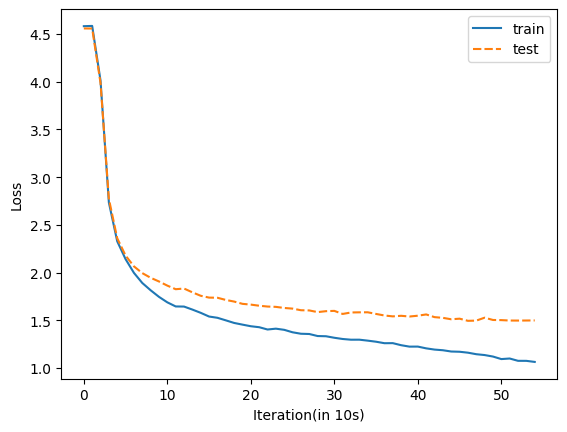

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
losses_df = pd.DataFrame(losses_data)
losses_df = losses_df.applymap(lambda x: float(x))
print(losses_df.head())
# Line graph of loss train and loss test
ax = sns.lineplot(data=losses_df[losses_df['train'] < 10])
ax.set(xlabel='Iteration(in 10s)', ylabel='Loss')
plt.show()